In [1]:
#!/usr/bin/env python3
from argparse import ArgumentParser
import numpy as np
import torch
from data import PermutedMNIST
from train import train
from model import MLP
import utils
import random
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler


batch_size = 128
fisher_estimation_sample_size = 2048
weight_decay = 0
cuda=False
task_number = 5





In [2]:
def imshow(img,labels):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(img[i].view(28,28), cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
            
            
def get_permute_mnist(task_number, use_validation = False):
   
    train_loader = {}
    test_loader = {}
    valid_loader = {}
    idx = list(range(28 * 28))
    for i in range(task_number):
        dataset = PermutedMNIST(train = True, permute_idx=idx)
        
        if use_validation:
            num_train = len(dataset)
            indices = list(range(num_train))
            #20 percent validation size
            split_index = int(np.floor(0.2 * num_train))
            train_index, valid_index = indices[split_index:], indices[:split_index]
            
            train_sampler = SubsetRandomSampler(train_index)
            valid_sampler = SubsetRandomSampler(valid_index)
            
            train_loader[i] = torch.utils.data.DataLoader(dataset,
                                                          batch_size=batch_size, sampler = train_sampler,
                                                          num_workers=4)
            valid_loader[i] = torch.utils.data.DataLoader(dataset,
                                                          batch_size=batch_size, sampler = valid_sampler,
                                                          num_workers=4)
            
        else:
            train_loader[i] = torch.utils.data.DataLoader(dataset,
                                                          batch_size=batch_size,
                                                          num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = False, permute_idx= idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
        
    if use_validation:
        return train_loader, valid_loader, test_loader
    
    return train_loader, test_loader




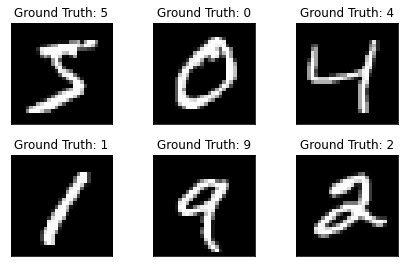

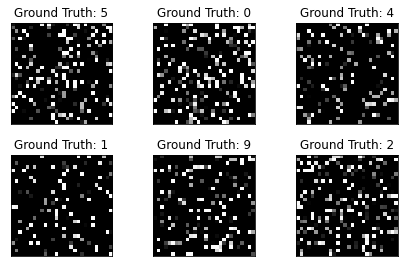

In [3]:
train_loader, test_loader = get_permute_mnist(task_number)

#unpermuted data:
examples_unpermuted = enumerate(train_loader[0])

_, (example_data_unpermuted, example_targets_unpermuted) = next(examples_unpermuted)

imshow(example_data_unpermuted[:6], example_targets_unpermuted[:6])

#permuted data:
examples_permuted = enumerate(train_loader[1])

_, (example_data_permuted, example_targets_permuted) = next(examples_permuted)
imshow(example_data_permuted[:6], example_targets_permuted[:6])

In [4]:
#could also cut last 5 items which are ignored by early stopping
def loss_plot(x):
    num_epochs = 0
    for task in range(1, task_number+1):
        plt.plot(range(num_epochs+1, num_epochs + 1 + len(x[task])), x[task] )
        num_epochs+= len(x[task])
        
def accuracy_plot(x):
    total_epochs = len(x[1])
    for task in range(1, task_number + 1):
        plt.plot(range(total_epochs+1 - len(x[task]), total_epochs+1), x[task] )



In [5]:
def avg_precision_plot(precisions, labels = []): #precisions needs to be in the form of the return value of train
    for num, precision in enumerate(precisions):    
        avg_precisions = []
        total_epochs = task_number*epochs_per_task
        for epoch in range (total_epochs):
            avg_precision = 0
            tasks_considered = epoch // epochs_per_task +1 #gives 1 for first task, 2 for second,...
            for i in range(1,tasks_considered+1): #
                avg_precision += precision[i][epoch - (i-1)*epochs_per_task]
            avg_precision/=tasks_considered
            avg_precisions.append(avg_precision)
        plt.ylim(0.88, 0.94)
        if (len(labels) == len(precisions)):
            plt.plot(range(total_epochs), avg_precisions, label = labels[num])
        else:
            plt.plot(range(total_epochs), avg_precisions)
    plt.legend()
    

In [6]:
#high learning rate, no dropout, no early stopping
hidden_size1=512
hidden_size2 = 256
lamda=400
lr=5.e-2
hidden_dropout_prob=0
input_dropout_prob=0
consolidate = False
epochs_per_task = 50

In [7]:
# prepare the model.
mlp_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_no_dropout_no_earlystopping)

# prepare the cuda if needed.
if cuda:
    mlp_no_dropout.cuda()


In [8]:
# run the standard experiment.
(standard_prec_no_dropout_no_earlystopping, 
 standard_total_loss_no_dropout_no_earlystopping,
 standard_ce_loss_no_dropout_no_earlystopping,
 standard_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_no_dropout_no_earlystopping, train_loader, test_loader, None,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4196 / ewc: 0.0 / total: 0.4196: : 469it [00:05, 90.38it/s] 
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3573 / ewc: 0.0 / total: 0.3573: : 469it [00:05, 83.92it/s]   
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3179 / ewc: 0.0 / total: 0.3179: : 469it [00:05, 86.17it/s]  
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2897 / ewc: 0.0 / total: 0.2897: : 469it [00:05, 86.73it/s]   
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2695 / ewc: 0.0 / total: 0.2695: : 469it [00:05, 86.45it/s]  
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2532 / ewc: 0.0 / total: 0.2532: : 469it [00:04, 96.44it/s]  
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss

=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2065 / ewc: 0.0 / total: 0.2065: : 469it [00:05, 86.32it/s]   
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.199 / ewc: 0.0 / total: 0.199: : 469it [00:05, 85.84it/s]    
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1946 / ewc: 0.0 / total: 0.1946: : 469it [00:05, 86.68it/s]  
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1899 / ewc: 0.0 / total: 0.1899: : 469it [00:05, 87.16it/s]  
=> task: 2/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1856 / ewc: 0.0 / total: 0.1856: : 469it [00:05, 87.10it/s]  
=> task: 2/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1809 / ewc: 0.0 / total: 0.1809: : 469it [00:05, 87.40it/s]  
=> task: 2/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | los

=> task: 3/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1868 / ewc: 0.0 / total: 0.1868: : 469it [00:06, 77.03it/s] 
=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1813 / ewc: 0.0 / total: 0.1813: : 469it [00:05, 82.98it/s] 
=> task: 3/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1783 / ewc: 0.0 / total: 0.1783: : 469it [00:05, 84.15it/s]  
=> task: 3/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1737 / ewc: 0.0 / total: 0.1737: : 469it [00:05, 78.64it/s]  
=> task: 3/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1696 / ewc: 0.0 / total: 0.1696: : 469it [00:05, 82.10it/s]  
=> task: 3/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1673 / ewc: 0.0 / total: 0.1673: : 469it [00:05, 84.81it/s]  
=> task: 3/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss

=> task: 4/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1672 / ewc: 0.0 / total: 0.1672: : 469it [00:04, 98.52it/s]  
=> task: 4/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1638 / ewc: 0.0 / total: 0.1638: : 469it [00:05, 83.03it/s]  
=> task: 4/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.16 / ewc: 0.0 / total: 0.16: : 469it [00:05, 84.47it/s]     
=> task: 4/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1553 / ewc: 0.0 / total: 0.1553: : 469it [00:05, 86.28it/s]  
=> task: 4/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.151 / ewc: 0.0 / total: 0.151: : 469it [00:05, 87.83it/s]    
=> task: 4/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1478 / ewc: 0.0 / total: 0.1478: : 469it [00:05, 86.53it/s]   
=> task: 4/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | 

=> task: 5/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.148 / ewc: 0.0 / total: 0.148: : 469it [00:05, 87.11it/s]    
=> task: 5/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1427 / ewc: 0.0 / total: 0.1427: : 469it [00:05, 87.29it/s]   
=> task: 5/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1392 / ewc: 0.0 / total: 0.1392: : 469it [00:05, 87.18it/s]   
=> task: 5/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1335 / ewc: 0.0 / total: 0.1335: : 469it [00:05, 86.85it/s]  
=> task: 5/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1251 / ewc: 0.0 / total: 0.1251: : 469it [00:05, 87.84it/s]   
=> task: 5/5 | epoch: 15/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1179 / ewc: 0.0 / total: 0.1179: : 469it [00:05, 87.26it/s]    
=> task: 5/5 | epoch: 16/50 | progress: [60032/60000] (100%) | prec: 0.

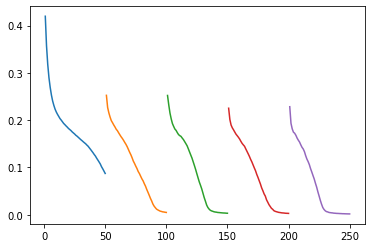

In [9]:
loss_plot(standard_total_loss_no_dropout_no_earlystopping)

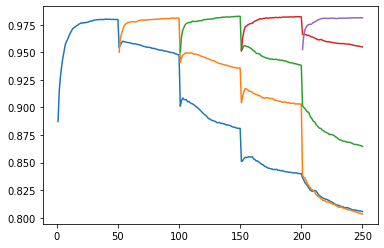

In [10]:
accuracy_plot(standard_prec_no_dropout_no_earlystopping)

In [11]:
mlp_consolidation_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_no_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_no_dropout_no_earlystopping, 
 ewc_total_loss_no_dropout_no_earlystopping, 
 ewc_ce_loss_no_dropout_no_earlystopping, 
 ewc_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_consolidation_no_dropout_no_earlystopping, train_loader, test_loader, None,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4286 / ewc: 0.0 / total: 0.4286: : 469it [00:05, 86.79it/s] 
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3623 / ewc: 0.0 / total: 0.3623: : 469it [00:05, 86.83it/s]   
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3253 / ewc: 0.0 / total: 0.3253: : 469it [00:05, 87.00it/s]   
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2986 / ewc: 0.0 / total: 0.2986: : 469it [00:05, 86.93it/s]   
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2783 / ewc: 0.0 / total: 0.2783: : 469it [00:05, 87.31it/s]   
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2633 / ewc: 0.0 / total: 0.2633: : 469it [00:05, 86.59it/s]   
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | l

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2514 / ewc: 0.02231 / total: 0.2737: : 469it [00:08, 56.35it/s] 
=> task: 2/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2263 / ewc: 0.01923 / total: 0.2455: : 469it [00:07, 61.85it/s] 
=> task: 2/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2135 / ewc: 0.01745 / total: 0.231: : 469it [00:07, 61.74it/s]  
=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2015 / ewc: 0.01622 / total: 0.2177: : 469it [00:07, 62.24it/s] 
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1931 / ewc: 0.01533 / total: 0.2084: : 469it [00:07, 62.40it/s] 
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1863 / ewc: 0.01461 / total: 0.2009: : 469it [00:07, 62.82it/s] 
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2505 / ewc: 0.0265 / total: 0.277: : 469it [00:08, 56.65it/s]   
=> task: 3/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.214 / ewc: 0.02035 / total: 0.2343: : 469it [00:07, 62.36it/s]  
=> task: 3/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1976 / ewc: 0.01757 / total: 0.2152: : 469it [00:07, 62.12it/s] 
=> task: 3/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1874 / ewc: 0.01587 / total: 0.2033: : 469it [00:07, 62.05it/s] 
=> task: 3/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1784 / ewc: 0.01474 / total: 0.1931: : 469it [00:07, 62.75it/s] 
=> task: 3/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1734 / ewc: 0.01389 / total: 0.1873: : 469it [00:07, 62.16it/s] 
=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2781 / ewc: 0.02009 / total: 0.2982: : 469it [00:08, 55.88it/s] 
=> task: 4/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2377 / ewc: 0.01594 / total: 0.2536: : 469it [00:07, 60.76it/s] 
=> task: 4/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2208 / ewc: 0.014 / total: 0.2348: : 469it [00:07, 60.82it/s]   
=> task: 4/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.211 / ewc: 0.01277 / total: 0.2238: : 469it [00:07, 61.16it/s]  
=> task: 4/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.198 / ewc: 0.01188 / total: 0.2099: : 469it [00:07, 61.25it/s]  
=> task: 4/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1901 / ewc: 0.01116 / total: 0.2013: : 469it [00:07, 63.59it/s] 
=> task: 4/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.264 / ewc: 0.01914 / total: 0.2831: : 469it [00:08, 56.19it/s]  
=> task: 5/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2383 / ewc: 0.01556 / total: 0.2539: : 469it [00:07, 60.62it/s] 
=> task: 5/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2234 / ewc: 0.01375 / total: 0.2371: : 469it [00:07, 61.67it/s] 
=> task: 5/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2118 / ewc: 0.01256 / total: 0.2243: : 469it [00:07, 60.83it/s] 
=> task: 5/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2004 / ewc: 0.01171 / total: 0.2121: : 469it [00:07, 60.94it/s] 
=> task: 5/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1887 / ewc: 0.01105 / total: 0.1998: : 469it [00:07, 60.33it/s] 
=> task: 5/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

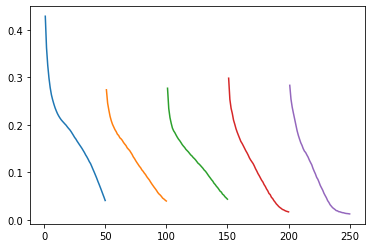

In [12]:
loss_plot(ewc_total_loss_no_dropout_no_earlystopping)

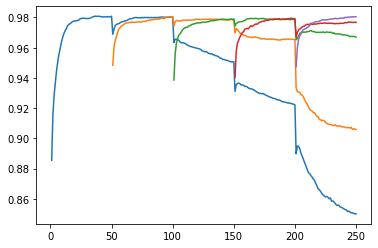

In [13]:
accuracy_plot(ewc_prec_no_dropout_no_earlystopping)

In [14]:
#high learning rate, dropout, no early stopping
hidden_dropout_prob = 0.5
input_dropout_prob = 0.2

In [15]:
# prepare the model.
mlp_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_dropout_no_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_no_earlystopping,
 standard_total_loss_dropout_no_earlystopping,
 standard_ce_loss_dropout_no_earlystopping,
 standard_ewc_loss_dropout_no_earlystopping) = train(
    mlp_dropout_no_earlystopping, train_loader, test_loader, None,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4728 / ewc: 0.0 / total: 0.4728: : 469it [00:05, 80.98it/s]
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4652 / ewc: 0.0 / total: 0.4652: : 469it [00:05, 81.40it/s]
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.3229 / ewc: 0.0 / total: 0.3229: : 469it [00:05, 80.35it/s]  
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2537 / ewc: 0.0 / total: 0.2537: : 469it [00:05, 80.26it/s]  
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3089 / ewc: 0.0 / total: 0.3089: : 469it [00:05, 80.17it/s]  
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2912 / ewc: 0.0 / total: 0.2912: : 469it [00:05, 81.58it/s] 
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce

=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1794 / ewc: 0.0 / total: 0.1794: : 469it [00:05, 88.78it/s]   
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1962 / ewc: 0.0 / total: 0.1962: : 469it [00:05, 81.94it/s]  
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2103 / ewc: 0.0 / total: 0.2103: : 469it [00:05, 80.08it/s]  
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2268 / ewc: 0.0 / total: 0.2268: : 469it [00:05, 81.53it/s]  
=> task: 2/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1667 / ewc: 0.0 / total: 0.1667: : 469it [00:05, 82.17it/s]  
=> task: 2/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1723 / ewc: 0.0 / total: 0.1723: : 469it [00:05, 82.74it/s] 
=> task: 2/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss

=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1712 / ewc: 0.0 / total: 0.1712: : 469it [00:05, 81.68it/s]  
=> task: 3/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1505 / ewc: 0.0 / total: 0.1505: : 469it [00:05, 81.80it/s] 
=> task: 3/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1082 / ewc: 0.0 / total: 0.1082: : 469it [00:05, 82.09it/s] 
=> task: 3/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.142 / ewc: 0.0 / total: 0.142: : 469it [00:05, 89.98it/s]     
=> task: 3/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1615 / ewc: 0.0 / total: 0.1615: : 469it [00:05, 93.54it/s]  
=> task: 3/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1031 / ewc: 0.0 / total: 0.1031: : 469it [00:05, 83.54it/s]  
=> task: 3/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | lo

=> task: 4/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1232 / ewc: 0.0 / total: 0.1232: : 469it [00:05, 82.11it/s]  
=> task: 4/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1888 / ewc: 0.0 / total: 0.1888: : 469it [00:05, 81.75it/s] 
=> task: 4/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1533 / ewc: 0.0 / total: 0.1533: : 469it [00:05, 81.95it/s]  
=> task: 4/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1262 / ewc: 0.0 / total: 0.1262: : 469it [00:05, 88.92it/s]  
=> task: 4/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1279 / ewc: 0.0 / total: 0.1279: : 469it [00:05, 82.29it/s]  
=> task: 4/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1854 / ewc: 0.0 / total: 0.1854: : 469it [00:05, 83.58it/s] 
=> task: 4/5 | epoch: 15/50 | progress: [60032/60000] (100%) | prec: 0.9792 | l

=> task: 5/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2109 / ewc: 0.0 / total: 0.2109: : 469it [00:05, 81.37it/s] 
=> task: 5/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.159 / ewc: 0.0 / total: 0.159: : 469it [00:05, 82.09it/s]   
=> task: 5/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08908 / ewc: 0.0 / total: 0.08908: : 469it [00:05, 81.61it/s]
=> task: 5/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 469it [00:05, 82.69it/s] 
=> task: 5/5 | epoch: 15/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1637 / ewc: 0.0 / total: 0.1637: : 469it [00:05, 83.22it/s]   
=> task: 5/5 | epoch: 16/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.104 / ewc: 0.0 / total: 0.104: : 469it [00:05, 83.49it/s]     
=> task: 5/5 | epoch: 17/50 | progress: [60032/60000] (100%) | prec: 0.9896 |

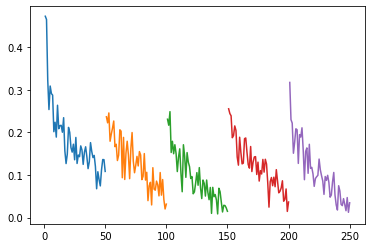

In [16]:
loss_plot(standard_total_loss_dropout_no_earlystopping)

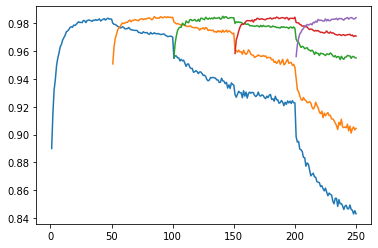

In [17]:
accuracy_plot(standard_prec_dropout_no_earlystopping)

In [18]:
mlp_consolidation_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_no_earlystopping, 
 ewc_total_loss_dropout_no_earlystopping, 
 ewc_ce_loss_dropout_no_earlystopping, 
 ewc_ewc_loss_dropout_no_earlystopping) =train(
    mlp_consolidation_dropout_no_earlystopping, train_loader, test_loader, None,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4807 / ewc: 0.0 / total: 0.4807: : 469it [00:05, 81.09it/s]
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3475 / ewc: 0.0 / total: 0.3475: : 469it [00:05, 82.12it/s] 
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3362 / ewc: 0.0 / total: 0.3362: : 469it [00:05, 81.60it/s]  
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3212 / ewc: 0.0 / total: 0.3212: : 469it [00:05, 79.98it/s]  
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.283 / ewc: 0.0 / total: 0.283: : 469it [00:05, 82.01it/s]    
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2522 / ewc: 0.0 / total: 0.2522: : 469it [00:05, 82.43it/s]  
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3577 / ewc: 0.03035 / total: 0.3881: : 469it [00:09, 49.76it/s]  
=> task: 2/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2792 / ewc: 0.0241 / total: 0.3033: : 469it [00:08, 56.30it/s]  
=> task: 2/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2648 / ewc: 0.02103 / total: 0.2858: : 469it [00:08, 56.73it/s] 
=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1806 / ewc: 0.01911 / total: 0.1997: : 469it [00:08, 57.45it/s]  
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1967 / ewc: 0.01818 / total: 0.2149: : 469it [00:08, 56.78it/s] 
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2034 / ewc: 0.0172 / total: 0.2206: : 469it [00:08, 58.24it/s]   
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) |

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3356 / ewc: 0.03 / total: 0.3656: : 469it [00:08, 53.84it/s]    
=> task: 3/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2519 / ewc: 0.02414 / total: 0.276: : 469it [00:08, 57.66it/s]   
=> task: 3/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1839 / ewc: 0.02127 / total: 0.2051: : 469it [00:08, 55.73it/s] 
=> task: 3/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2105 / ewc: 0.01944 / total: 0.23: : 469it [00:08, 57.83it/s]   
=> task: 3/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1833 / ewc: 0.01812 / total: 0.2014: : 469it [00:07, 60.60it/s]  
=> task: 3/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1352 / ewc: 0.01722 / total: 0.1524: : 469it [00:08, 58.46it/s]  
=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) |

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3128 / ewc: 0.02738 / total: 0.3402: : 469it [00:08, 53.87it/s] 
=> task: 4/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.216 / ewc: 0.02073 / total: 0.2368: : 469it [00:08, 58.42it/s]   
=> task: 4/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.213 / ewc: 0.01771 / total: 0.2307: : 469it [00:08, 58.01it/s]  
=> task: 4/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2815 / ewc: 0.01593 / total: 0.2974: : 469it [00:08, 58.54it/s]  
=> task: 4/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.218 / ewc: 0.01445 / total: 0.2324: : 469it [00:07, 58.71it/s]  
=> task: 4/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2607 / ewc: 0.01373 / total: 0.2744: : 469it [00:08, 58.39it/s]  
=> task: 4/5 | epoch: 7/50 | progress: [60032/60000] (100%) |

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2681 / ewc: 0.026 / total: 0.2941: : 469it [00:08, 54.10it/s]    
=> task: 5/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2178 / ewc: 0.02059 / total: 0.2384: : 469it [00:08, 58.35it/s]  
=> task: 5/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1859 / ewc: 0.01782 / total: 0.2037: : 469it [00:08, 58.38it/s]  
=> task: 5/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1898 / ewc: 0.01619 / total: 0.206: : 469it [00:08, 58.55it/s]   
=> task: 5/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2463 / ewc: 0.01526 / total: 0.2616: : 469it [00:07, 59.09it/s] 
=> task: 5/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1724 / ewc: 0.01447 / total: 0.1869: : 469it [00:07, 58.91it/s]  
=> task: 5/5 | epoch: 7/50 | progress: [60032/60000] (100%)

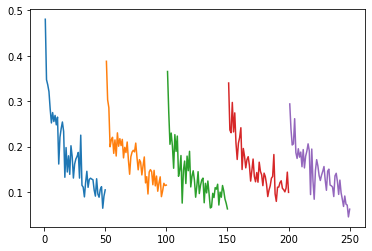

In [19]:
loss_plot(ewc_total_loss_dropout_no_earlystopping)

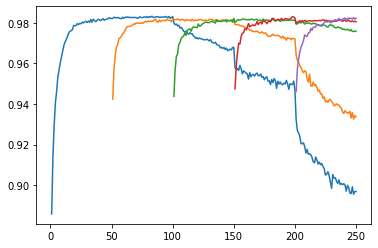

In [20]:
accuracy_plot(ewc_prec_dropout_no_earlystopping)
#model capacity reached after fourth task?

In [21]:
#dropout and early stopping
train_loader, valid_loader, test_loader = get_permute_mnist(task_number, True)



In [22]:
mlp_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_dropout_earlystopping)
# run the standard experiment.
consolidate = False
(standard_prec_dropout_earlystopping, 
 standard_total_loss_dropout_earlystopping,
 standard_ce_loss_dropout_earlystopping,
 standard_ewc_loss_dropout_earlystopping) = train(
    mlp_dropout_earlystopping, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.8125 | loss => ce: 0.5374 / ewc: 0.0 / total: 0.5374: : 375it [00:04, 80.15it/s]


Validation loss decreased (inf --> 0.439946).  Saving model ...


=> task: 1/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3201 / ewc: 0.0 / total: 0.3201: : 375it [00:05, 72.94it/s]


Validation loss decreased (0.439946 --> 0.319463).  Saving model ...


=> task: 1/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.411 / ewc: 0.0 / total: 0.411: : 375it [00:04, 75.28it/s]  


Validation loss decreased (0.319463 --> 0.270134).  Saving model ...


=> task: 1/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2388 / ewc: 0.0 / total: 0.2388: : 375it [00:04, 77.20it/s]


Validation loss decreased (0.270134 --> 0.228486).  Saving model ...


=> task: 1/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2077 / ewc: 0.0 / total: 0.2077: : 375it [00:04, 76.60it/s]


Validation loss decreased (0.228486 --> 0.202405).  Saving model ...


=> task: 1/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1502 / ewc: 0.0 / total: 0.1502: : 375it [00:05, 73.66it/s] 


Validation loss decreased (0.202405 --> 0.175238).  Saving model ...


=> task: 1/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2999 / ewc: 0.0 / total: 0.2999: : 375it [00:05, 73.14it/s] 


Validation loss decreased (0.175238 --> 0.160035).  Saving model ...


=> task: 1/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09024 / ewc: 0.0 / total: 0.09024: : 375it [00:05, 73.68it/s]


Validation loss decreased (0.160035 --> 0.146306).  Saving model ...


=> task: 1/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3138 / ewc: 0.0 / total: 0.3138: : 375it [00:05, 73.43it/s] 


Validation loss decreased (0.146306 --> 0.137274).  Saving model ...


=> task: 1/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1604 / ewc: 0.0 / total: 0.1604: : 375it [00:04, 77.65it/s] 


Validation loss decreased (0.137274 --> 0.125782).  Saving model ...


=> task: 1/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06484 / ewc: 0.0 / total: 0.06484: : 375it [00:04, 77.79it/s]


Validation loss decreased (0.125782 --> 0.118456).  Saving model ...


=> task: 1/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1956 / ewc: 0.0 / total: 0.1956: : 375it [00:04, 78.57it/s]  


Validation loss decreased (0.118456 --> 0.112457).  Saving model ...


=> task: 1/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1634 / ewc: 0.0 / total: 0.1634: : 375it [00:04, 76.16it/s]  


Validation loss decreased (0.112457 --> 0.107354).  Saving model ...


=> task: 1/5 | epoch: 14/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.129 / ewc: 0.0 / total: 0.129: : 375it [00:04, 76.52it/s]   


Validation loss decreased (0.107354 --> 0.103312).  Saving model ...


=> task: 1/5 | epoch: 15/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.094 / ewc: 0.0 / total: 0.094: : 375it [00:04, 76.74it/s]   


Validation loss decreased (0.103312 --> 0.098242).  Saving model ...


=> task: 1/5 | epoch: 16/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07065 / ewc: 0.0 / total: 0.07065: : 375it [00:04, 76.99it/s]


Validation loss decreased (0.098242 --> 0.092908).  Saving model ...


=> task: 1/5 | epoch: 17/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07937 / ewc: 0.0 / total: 0.07937: : 375it [00:04, 77.04it/s]


Validation loss decreased (0.092908 --> 0.090781).  Saving model ...


=> task: 1/5 | epoch: 18/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1205 / ewc: 0.0 / total: 0.1205: : 375it [00:04, 76.95it/s] 


Validation loss decreased (0.090781 --> 0.089042).  Saving model ...


=> task: 1/5 | epoch: 19/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1585 / ewc: 0.0 / total: 0.1585: : 375it [00:04, 77.01it/s]  


Validation loss decreased (0.089042 --> 0.085419).  Saving model ...


=> task: 1/5 | epoch: 20/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1025 / ewc: 0.0 / total: 0.1025: : 375it [00:04, 77.61it/s] 


Validation loss decreased (0.085419 --> 0.083644).  Saving model ...


=> task: 1/5 | epoch: 21/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0582 / ewc: 0.0 / total: 0.0582: : 375it [00:04, 77.10it/s] 


Validation loss decreased (0.083644 --> 0.082336).  Saving model ...


=> task: 1/5 | epoch: 22/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1002 / ewc: 0.0 / total: 0.1002: : 375it [00:04, 76.64it/s] 


Validation loss decreased (0.082336 --> 0.078939).  Saving model ...


=> task: 1/5 | epoch: 23/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01935 / ewc: 0.0 / total: 0.01935: : 375it [00:04, 77.78it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 24/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08968 / ewc: 0.0 / total: 0.08968: : 375it [00:04, 77.50it/s]


Validation loss decreased (0.078939 --> 0.077226).  Saving model ...


=> task: 1/5 | epoch: 25/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05786 / ewc: 0.0 / total: 0.05786: : 375it [00:04, 78.04it/s]


Validation loss decreased (0.077226 --> 0.075441).  Saving model ...


=> task: 1/5 | epoch: 26/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0778 / ewc: 0.0 / total: 0.0778: : 375it [00:04, 78.81it/s] 


Validation loss decreased (0.075441 --> 0.074007).  Saving model ...


=> task: 1/5 | epoch: 27/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07541 / ewc: 0.0 / total: 0.07541: : 375it [00:04, 77.78it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 28/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03315 / ewc: 0.0 / total: 0.03315: : 375it [00:04, 78.50it/s]   


Validation loss decreased (0.074007 --> 0.072344).  Saving model ...


=> task: 1/5 | epoch: 29/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05713 / ewc: 0.0 / total: 0.05713: : 375it [00:04, 79.29it/s]


Validation loss decreased (0.072344 --> 0.072003).  Saving model ...


=> task: 1/5 | epoch: 30/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08204 / ewc: 0.0 / total: 0.08204: : 375it [00:04, 77.99it/s]


Validation loss decreased (0.072003 --> 0.071591).  Saving model ...


=> task: 1/5 | epoch: 31/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.02862 / ewc: 0.0 / total: 0.02862: : 375it [00:04, 76.99it/s]


Validation loss decreased (0.071591 --> 0.070490).  Saving model ...


=> task: 1/5 | epoch: 32/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06861 / ewc: 0.0 / total: 0.06861: : 375it [00:04, 78.87it/s]


Validation loss decreased (0.070490 --> 0.069367).  Saving model ...


=> task: 1/5 | epoch: 33/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.04252 / ewc: 0.0 / total: 0.04252: : 375it [00:04, 77.45it/s]


Validation loss decreased (0.069367 --> 0.069222).  Saving model ...


=> task: 1/5 | epoch: 34/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0794 / ewc: 0.0 / total: 0.0794: : 375it [00:04, 80.03it/s]   


Validation loss decreased (0.069222 --> 0.067788).  Saving model ...


=> task: 1/5 | epoch: 35/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.03509 / ewc: 0.0 / total: 0.03509: : 375it [00:04, 77.35it/s]


Validation loss decreased (0.067788 --> 0.067648).  Saving model ...


=> task: 1/5 | epoch: 36/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.06212 / ewc: 0.0 / total: 0.06212: : 375it [00:04, 80.03it/s]


Validation loss decreased (0.067648 --> 0.067068).  Saving model ...


=> task: 1/5 | epoch: 37/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04501 / ewc: 0.0 / total: 0.04501: : 375it [00:04, 78.26it/s]


Validation loss decreased (0.067068 --> 0.066643).  Saving model ...


=> task: 1/5 | epoch: 38/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07903 / ewc: 0.0 / total: 0.07903: : 375it [00:04, 77.75it/s]


Validation loss decreased (0.066643 --> 0.066491).  Saving model ...


=> task: 1/5 | epoch: 39/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03593 / ewc: 0.0 / total: 0.03593: : 375it [00:04, 77.47it/s]   


Validation loss decreased (0.066491 --> 0.066405).  Saving model ...


=> task: 1/5 | epoch: 40/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02175 / ewc: 0.0 / total: 0.02175: : 375it [00:04, 78.31it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 41/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.08119 / ewc: 0.0 / total: 0.08119: : 375it [00:04, 76.93it/s]


Validation loss decreased (0.066405 --> 0.065916).  Saving model ...


=> task: 1/5 | epoch: 42/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01163 / ewc: 0.0 / total: 0.01163: : 375it [00:04, 78.36it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 43/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.03427 / ewc: 0.0 / total: 0.03427: : 375it [00:04, 83.78it/s] 


Validation loss decreased (0.065916 --> 0.065382).  Saving model ...


=> task: 1/5 | epoch: 44/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0363 / ewc: 0.0 / total: 0.0363: : 375it [00:04, 77.92it/s] 


Validation loss decreased (0.065382 --> 0.064134).  Saving model ...


=> task: 1/5 | epoch: 45/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02731 / ewc: 0.0 / total: 0.02731: : 375it [00:04, 78.08it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 46/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0328 / ewc: 0.0 / total: 0.0328: : 375it [00:04, 76.72it/s]  


Validation loss decreased (0.064134 --> 0.064044).  Saving model ...


=> task: 1/5 | epoch: 47/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.03901 / ewc: 0.0 / total: 0.03901: : 375it [00:04, 77.79it/s] 


Validation loss decreased (0.064044 --> 0.063760).  Saving model ...


=> task: 1/5 | epoch: 48/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.05241 / ewc: 0.0 / total: 0.05241: : 375it [00:04, 77.42it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 49/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.0157 / ewc: 0.0 / total: 0.0157: : 375it [00:04, 78.48it/s]    


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 50/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01408 / ewc: 0.0 / total: 0.01408: : 375it [00:04, 76.80it/s]   


Validation loss decreased (0.063760 --> 0.063631).  Saving model ...


=> task: 2/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2533 / ewc: 0.0 / total: 0.2533: : 375it [00:04, 78.63it/s]


Validation loss decreased (inf --> 0.119069).  Saving model ...


=> task: 2/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1154 / ewc: 0.0 / total: 0.1154: : 375it [00:04, 78.57it/s] 


Validation loss decreased (0.119069 --> 0.102997).  Saving model ...


=> task: 2/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09818 / ewc: 0.0 / total: 0.09818: : 375it [00:04, 77.27it/s]


Validation loss decreased (0.102997 --> 0.093189).  Saving model ...


=> task: 2/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1168 / ewc: 0.0 / total: 0.1168: : 375it [00:04, 76.63it/s]  


Validation loss decreased (0.093189 --> 0.089375).  Saving model ...


=> task: 2/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1663 / ewc: 0.0 / total: 0.1663: : 375it [00:04, 78.60it/s]  


Validation loss decreased (0.089375 --> 0.086149).  Saving model ...


=> task: 2/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1771 / ewc: 0.0 / total: 0.1771: : 375it [00:04, 78.41it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04353 / ewc: 0.0 / total: 0.04353: : 375it [00:04, 78.82it/s]


Validation loss decreased (0.086149 --> 0.083184).  Saving model ...


=> task: 2/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1118 / ewc: 0.0 / total: 0.1118: : 375it [00:04, 76.87it/s]  


Validation loss decreased (0.083184 --> 0.082719).  Saving model ...


=> task: 2/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02519 / ewc: 0.0 / total: 0.02519: : 375it [00:04, 84.84it/s]   


Validation loss decreased (0.082719 --> 0.081322).  Saving model ...


=> task: 2/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08298 / ewc: 0.0 / total: 0.08298: : 375it [00:04, 78.43it/s]


Validation loss decreased (0.081322 --> 0.080580).  Saving model ...


=> task: 2/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04675 / ewc: 0.0 / total: 0.04675: : 375it [00:04, 78.69it/s]


Validation loss decreased (0.080580 --> 0.080464).  Saving model ...


=> task: 2/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02597 / ewc: 0.0 / total: 0.02597: : 375it [00:04, 77.28it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04172 / ewc: 0.0 / total: 0.04172: : 375it [00:04, 77.16it/s]


Validation loss decreased (0.080464 --> 0.079320).  Saving model ...


=> task: 2/5 | epoch: 14/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08947 / ewc: 0.0 / total: 0.08947: : 375it [00:04, 78.53it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 15/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1052 / ewc: 0.0 / total: 0.1052: : 375it [00:04, 78.74it/s]  


Validation loss decreased (0.079320 --> 0.079066).  Saving model ...


=> task: 2/5 | epoch: 16/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05853 / ewc: 0.0 / total: 0.05853: : 375it [00:04, 78.01it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 17/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.03196 / ewc: 0.0 / total: 0.03196: : 375it [00:04, 77.78it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 18/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.01865 / ewc: 0.0 / total: 0.01865: : 375it [00:05, 73.59it/s]


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 19/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02469 / ewc: 0.0 / total: 0.02469: : 375it [00:05, 72.62it/s]


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 20/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06716 / ewc: 0.0 / total: 0.06716: : 375it [00:04, 79.20it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 3/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2983 / ewc: 0.0 / total: 0.2983: : 375it [00:04, 76.85it/s] 


Validation loss decreased (inf --> 0.120426).  Saving model ...


=> task: 3/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1676 / ewc: 0.0 / total: 0.1676: : 375it [00:04, 76.64it/s] 


Validation loss decreased (0.120426 --> 0.105560).  Saving model ...


=> task: 3/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.104 / ewc: 0.0 / total: 0.104: : 375it [00:04, 75.85it/s]   


Validation loss decreased (0.105560 --> 0.104022).  Saving model ...


=> task: 3/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1177 / ewc: 0.0 / total: 0.1177: : 375it [00:04, 83.41it/s]   


Validation loss decreased (0.104022 --> 0.099410).  Saving model ...


=> task: 3/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.07061 / ewc: 0.0 / total: 0.07061: : 375it [00:04, 77.33it/s]


Validation loss decreased (0.099410 --> 0.098888).  Saving model ...


=> task: 3/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1122 / ewc: 0.0 / total: 0.1122: : 375it [00:04, 78.29it/s] 


Validation loss decreased (0.098888 --> 0.098356).  Saving model ...


=> task: 3/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1073 / ewc: 0.0 / total: 0.1073: : 375it [00:04, 78.03it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04052 / ewc: 0.0 / total: 0.04052: : 375it [00:04, 77.92it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08231 / ewc: 0.0 / total: 0.08231: : 375it [00:04, 78.10it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05011 / ewc: 0.0 / total: 0.05011: : 375it [00:04, 77.51it/s]


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09024 / ewc: 0.0 / total: 0.09024: : 375it [00:04, 80.33it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 4/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3311 / ewc: 0.0 / total: 0.3311: : 375it [00:04, 77.13it/s]


Validation loss decreased (inf --> 0.126125).  Saving model ...


=> task: 4/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1021 / ewc: 0.0 / total: 0.1021: : 375it [00:04, 78.62it/s] 


Validation loss decreased (0.126125 --> 0.117485).  Saving model ...


=> task: 4/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1339 / ewc: 0.0 / total: 0.1339: : 375it [00:04, 77.91it/s] 


Validation loss decreased (0.117485 --> 0.114076).  Saving model ...


=> task: 4/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09735 / ewc: 0.0 / total: 0.09735: : 375it [00:04, 77.99it/s]


Validation loss decreased (0.114076 --> 0.112556).  Saving model ...


=> task: 4/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05257 / ewc: 0.0 / total: 0.05257: : 375it [00:04, 77.73it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08817 / ewc: 0.0 / total: 0.08817: : 375it [00:04, 79.19it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07057 / ewc: 0.0 / total: 0.07057: : 375it [00:04, 78.51it/s]


Validation loss decreased (0.112556 --> 0.111183).  Saving model ...


=> task: 4/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1176 / ewc: 0.0 / total: 0.1176: : 375it [00:05, 73.24it/s]  


Validation loss decreased (0.111183 --> 0.109650).  Saving model ...


=> task: 4/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05661 / ewc: 0.0 / total: 0.05661: : 375it [00:04, 77.21it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06237 / ewc: 0.0 / total: 0.06237: : 375it [00:05, 73.95it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04113 / ewc: 0.0 / total: 0.04113: : 375it [00:05, 72.00it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01757 / ewc: 0.0 / total: 0.01757: : 375it [00:04, 76.46it/s]   


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02156 / ewc: 0.0 / total: 0.02156: : 375it [00:04, 76.82it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 5/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1787 / ewc: 0.0 / total: 0.1787: : 375it [00:04, 77.25it/s]


Validation loss decreased (inf --> 0.136350).  Saving model ...


=> task: 5/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1247 / ewc: 0.0 / total: 0.1247: : 375it [00:04, 79.63it/s] 


Validation loss decreased (0.136350 --> 0.129661).  Saving model ...


=> task: 5/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1159 / ewc: 0.0 / total: 0.1159: : 375it [00:04, 76.67it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.08077 / ewc: 0.0 / total: 0.08077: : 375it [00:04, 76.81it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1364 / ewc: 0.0 / total: 0.1364: : 375it [00:04, 75.25it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03506 / ewc: 0.0 / total: 0.03506: : 375it [00:04, 78.35it/s]   


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03439 / ewc: 0.0 / total: 0.03439: : 375it [00:04, 78.60it/s]   


EarlyStopping counter: 5 out of 5
Early stopping


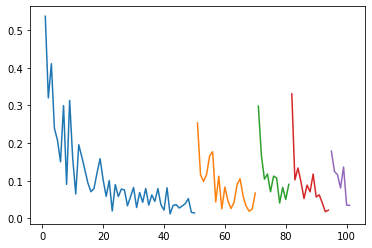

In [23]:
loss_plot(standard_total_loss_dropout_earlystopping)

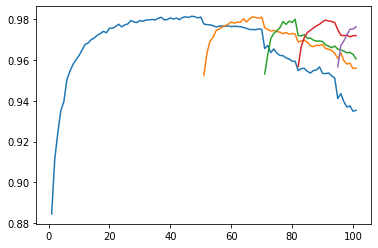

In [24]:
accuracy_plot(standard_prec_dropout_earlystopping)

In [25]:
mlp_consolidation_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_earlystopping,
 ewc_total_loss_dropout_earlystopping, 
 ewc_ce_loss_dropout_earlystopping,
 ewc_ewc_loss_dropout_earlystopping) =train(
    mlp_consolidation_dropout_earlystopping, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4791 / ewc: 0.0 / total: 0.4791: : 375it [00:04, 78.35it/s] 


Validation loss decreased (inf --> 0.437814).  Saving model ...


=> task: 1/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3753 / ewc: 0.0 / total: 0.3753: : 375it [00:04, 77.93it/s]


Validation loss decreased (0.437814 --> 0.317996).  Saving model ...


=> task: 1/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2813 / ewc: 0.0 / total: 0.2813: : 375it [00:04, 77.41it/s]


Validation loss decreased (0.317996 --> 0.261757).  Saving model ...


=> task: 1/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2394 / ewc: 0.0 / total: 0.2394: : 375it [00:04, 77.40it/s]


Validation loss decreased (0.261757 --> 0.226200).  Saving model ...


=> task: 1/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2486 / ewc: 0.0 / total: 0.2486: : 375it [00:04, 77.15it/s]


Validation loss decreased (0.226200 --> 0.197373).  Saving model ...


=> task: 1/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1644 / ewc: 0.0 / total: 0.1644: : 375it [00:04, 77.36it/s]


Validation loss decreased (0.197373 --> 0.176776).  Saving model ...


=> task: 1/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1396 / ewc: 0.0 / total: 0.1396: : 375it [00:04, 77.94it/s] 


Validation loss decreased (0.176776 --> 0.157552).  Saving model ...


=> task: 1/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1569 / ewc: 0.0 / total: 0.1569: : 375it [00:04, 78.16it/s] 


Validation loss decreased (0.157552 --> 0.146589).  Saving model ...


=> task: 1/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1182 / ewc: 0.0 / total: 0.1182: : 375it [00:04, 77.50it/s] 


Validation loss decreased (0.146589 --> 0.133825).  Saving model ...


=> task: 1/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2212 / ewc: 0.0 / total: 0.2212: : 375it [00:04, 77.64it/s] 


Validation loss decreased (0.133825 --> 0.126566).  Saving model ...


=> task: 1/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1441 / ewc: 0.0 / total: 0.1441: : 375it [00:04, 77.27it/s] 


Validation loss decreased (0.126566 --> 0.117802).  Saving model ...


=> task: 1/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1051 / ewc: 0.0 / total: 0.1051: : 375it [00:04, 77.44it/s] 


Validation loss decreased (0.117802 --> 0.113504).  Saving model ...


=> task: 1/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1615 / ewc: 0.0 / total: 0.1615: : 375it [00:04, 78.26it/s] 


Validation loss decreased (0.113504 --> 0.106719).  Saving model ...


=> task: 1/5 | epoch: 14/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.094 / ewc: 0.0 / total: 0.094: : 375it [00:04, 76.92it/s]   


Validation loss decreased (0.106719 --> 0.100633).  Saving model ...


=> task: 1/5 | epoch: 15/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1696 / ewc: 0.0 / total: 0.1696: : 375it [00:04, 77.47it/s] 


Validation loss decreased (0.100633 --> 0.097917).  Saving model ...


=> task: 1/5 | epoch: 16/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07695 / ewc: 0.0 / total: 0.07695: : 375it [00:04, 78.28it/s]


Validation loss decreased (0.097917 --> 0.095170).  Saving model ...


=> task: 1/5 | epoch: 17/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07915 / ewc: 0.0 / total: 0.07915: : 375it [00:04, 77.37it/s]


Validation loss decreased (0.095170 --> 0.091450).  Saving model ...


=> task: 1/5 | epoch: 18/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04516 / ewc: 0.0 / total: 0.04516: : 375it [00:04, 77.32it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 19/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1145 / ewc: 0.0 / total: 0.1145: : 375it [00:04, 77.67it/s] 


Validation loss decreased (0.091450 --> 0.087082).  Saving model ...


=> task: 1/5 | epoch: 20/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1312 / ewc: 0.0 / total: 0.1312: : 375it [00:04, 75.71it/s]  


Validation loss decreased (0.087082 --> 0.084518).  Saving model ...


=> task: 1/5 | epoch: 21/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04209 / ewc: 0.0 / total: 0.04209: : 375it [00:04, 77.99it/s]


Validation loss decreased (0.084518 --> 0.081615).  Saving model ...


=> task: 1/5 | epoch: 22/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09987 / ewc: 0.0 / total: 0.09987: : 375it [00:04, 78.09it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 23/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08849 / ewc: 0.0 / total: 0.08849: : 375it [00:04, 76.83it/s]


Validation loss decreased (0.081615 --> 0.077833).  Saving model ...


=> task: 1/5 | epoch: 24/50 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.257 / ewc: 0.0 / total: 0.257: : 375it [00:04, 77.21it/s]    


Validation loss decreased (0.077833 --> 0.076100).  Saving model ...


=> task: 1/5 | epoch: 25/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07065 / ewc: 0.0 / total: 0.07065: : 375it [00:04, 78.30it/s]


Validation loss decreased (0.076100 --> 0.075867).  Saving model ...


=> task: 1/5 | epoch: 26/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07792 / ewc: 0.0 / total: 0.07792: : 375it [00:04, 77.58it/s]


Validation loss decreased (0.075867 --> 0.075001).  Saving model ...


=> task: 1/5 | epoch: 27/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09207 / ewc: 0.0 / total: 0.09207: : 375it [00:04, 78.66it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 28/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08893 / ewc: 0.0 / total: 0.08893: : 375it [00:04, 78.45it/s]


Validation loss decreased (0.075001 --> 0.073507).  Saving model ...


=> task: 1/5 | epoch: 29/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1366 / ewc: 0.0 / total: 0.1366: : 375it [00:04, 77.71it/s] 


Validation loss decreased (0.073507 --> 0.071685).  Saving model ...


=> task: 1/5 | epoch: 30/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02863 / ewc: 0.0 / total: 0.02863: : 375it [00:04, 78.16it/s]


Validation loss decreased (0.071685 --> 0.071438).  Saving model ...


=> task: 1/5 | epoch: 31/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0241 / ewc: 0.0 / total: 0.0241: : 375it [00:04, 76.50it/s] 


Validation loss decreased (0.071438 --> 0.070583).  Saving model ...


=> task: 1/5 | epoch: 32/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04297 / ewc: 0.0 / total: 0.04297: : 375it [00:04, 77.69it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 33/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04112 / ewc: 0.0 / total: 0.04112: : 375it [00:04, 77.94it/s]


Validation loss decreased (0.070583 --> 0.070076).  Saving model ...


=> task: 1/5 | epoch: 34/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.031 / ewc: 0.0 / total: 0.031: : 375it [00:04, 77.39it/s]       


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 35/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0526 / ewc: 0.0 / total: 0.0526: : 375it [00:04, 77.35it/s]  


Validation loss decreased (0.070076 --> 0.069678).  Saving model ...


=> task: 1/5 | epoch: 36/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.05823 / ewc: 0.0 / total: 0.05823: : 375it [00:04, 78.48it/s]


Validation loss decreased (0.069678 --> 0.069480).  Saving model ...


=> task: 1/5 | epoch: 37/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01758 / ewc: 0.0 / total: 0.01758: : 375it [00:04, 77.63it/s]   


Validation loss decreased (0.069480 --> 0.068487).  Saving model ...


=> task: 1/5 | epoch: 38/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03224 / ewc: 0.0 / total: 0.03224: : 375it [00:04, 78.14it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 39/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03812 / ewc: 0.0 / total: 0.03812: : 375it [00:04, 86.85it/s] 


Validation loss decreased (0.068487 --> 0.066484).  Saving model ...


=> task: 1/5 | epoch: 40/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04035 / ewc: 0.0 / total: 0.04035: : 375it [00:04, 77.53it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 41/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04282 / ewc: 0.0 / total: 0.04282: : 375it [00:04, 78.68it/s]


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 42/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.006755 / ewc: 0.0 / total: 0.006755: : 375it [00:04, 78.15it/s] 


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 43/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02507 / ewc: 0.0 / total: 0.02507: : 375it [00:04, 77.25it/s]   


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 44/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02963 / ewc: 0.0 / total: 0.02963: : 375it [00:04, 78.68it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1714 / ewc: 0.03333 / total: 0.2047: : 375it [00:07, 50.96it/s]


Validation loss decreased (inf --> 0.128497).  Saving model ...


=> task: 2/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.2709 / ewc: 0.02828 / total: 0.2991: : 375it [00:06, 56.12it/s]


Validation loss decreased (0.128497 --> 0.112242).  Saving model ...


=> task: 2/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1345 / ewc: 0.02523 / total: 0.1597: : 375it [00:06, 56.52it/s]


Validation loss decreased (0.112242 --> 0.100804).  Saving model ...


=> task: 2/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1952 / ewc: 0.02276 / total: 0.218: : 375it [00:06, 56.38it/s]  


Validation loss decreased (0.100804 --> 0.097041).  Saving model ...


=> task: 2/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1258 / ewc: 0.02133 / total: 0.1472: : 375it [00:06, 55.98it/s] 


Validation loss decreased (0.097041 --> 0.092045).  Saving model ...


=> task: 2/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1529 / ewc: 0.02014 / total: 0.173: : 375it [00:06, 57.26it/s]  


Validation loss decreased (0.092045 --> 0.090641).  Saving model ...


=> task: 2/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09661 / ewc: 0.01944 / total: 0.1161: : 375it [00:06, 56.39it/s]


Validation loss decreased (0.090641 --> 0.090158).  Saving model ...


=> task: 2/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1043 / ewc: 0.0187 / total: 0.123: : 375it [00:06, 56.09it/s]    


Validation loss decreased (0.090158 --> 0.086341).  Saving model ...


=> task: 2/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0656 / ewc: 0.01804 / total: 0.08364: : 375it [00:06, 56.05it/s]


Validation loss decreased (0.086341 --> 0.084127).  Saving model ...


=> task: 2/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1705 / ewc: 0.01745 / total: 0.188: : 375it [00:06, 57.55it/s]   


Validation loss decreased (0.084127 --> 0.082868).  Saving model ...


=> task: 2/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1286 / ewc: 0.01706 / total: 0.1457: : 375it [00:06, 58.79it/s] 


Validation loss decreased (0.082868 --> 0.082126).  Saving model ...


=> task: 2/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06672 / ewc: 0.01642 / total: 0.08314: : 375it [00:06, 55.96it/s]


Validation loss decreased (0.082126 --> 0.080453).  Saving model ...


=> task: 2/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1659 / ewc: 0.01604 / total: 0.1819: : 375it [00:06, 56.11it/s] 


Validation loss decreased (0.080453 --> 0.079531).  Saving model ...


=> task: 2/5 | epoch: 14/50 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1651 / ewc: 0.01589 / total: 0.181: : 375it [00:06, 55.87it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 15/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0726 / ewc: 0.01546 / total: 0.08806: : 375it [00:06, 55.75it/s] 


Validation loss decreased (0.079531 --> 0.078732).  Saving model ...


=> task: 2/5 | epoch: 16/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0602 / ewc: 0.01523 / total: 0.07543: : 375it [00:06, 56.14it/s] 


Validation loss decreased (0.078732 --> 0.077739).  Saving model ...


=> task: 2/5 | epoch: 17/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07932 / ewc: 0.01497 / total: 0.09429: : 375it [00:06, 56.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 18/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08991 / ewc: 0.0146 / total: 0.1045: : 375it [00:06, 55.46it/s] 


Validation loss decreased (0.077739 --> 0.077349).  Saving model ...


=> task: 2/5 | epoch: 19/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1263 / ewc: 0.01425 / total: 0.1405: : 375it [00:06, 55.88it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 20/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03773 / ewc: 0.01421 / total: 0.05193: : 375it [00:06, 56.26it/s]


Validation loss decreased (0.077349 --> 0.076365).  Saving model ...


=> task: 2/5 | epoch: 21/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05221 / ewc: 0.01416 / total: 0.06637: : 375it [00:06, 55.98it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 22/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1065 / ewc: 0.01383 / total: 0.1204: : 375it [00:06, 56.30it/s]  


Validation loss decreased (0.076365 --> 0.076146).  Saving model ...


=> task: 2/5 | epoch: 23/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02183 / ewc: 0.01368 / total: 0.03552: : 375it [00:06, 55.61it/s]


Validation loss decreased (0.076146 --> 0.075559).  Saving model ...


=> task: 2/5 | epoch: 24/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09339 / ewc: 0.01344 / total: 0.1068: : 375it [00:06, 55.35it/s]


Validation loss decreased (0.075559 --> 0.075159).  Saving model ...


=> task: 2/5 | epoch: 25/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.06648 / ewc: 0.0132 / total: 0.07968: : 375it [00:06, 58.86it/s]


Validation loss decreased (0.075159 --> 0.074674).  Saving model ...


=> task: 2/5 | epoch: 26/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04658 / ewc: 0.01301 / total: 0.05959: : 375it [00:06, 56.26it/s]


Validation loss decreased (0.074674 --> 0.074580).  Saving model ...


=> task: 2/5 | epoch: 27/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02275 / ewc: 0.01295 / total: 0.0357: : 375it [00:06, 55.64it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 28/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04828 / ewc: 0.0127 / total: 0.06098: : 375it [00:06, 55.63it/s] 


Validation loss decreased (0.074580 --> 0.073130).  Saving model ...


=> task: 2/5 | epoch: 29/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05754 / ewc: 0.0127 / total: 0.07025: : 375it [00:06, 56.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 30/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1202 / ewc: 0.01258 / total: 0.1327: : 375it [00:06, 56.09it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 31/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1139 / ewc: 0.01242 / total: 0.1264: : 375it [00:06, 56.19it/s]  


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 32/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.1362 / ewc: 0.01226 / total: 0.1485: : 375it [00:06, 55.77it/s]  


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 33/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1021 / ewc: 0.01202 / total: 0.1141: : 375it [00:06, 55.80it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.232 / ewc: 0.03394 / total: 0.2659: : 375it [00:07, 51.87it/s]


Validation loss decreased (inf --> 0.119611).  Saving model ...


=> task: 3/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3163 / ewc: 0.02704 / total: 0.3434: : 375it [00:06, 55.83it/s]


Validation loss decreased (0.119611 --> 0.108056).  Saving model ...


=> task: 3/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1569 / ewc: 0.02359 / total: 0.1805: : 375it [00:06, 55.86it/s] 


Validation loss decreased (0.108056 --> 0.100034).  Saving model ...


=> task: 3/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1644 / ewc: 0.02153 / total: 0.1859: : 375it [00:06, 55.67it/s] 


Validation loss decreased (0.100034 --> 0.096447).  Saving model ...


=> task: 3/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2219 / ewc: 0.0199 / total: 0.2418: : 375it [00:06, 55.16it/s]  


Validation loss decreased (0.096447 --> 0.095191).  Saving model ...


=> task: 3/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2062 / ewc: 0.01887 / total: 0.2251: : 375it [00:06, 55.68it/s] 


Validation loss decreased (0.095191 --> 0.093698).  Saving model ...


=> task: 3/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09522 / ewc: 0.01805 / total: 0.1133: : 375it [00:06, 62.41it/s]


Validation loss decreased (0.093698 --> 0.091732).  Saving model ...


=> task: 3/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1466 / ewc: 0.01723 / total: 0.1639: : 375it [00:06, 55.51it/s] 


Validation loss decreased (0.091732 --> 0.090756).  Saving model ...


=> task: 3/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.07432 / ewc: 0.01643 / total: 0.09075: : 375it [00:06, 55.84it/s]


Validation loss decreased (0.090756 --> 0.089156).  Saving model ...


=> task: 3/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08989 / ewc: 0.01601 / total: 0.1059: : 375it [00:06, 56.37it/s]


Validation loss decreased (0.089156 --> 0.088680).  Saving model ...


=> task: 3/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06009 / ewc: 0.01566 / total: 0.07576: : 375it [00:06, 56.71it/s]


Validation loss decreased (0.088680 --> 0.087749).  Saving model ...


=> task: 3/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1314 / ewc: 0.01515 / total: 0.1465: : 375it [00:06, 56.00it/s]  


Validation loss decreased (0.087749 --> 0.087219).  Saving model ...


=> task: 3/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1287 / ewc: 0.0148 / total: 0.1435: : 375it [00:06, 55.52it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 14/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2023 / ewc: 0.01433 / total: 0.2167: : 375it [00:06, 55.47it/s]  


Validation loss decreased (0.087219 --> 0.086785).  Saving model ...


=> task: 3/5 | epoch: 15/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1197 / ewc: 0.01416 / total: 0.1338: : 375it [00:06, 55.19it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 16/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06337 / ewc: 0.01379 / total: 0.07717: : 375it [00:06, 55.65it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 17/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07061 / ewc: 0.01354 / total: 0.08415: : 375it [00:06, 55.76it/s]


Validation loss decreased (0.086785 --> 0.085827).  Saving model ...


=> task: 3/5 | epoch: 18/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07519 / ewc: 0.01316 / total: 0.08835: : 375it [00:06, 55.90it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 19/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1212 / ewc: 0.013 / total: 0.1342: : 375it [00:06, 56.05it/s]   


Validation loss decreased (0.085827 --> 0.084786).  Saving model ...


=> task: 3/5 | epoch: 20/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05559 / ewc: 0.0128 / total: 0.06839: : 375it [00:06, 55.81it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 21/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06622 / ewc: 0.01264 / total: 0.07886: : 375it [00:06, 56.06it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 22/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.08795 / ewc: 0.01218 / total: 0.1001: : 375it [00:06, 56.16it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 23/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05132 / ewc: 0.01215 / total: 0.06347: : 375it [00:06, 55.29it/s]


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 24/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04443 / ewc: 0.01191 / total: 0.05634: : 375it [00:06, 55.37it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1852 / ewc: 0.03251 / total: 0.2177: : 375it [00:07, 52.56it/s]


Validation loss decreased (inf --> 0.115794).  Saving model ...


=> task: 4/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1227 / ewc: 0.02505 / total: 0.1478: : 375it [00:06, 55.70it/s]


Validation loss decreased (0.115794 --> 0.108661).  Saving model ...


=> task: 4/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2617 / ewc: 0.02178 / total: 0.2835: : 375it [00:06, 57.41it/s] 


Validation loss decreased (0.108661 --> 0.106132).  Saving model ...


=> task: 4/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1333 / ewc: 0.01965 / total: 0.153: : 375it [00:06, 55.74it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1032 / ewc: 0.01794 / total: 0.1211: : 375it [00:06, 55.74it/s] 


Validation loss decreased (0.106132 --> 0.102910).  Saving model ...


=> task: 4/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1409 / ewc: 0.01687 / total: 0.1578: : 375it [00:06, 55.64it/s] 


Validation loss decreased (0.102910 --> 0.102159).  Saving model ...


=> task: 4/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2371 / ewc: 0.01575 / total: 0.2528: : 375it [00:06, 57.08it/s] 


Validation loss decreased (0.102159 --> 0.102069).  Saving model ...


=> task: 4/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0979 / ewc: 0.01524 / total: 0.1131: : 375it [00:06, 55.62it/s]  


Validation loss decreased (0.102069 --> 0.100693).  Saving model ...


=> task: 4/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02452 / ewc: 0.01433 / total: 0.03885: : 375it [00:06, 55.95it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05992 / ewc: 0.01389 / total: 0.07382: : 375it [00:06, 55.73it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04899 / ewc: 0.01348 / total: 0.06247: : 375it [00:06, 56.13it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05752 / ewc: 0.01294 / total: 0.07046: : 375it [00:06, 55.39it/s]


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 13/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0422 / ewc: 0.01259 / total: 0.05478: : 375it [00:06, 55.77it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1901 / ewc: 0.03265 / total: 0.2228: : 375it [00:07, 50.76it/s]


Validation loss decreased (inf --> 0.127150).  Saving model ...


=> task: 5/5 | epoch: 2/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.13 / ewc: 0.02427 / total: 0.1543: : 375it [00:06, 58.29it/s]  


Validation loss decreased (0.127150 --> 0.119995).  Saving model ...


=> task: 5/5 | epoch: 3/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1268 / ewc: 0.0206 / total: 0.1474: : 375it [00:06, 55.07it/s]  


Validation loss decreased (0.119995 --> 0.119056).  Saving model ...


=> task: 5/5 | epoch: 4/50 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1878 / ewc: 0.01881 / total: 0.2067: : 375it [00:06, 55.68it/s] 


Validation loss decreased (0.119056 --> 0.117845).  Saving model ...


=> task: 5/5 | epoch: 5/50 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1453 / ewc: 0.01664 / total: 0.1619: : 375it [00:06, 56.09it/s] 


Validation loss decreased (0.117845 --> 0.117749).  Saving model ...


=> task: 5/5 | epoch: 6/50 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1137 / ewc: 0.01572 / total: 0.1294: : 375it [00:06, 55.79it/s] 


Validation loss decreased (0.117749 --> 0.117325).  Saving model ...


=> task: 5/5 | epoch: 7/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1533 / ewc: 0.01483 / total: 0.1682: : 375it [00:06, 56.72it/s] 


Validation loss decreased (0.117325 --> 0.117178).  Saving model ...


=> task: 5/5 | epoch: 8/50 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.201 / ewc: 0.01409 / total: 0.215: : 375it [00:06, 55.80it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 9/50 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09437 / ewc: 0.01344 / total: 0.1078: : 375it [00:06, 55.84it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 10/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1225 / ewc: 0.01324 / total: 0.1358: : 375it [00:06, 55.92it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 11/50 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1024 / ewc: 0.01244 / total: 0.1148: : 375it [00:06, 55.99it/s] 


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 12/50 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04632 / ewc: 0.01204 / total: 0.05836: : 375it [00:06, 55.77it/s]


EarlyStopping counter: 5 out of 5
Early stopping


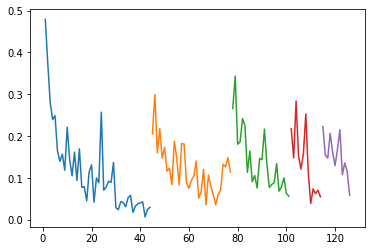

In [26]:
loss_plot(ewc_total_loss_dropout_earlystopping)

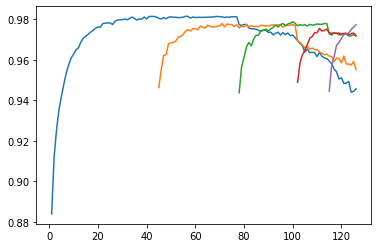

In [27]:
accuracy_plot(ewc_prec_dropout_earlystopping)

In [28]:
#dropout, early stopping, wider layers
lr = 1.e-2 #potentiallly lower?
hidden_size1 = 1600
hidden_size2 = 1200
task_number = 10
epochs_per_task = 75
train_loader, valid_loader, test_loader = get_permute_mnist(task_number, True)

In [29]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_optimised)

# run the standard experiment.
consolidate = False
(standard_prec_optimised,
 standard_total_loss_optimised,
 standard_ce_loss_optimised, 
 standard_ewc_loss_optimised) =train(
    mlp_optimised, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.6719 | loss => ce: 1.714 / ewc: 0.0 / total: 1.714: : 375it [00:14, 25.42it/s]


Validation loss decreased (inf --> 1.635450).  Saving model ...


=> task: 1/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.7656 | loss => ce: 0.7933 / ewc: 0.0 / total: 0.7933: : 375it [00:15, 24.77it/s]


Validation loss decreased (1.635450 --> 0.724468).  Saving model ...


=> task: 1/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.5768 / ewc: 0.0 / total: 0.5768: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.724468 --> 0.507211).  Saving model ...


=> task: 1/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8203 | loss => ce: 0.7135 / ewc: 0.0 / total: 0.7135: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.507211 --> 0.424146).  Saving model ...


=> task: 1/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3705 / ewc: 0.0 / total: 0.3705: : 375it [00:15, 24.81it/s] 


Validation loss decreased (0.424146 --> 0.378225).  Saving model ...


=> task: 1/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3973 / ewc: 0.0 / total: 0.3973: : 375it [00:14, 25.01it/s] 


Validation loss decreased (0.378225 --> 0.348952).  Saving model ...


=> task: 1/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.5026 / ewc: 0.0 / total: 0.5026: : 375it [00:15, 24.74it/s]


Validation loss decreased (0.348952 --> 0.327721).  Saving model ...


=> task: 1/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3843 / ewc: 0.0 / total: 0.3843: : 375it [00:15, 24.70it/s] 


Validation loss decreased (0.327721 --> 0.314029).  Saving model ...


=> task: 1/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.5326 / ewc: 0.0 / total: 0.5326: : 375it [00:15, 24.67it/s]


Validation loss decreased (0.314029 --> 0.296998).  Saving model ...


=> task: 1/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.312 / ewc: 0.0 / total: 0.312: : 375it [00:15, 24.68it/s]  


Validation loss decreased (0.296998 --> 0.285687).  Saving model ...


=> task: 1/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3643 / ewc: 0.0 / total: 0.3643: : 375it [00:15, 24.81it/s] 


Validation loss decreased (0.285687 --> 0.276269).  Saving model ...


=> task: 1/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3056 / ewc: 0.0 / total: 0.3056: : 375it [00:15, 24.69it/s]


Validation loss decreased (0.276269 --> 0.264988).  Saving model ...


=> task: 1/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2032 / ewc: 0.0 / total: 0.2032: : 375it [00:15, 24.71it/s]


Validation loss decreased (0.264988 --> 0.256220).  Saving model ...


=> task: 1/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2112 / ewc: 0.0 / total: 0.2112: : 375it [00:15, 24.79it/s]


Validation loss decreased (0.256220 --> 0.248639).  Saving model ...


=> task: 1/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4785 / ewc: 0.0 / total: 0.4785: : 375it [00:15, 24.68it/s]


Validation loss decreased (0.248639 --> 0.240384).  Saving model ...


=> task: 1/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2793 / ewc: 0.0 / total: 0.2793: : 375it [00:15, 24.68it/s] 


Validation loss decreased (0.240384 --> 0.234238).  Saving model ...


=> task: 1/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2837 / ewc: 0.0 / total: 0.2837: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.234238 --> 0.226616).  Saving model ...


=> task: 1/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2274 / ewc: 0.0 / total: 0.2274: : 375it [00:15, 24.91it/s]


Validation loss decreased (0.226616 --> 0.221042).  Saving model ...


=> task: 1/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3027 / ewc: 0.0 / total: 0.3027: : 375it [00:15, 24.69it/s]


Validation loss decreased (0.221042 --> 0.214644).  Saving model ...


=> task: 1/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2457 / ewc: 0.0 / total: 0.2457: : 375it [00:14, 25.01it/s]


Validation loss decreased (0.214644 --> 0.209100).  Saving model ...


=> task: 1/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3021 / ewc: 0.0 / total: 0.3021: : 375it [00:15, 24.78it/s]


Validation loss decreased (0.209100 --> 0.204088).  Saving model ...


=> task: 1/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2111 / ewc: 0.0 / total: 0.2111: : 375it [00:15, 24.65it/s] 


Validation loss decreased (0.204088 --> 0.198480).  Saving model ...


=> task: 1/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2169 / ewc: 0.0 / total: 0.2169: : 375it [00:14, 25.07it/s] 


Validation loss decreased (0.198480 --> 0.194222).  Saving model ...


=> task: 1/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.241 / ewc: 0.0 / total: 0.241: : 375it [00:15, 24.64it/s]   


Validation loss decreased (0.194222 --> 0.189944).  Saving model ...


=> task: 1/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2195 / ewc: 0.0 / total: 0.2195: : 375it [00:15, 24.77it/s] 


Validation loss decreased (0.189944 --> 0.184170).  Saving model ...


=> task: 1/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1894 / ewc: 0.0 / total: 0.1894: : 375it [00:15, 24.68it/s] 


Validation loss decreased (0.184170 --> 0.180851).  Saving model ...


=> task: 1/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1142 / ewc: 0.0 / total: 0.1142: : 375it [00:15, 24.88it/s] 


Validation loss decreased (0.180851 --> 0.176729).  Saving model ...


=> task: 1/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1695 / ewc: 0.0 / total: 0.1695: : 375it [00:15, 24.73it/s] 


Validation loss decreased (0.176729 --> 0.172887).  Saving model ...


=> task: 1/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1975 / ewc: 0.0 / total: 0.1975: : 375it [00:15, 24.61it/s] 


Validation loss decreased (0.172887 --> 0.169945).  Saving model ...


=> task: 1/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1562 / ewc: 0.0 / total: 0.1562: : 375it [00:15, 24.72it/s] 


Validation loss decreased (0.169945 --> 0.165841).  Saving model ...


=> task: 1/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2043 / ewc: 0.0 / total: 0.2043: : 375it [00:15, 24.73it/s] 


Validation loss decreased (0.165841 --> 0.163781).  Saving model ...


=> task: 1/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1778 / ewc: 0.0 / total: 0.1778: : 375it [00:15, 24.73it/s]  


Validation loss decreased (0.163781 --> 0.160152).  Saving model ...


=> task: 1/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1108 / ewc: 0.0 / total: 0.1108: : 375it [00:15, 24.68it/s] 


Validation loss decreased (0.160152 --> 0.156733).  Saving model ...


=> task: 1/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09965 / ewc: 0.0 / total: 0.09965: : 375it [00:15, 24.71it/s]


Validation loss decreased (0.156733 --> 0.154454).  Saving model ...


=> task: 1/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1089 / ewc: 0.0 / total: 0.1089: : 375it [00:15, 24.67it/s]  


Validation loss decreased (0.154454 --> 0.151302).  Saving model ...


=> task: 1/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09179 / ewc: 0.0 / total: 0.09179: : 375it [00:15, 24.78it/s]


Validation loss decreased (0.151302 --> 0.147976).  Saving model ...


=> task: 1/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1471 / ewc: 0.0 / total: 0.1471: : 375it [00:15, 24.73it/s] 


Validation loss decreased (0.147976 --> 0.146603).  Saving model ...


=> task: 1/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2547 / ewc: 0.0 / total: 0.2547: : 375it [00:15, 24.62it/s] 


Validation loss decreased (0.146603 --> 0.143505).  Saving model ...


=> task: 1/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05726 / ewc: 0.0 / total: 0.05726: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.143505 --> 0.141136).  Saving model ...


=> task: 1/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09365 / ewc: 0.0 / total: 0.09365: : 375it [00:15, 24.85it/s]


Validation loss decreased (0.141136 --> 0.139587).  Saving model ...


=> task: 1/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2451 / ewc: 0.0 / total: 0.2451: : 375it [00:15, 24.72it/s] 


Validation loss decreased (0.139587 --> 0.137097).  Saving model ...


=> task: 1/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1054 / ewc: 0.0 / total: 0.1054: : 375it [00:15, 24.98it/s] 


Validation loss decreased (0.137097 --> 0.134119).  Saving model ...


=> task: 1/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1292 / ewc: 0.0 / total: 0.1292: : 375it [00:15, 24.71it/s] 


Validation loss decreased (0.134119 --> 0.133207).  Saving model ...


=> task: 1/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2168 / ewc: 0.0 / total: 0.2168: : 375it [00:15, 24.77it/s] 


Validation loss decreased (0.133207 --> 0.131260).  Saving model ...


=> task: 1/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1168 / ewc: 0.0 / total: 0.1168: : 375it [00:15, 24.80it/s] 


Validation loss decreased (0.131260 --> 0.129659).  Saving model ...


=> task: 1/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1464 / ewc: 0.0 / total: 0.1464: : 375it [00:15, 24.67it/s]  


Validation loss decreased (0.129659 --> 0.127688).  Saving model ...


=> task: 1/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.09868 / ewc: 0.0 / total: 0.09868: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.127688 --> 0.125747).  Saving model ...


=> task: 1/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06825 / ewc: 0.0 / total: 0.06825: : 375it [00:15, 24.77it/s]


Validation loss decreased (0.125747 --> 0.124031).  Saving model ...


=> task: 1/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07302 / ewc: 0.0 / total: 0.07302: : 375it [00:15, 24.63it/s]


Validation loss decreased (0.124031 --> 0.121945).  Saving model ...


=> task: 1/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1261 / ewc: 0.0 / total: 0.1261: : 375it [00:15, 23.76it/s]  


Validation loss decreased (0.121945 --> 0.120606).  Saving model ...


=> task: 1/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06908 / ewc: 0.0 / total: 0.06908: : 375it [00:16, 23.26it/s]


Validation loss decreased (0.120606 --> 0.119363).  Saving model ...


=> task: 1/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2082 / ewc: 0.0 / total: 0.2082: : 375it [00:15, 23.52it/s]  


Validation loss decreased (0.119363 --> 0.117515).  Saving model ...


=> task: 1/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07252 / ewc: 0.0 / total: 0.07252: : 375it [00:16, 23.23it/s]


Validation loss decreased (0.117515 --> 0.116315).  Saving model ...


=> task: 1/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06668 / ewc: 0.0 / total: 0.06668: : 375it [00:15, 23.87it/s]


Validation loss decreased (0.116315 --> 0.114712).  Saving model ...


=> task: 1/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0889 / ewc: 0.0 / total: 0.0889: : 375it [00:16, 22.61it/s] 


Validation loss decreased (0.114712 --> 0.113877).  Saving model ...


=> task: 1/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09265 / ewc: 0.0 / total: 0.09265: : 375it [00:15, 23.73it/s]


Validation loss decreased (0.113877 --> 0.112479).  Saving model ...


=> task: 1/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03419 / ewc: 0.0 / total: 0.03419: : 375it [00:16, 23.39it/s]


Validation loss decreased (0.112479 --> 0.110729).  Saving model ...


=> task: 1/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.06739 / ewc: 0.0 / total: 0.06739: : 375it [00:16, 23.12it/s]   


Validation loss decreased (0.110729 --> 0.109640).  Saving model ...


=> task: 1/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07772 / ewc: 0.0 / total: 0.07772: : 375it [00:15, 23.52it/s]


Validation loss decreased (0.109640 --> 0.108304).  Saving model ...


=> task: 1/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09962 / ewc: 0.0 / total: 0.09962: : 375it [00:16, 23.30it/s]


Validation loss decreased (0.108304 --> 0.107753).  Saving model ...


=> task: 1/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09733 / ewc: 0.0 / total: 0.09733: : 375it [00:16, 23.20it/s]


Validation loss decreased (0.107753 --> 0.106432).  Saving model ...


=> task: 1/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08036 / ewc: 0.0 / total: 0.08036: : 375it [00:15, 24.49it/s]


Validation loss decreased (0.106432 --> 0.105047).  Saving model ...


=> task: 1/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08697 / ewc: 0.0 / total: 0.08697: : 375it [00:15, 24.43it/s]


Validation loss decreased (0.105047 --> 0.104727).  Saving model ...


=> task: 1/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2509 / ewc: 0.0 / total: 0.2509: : 375it [00:15, 24.46it/s]  


Validation loss decreased (0.104727 --> 0.103731).  Saving model ...


=> task: 1/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.08337 / ewc: 0.0 / total: 0.08337: : 375it [00:15, 24.49it/s]


Validation loss decreased (0.103731 --> 0.102889).  Saving model ...


=> task: 1/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.116 / ewc: 0.0 / total: 0.116: : 375it [00:15, 24.49it/s]   


Validation loss decreased (0.102889 --> 0.102187).  Saving model ...


=> task: 1/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04219 / ewc: 0.0 / total: 0.04219: : 375it [00:15, 24.42it/s]


Validation loss decreased (0.102187 --> 0.100637).  Saving model ...


=> task: 1/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1298 / ewc: 0.0 / total: 0.1298: : 375it [00:15, 24.61it/s]  


Validation loss decreased (0.100637 --> 0.099457).  Saving model ...


=> task: 1/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09984 / ewc: 0.0 / total: 0.09984: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.099457 --> 0.098508).  Saving model ...


=> task: 1/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06751 / ewc: 0.0 / total: 0.06751: : 375it [00:15, 24.49it/s]


Validation loss decreased (0.098508 --> 0.097806).  Saving model ...


=> task: 1/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1147 / ewc: 0.0 / total: 0.1147: : 375it [00:15, 24.64it/s]  


Validation loss decreased (0.097806 --> 0.096347).  Saving model ...


=> task: 1/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1228 / ewc: 0.0 / total: 0.1228: : 375it [00:15, 24.50it/s] 


Validation loss decreased (0.096347 --> 0.096089).  Saving model ...


=> task: 1/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08664 / ewc: 0.0 / total: 0.08664: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.096089 --> 0.095910).  Saving model ...


=> task: 1/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09459 / ewc: 0.0 / total: 0.09459: : 375it [00:15, 24.72it/s]


Validation loss decreased (0.095910 --> 0.094043).  Saving model ...


=> task: 1/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1327 / ewc: 0.0 / total: 0.1327: : 375it [00:15, 24.54it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.482 / ewc: 0.0 / total: 0.482: : 375it [00:15, 24.12it/s]  


Validation loss decreased (inf --> 0.218334).  Saving model ...


=> task: 2/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2464 / ewc: 0.0 / total: 0.2464: : 375it [00:15, 24.67it/s]


Validation loss decreased (0.218334 --> 0.186839).  Saving model ...


=> task: 2/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.241 / ewc: 0.0 / total: 0.241: : 375it [00:15, 24.75it/s]  


Validation loss decreased (0.186839 --> 0.172930).  Saving model ...


=> task: 2/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2677 / ewc: 0.0 / total: 0.2677: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.172930 --> 0.161204).  Saving model ...


=> task: 2/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1854 / ewc: 0.0 / total: 0.1854: : 375it [00:15, 24.56it/s] 


Validation loss decreased (0.161204 --> 0.152678).  Saving model ...


=> task: 2/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1707 / ewc: 0.0 / total: 0.1707: : 375it [00:14, 26.66it/s] 


Validation loss decreased (0.152678 --> 0.146455).  Saving model ...


=> task: 2/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1434 / ewc: 0.0 / total: 0.1434: : 375it [00:14, 25.95it/s] 


Validation loss decreased (0.146455 --> 0.141578).  Saving model ...


=> task: 2/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.265 / ewc: 0.0 / total: 0.265: : 375it [00:14, 25.27it/s]   


Validation loss decreased (0.141578 --> 0.137430).  Saving model ...


=> task: 2/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1595 / ewc: 0.0 / total: 0.1595: : 375it [00:15, 24.77it/s] 


Validation loss decreased (0.137430 --> 0.133281).  Saving model ...


=> task: 2/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2454 / ewc: 0.0 / total: 0.2454: : 375it [00:15, 24.39it/s] 


Validation loss decreased (0.133281 --> 0.130842).  Saving model ...


=> task: 2/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1912 / ewc: 0.0 / total: 0.1912: : 375it [00:15, 24.53it/s] 


Validation loss decreased (0.130842 --> 0.127593).  Saving model ...


=> task: 2/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2789 / ewc: 0.0 / total: 0.2789: : 375it [00:15, 24.54it/s]  


Validation loss decreased (0.127593 --> 0.124972).  Saving model ...


=> task: 2/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1743 / ewc: 0.0 / total: 0.1743: : 375it [00:15, 24.59it/s] 


Validation loss decreased (0.124972 --> 0.123231).  Saving model ...


=> task: 2/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06584 / ewc: 0.0 / total: 0.06584: : 375it [00:15, 24.64it/s]


Validation loss decreased (0.123231 --> 0.120641).  Saving model ...


=> task: 2/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1049 / ewc: 0.0 / total: 0.1049: : 375it [00:15, 24.69it/s] 


Validation loss decreased (0.120641 --> 0.119388).  Saving model ...


=> task: 2/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07278 / ewc: 0.0 / total: 0.07278: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.119388 --> 0.117250).  Saving model ...


=> task: 2/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1421 / ewc: 0.0 / total: 0.1421: : 375it [00:15, 24.50it/s] 


Validation loss decreased (0.117250 --> 0.115339).  Saving model ...


=> task: 2/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09216 / ewc: 0.0 / total: 0.09216: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.115339 --> 0.114679).  Saving model ...


=> task: 2/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1498 / ewc: 0.0 / total: 0.1498: : 375it [00:15, 24.55it/s]  


Validation loss decreased (0.114679 --> 0.113207).  Saving model ...


=> task: 2/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1312 / ewc: 0.0 / total: 0.1312: : 375it [00:15, 24.59it/s] 


Validation loss decreased (0.113207 --> 0.112377).  Saving model ...


=> task: 2/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0619 / ewc: 0.0 / total: 0.0619: : 375it [00:15, 24.60it/s]  


Validation loss decreased (0.112377 --> 0.111158).  Saving model ...


=> task: 2/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1054 / ewc: 0.0 / total: 0.1054: : 375it [00:15, 24.50it/s] 


Validation loss decreased (0.111158 --> 0.110064).  Saving model ...


=> task: 2/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0804 / ewc: 0.0 / total: 0.0804: : 375it [00:14, 25.64it/s]  


Validation loss decreased (0.110064 --> 0.109288).  Saving model ...


=> task: 2/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06898 / ewc: 0.0 / total: 0.06898: : 375it [00:15, 24.98it/s]


Validation loss decreased (0.109288 --> 0.108393).  Saving model ...


=> task: 2/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09343 / ewc: 0.0 / total: 0.09343: : 375it [00:14, 25.18it/s]


Validation loss decreased (0.108393 --> 0.107611).  Saving model ...


=> task: 2/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1661 / ewc: 0.0 / total: 0.1661: : 375it [00:15, 24.57it/s] 


Validation loss decreased (0.107611 --> 0.107162).  Saving model ...


=> task: 2/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.05553 / ewc: 0.0 / total: 0.05553: : 375it [00:15, 24.60it/s]


Validation loss decreased (0.107162 --> 0.106370).  Saving model ...


=> task: 2/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06797 / ewc: 0.0 / total: 0.06797: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.106370 --> 0.105550).  Saving model ...


=> task: 2/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.07173 / ewc: 0.0 / total: 0.07173: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.105550 --> 0.104884).  Saving model ...


=> task: 2/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09667 / ewc: 0.0 / total: 0.09667: : 375it [00:15, 24.51it/s]


Validation loss decreased (0.104884 --> 0.104064).  Saving model ...


=> task: 2/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1603 / ewc: 0.0 / total: 0.1603: : 375it [00:15, 24.54it/s]  


Validation loss decreased (0.104064 --> 0.103666).  Saving model ...


=> task: 2/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0792 / ewc: 0.0 / total: 0.0792: : 375it [00:15, 24.51it/s]  


Validation loss decreased (0.103666 --> 0.103111).  Saving model ...


=> task: 2/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.08383 / ewc: 0.0 / total: 0.08383: : 375it [00:15, 24.52it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1156 / ewc: 0.0 / total: 0.1156: : 375it [00:15, 24.63it/s] 


Validation loss decreased (0.103111 --> 0.102478).  Saving model ...


=> task: 2/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0581 / ewc: 0.0 / total: 0.0581: : 375it [00:15, 24.51it/s]  


Validation loss decreased (0.102478 --> 0.101726).  Saving model ...


=> task: 2/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1218 / ewc: 0.0 / total: 0.1218: : 375it [00:15, 24.49it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06429 / ewc: 0.0 / total: 0.06429: : 375it [00:15, 24.63it/s]


Validation loss decreased (0.101726 --> 0.101413).  Saving model ...


=> task: 2/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08136 / ewc: 0.0 / total: 0.08136: : 375it [00:14, 25.47it/s]


Validation loss decreased (0.101413 --> 0.100480).  Saving model ...


=> task: 2/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03382 / ewc: 0.0 / total: 0.03382: : 375it [00:15, 24.44it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08195 / ewc: 0.0 / total: 0.08195: : 375it [00:15, 24.52it/s]


Validation loss decreased (0.100480 --> 0.100273).  Saving model ...


=> task: 2/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1367 / ewc: 0.0 / total: 0.1367: : 375it [00:15, 24.55it/s]  


Validation loss decreased (0.100273 --> 0.099839).  Saving model ...


=> task: 2/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07385 / ewc: 0.0 / total: 0.07385: : 375it [00:15, 24.55it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07234 / ewc: 0.0 / total: 0.07234: : 375it [00:14, 25.82it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.04422 / ewc: 0.0 / total: 0.04422: : 375it [00:15, 24.59it/s]   


Validation loss decreased (0.099839 --> 0.099302).  Saving model ...


=> task: 2/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04098 / ewc: 0.0 / total: 0.04098: : 375it [00:15, 24.50it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07817 / ewc: 0.0 / total: 0.07817: : 375it [00:15, 24.69it/s]


Validation loss decreased (0.099302 --> 0.098788).  Saving model ...


=> task: 2/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06234 / ewc: 0.0 / total: 0.06234: : 375it [00:15, 24.55it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0415 / ewc: 0.0 / total: 0.0415: : 375it [00:15, 24.54it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08674 / ewc: 0.0 / total: 0.08674: : 375it [00:15, 24.54it/s]


Validation loss decreased (0.098788 --> 0.098750).  Saving model ...


=> task: 2/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06214 / ewc: 0.0 / total: 0.06214: : 375it [00:15, 24.53it/s]


Validation loss decreased (0.098750 --> 0.098353).  Saving model ...


=> task: 2/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05633 / ewc: 0.0 / total: 0.05633: : 375it [00:15, 24.57it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07215 / ewc: 0.0 / total: 0.07215: : 375it [00:15, 24.95it/s]


Validation loss decreased (0.098353 --> 0.097996).  Saving model ...


=> task: 2/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06791 / ewc: 0.0 / total: 0.06791: : 375it [00:15, 24.52it/s]


Validation loss decreased (0.097996 --> 0.097987).  Saving model ...


=> task: 2/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05431 / ewc: 0.0 / total: 0.05431: : 375it [00:15, 24.53it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02125 / ewc: 0.0 / total: 0.02125: : 375it [00:15, 24.61it/s]


Validation loss decreased (0.097987 --> 0.097772).  Saving model ...


=> task: 2/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0391 / ewc: 0.0 / total: 0.0391: : 375it [00:15, 24.64it/s] 


Validation loss decreased (0.097772 --> 0.097551).  Saving model ...


=> task: 2/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04277 / ewc: 0.0 / total: 0.04277: : 375it [00:15, 24.64it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1496 / ewc: 0.0 / total: 0.1496: : 375it [00:14, 26.23it/s]  


Validation loss decreased (0.097551 --> 0.097472).  Saving model ...


=> task: 2/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01478 / ewc: 0.0 / total: 0.01478: : 375it [00:15, 24.47it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03929 / ewc: 0.0 / total: 0.03929: : 375it [00:15, 24.59it/s]


Validation loss decreased (0.097472 --> 0.097422).  Saving model ...


=> task: 2/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.05752 / ewc: 0.0 / total: 0.05752: : 375it [00:14, 26.56it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.02811 / ewc: 0.0 / total: 0.02811: : 375it [00:15, 24.51it/s]


Validation loss decreased (0.097422 --> 0.096996).  Saving model ...


=> task: 2/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0462 / ewc: 0.0 / total: 0.0462: : 375it [00:14, 25.28it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.01626 / ewc: 0.0 / total: 0.01626: : 375it [00:15, 24.60it/s]   


Validation loss decreased (0.096996 --> 0.096940).  Saving model ...


=> task: 2/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.06758 / ewc: 0.0 / total: 0.06758: : 375it [00:15, 24.58it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03576 / ewc: 0.0 / total: 0.03576: : 375it [00:15, 24.53it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04441 / ewc: 0.0 / total: 0.04441: : 375it [00:15, 24.62it/s]


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.02432 / ewc: 0.0 / total: 0.02432: : 375it [00:15, 24.52it/s]  


Validation loss decreased (0.096940 --> 0.096891).  Saving model ...


=> task: 2/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05338 / ewc: 0.0 / total: 0.05338: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.096891 --> 0.096596).  Saving model ...


=> task: 2/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.04941 / ewc: 0.0 / total: 0.04941: : 375it [00:15, 24.84it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03302 / ewc: 0.0 / total: 0.03302: : 375it [00:15, 24.50it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07659 / ewc: 0.0 / total: 0.07659: : 375it [00:15, 24.48it/s]


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04592 / ewc: 0.0 / total: 0.04592: : 375it [00:15, 24.61it/s]


EarlyStopping counter: 4 out of 5


=> task: 2/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0347 / ewc: 0.0 / total: 0.0347: : 375it [00:15, 24.60it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 3/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2868 / ewc: 0.0 / total: 0.2868: : 375it [00:15, 23.63it/s]


Validation loss decreased (inf --> 0.164739).  Saving model ...


=> task: 3/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3308 / ewc: 0.0 / total: 0.3308: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.164739 --> 0.149505).  Saving model ...


=> task: 3/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1704 / ewc: 0.0 / total: 0.1704: : 375it [00:15, 24.54it/s] 


Validation loss decreased (0.149505 --> 0.142737).  Saving model ...


=> task: 3/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1818 / ewc: 0.0 / total: 0.1818: : 375it [00:15, 24.58it/s] 


Validation loss decreased (0.142737 --> 0.136082).  Saving model ...


=> task: 3/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1774 / ewc: 0.0 / total: 0.1774: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.136082 --> 0.132932).  Saving model ...


=> task: 3/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1711 / ewc: 0.0 / total: 0.1711: : 375it [00:15, 24.59it/s] 


Validation loss decreased (0.132932 --> 0.130776).  Saving model ...


=> task: 3/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09554 / ewc: 0.0 / total: 0.09554: : 375it [00:15, 24.54it/s]


Validation loss decreased (0.130776 --> 0.129910).  Saving model ...


=> task: 3/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1391 / ewc: 0.0 / total: 0.1391: : 375it [00:15, 24.60it/s] 


Validation loss decreased (0.129910 --> 0.126800).  Saving model ...


=> task: 3/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1399 / ewc: 0.0 / total: 0.1399: : 375it [00:15, 24.61it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1006 / ewc: 0.0 / total: 0.1006: : 375it [00:15, 24.59it/s] 


Validation loss decreased (0.126800 --> 0.126433).  Saving model ...


=> task: 3/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2028 / ewc: 0.0 / total: 0.2028: : 375it [00:15, 24.52it/s] 


Validation loss decreased (0.126433 --> 0.125402).  Saving model ...


=> task: 3/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09281 / ewc: 0.0 / total: 0.09281: : 375it [00:15, 24.88it/s]


Validation loss decreased (0.125402 --> 0.123697).  Saving model ...


=> task: 3/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06328 / ewc: 0.0 / total: 0.06328: : 375it [00:15, 24.50it/s]


Validation loss decreased (0.123697 --> 0.121393).  Saving model ...


=> task: 3/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1205 / ewc: 0.0 / total: 0.1205: : 375it [00:15, 24.46it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05094 / ewc: 0.0 / total: 0.05094: : 375it [00:15, 24.50it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08942 / ewc: 0.0 / total: 0.08942: : 375it [00:15, 24.49it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06651 / ewc: 0.0 / total: 0.06651: : 375it [00:15, 24.59it/s]


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09612 / ewc: 0.0 / total: 0.09612: : 375it [00:15, 24.65it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 4/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2535 / ewc: 0.0 / total: 0.2535: : 375it [00:16, 23.43it/s]


Validation loss decreased (inf --> 0.173323).  Saving model ...


=> task: 4/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.169 / ewc: 0.0 / total: 0.169: : 375it [00:15, 24.55it/s]  


Validation loss decreased (0.173323 --> 0.163960).  Saving model ...


=> task: 4/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1924 / ewc: 0.0 / total: 0.1924: : 375it [00:14, 25.51it/s] 


Validation loss decreased (0.163960 --> 0.157232).  Saving model ...


=> task: 4/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1825 / ewc: 0.0 / total: 0.1825: : 375it [00:15, 24.54it/s] 


Validation loss decreased (0.157232 --> 0.154091).  Saving model ...


=> task: 4/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 375it [00:15, 24.60it/s] 


Validation loss decreased (0.154091 --> 0.150049).  Saving model ...


=> task: 4/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1737 / ewc: 0.0 / total: 0.1737: : 375it [00:15, 24.68it/s] 


Validation loss decreased (0.150049 --> 0.148692).  Saving model ...


=> task: 4/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1822 / ewc: 0.0 / total: 0.1822: : 375it [00:15, 24.61it/s] 


Validation loss decreased (0.148692 --> 0.146978).  Saving model ...


=> task: 4/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1453 / ewc: 0.0 / total: 0.1453: : 375it [00:15, 24.61it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07012 / ewc: 0.0 / total: 0.07012: : 375it [00:14, 25.45it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07392 / ewc: 0.0 / total: 0.07392: : 375it [00:15, 24.51it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.117 / ewc: 0.0 / total: 0.117: : 375it [00:15, 24.49it/s]    


Validation loss decreased (0.146978 --> 0.146742).  Saving model ...


=> task: 4/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1476 / ewc: 0.0 / total: 0.1476: : 375it [00:15, 24.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.101 / ewc: 0.0 / total: 0.101: : 375it [00:15, 24.50it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.05391 / ewc: 0.0 / total: 0.05391: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.146742 --> 0.144923).  Saving model ...


=> task: 4/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1199 / ewc: 0.0 / total: 0.1199: : 375it [00:15, 24.55it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06326 / ewc: 0.0 / total: 0.06326: : 375it [00:15, 24.65it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07616 / ewc: 0.0 / total: 0.07616: : 375it [00:15, 24.48it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09328 / ewc: 0.0 / total: 0.09328: : 375it [00:15, 24.58it/s]


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08589 / ewc: 0.0 / total: 0.08589: : 375it [00:15, 24.51it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 5/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2726 / ewc: 0.0 / total: 0.2726: : 375it [00:15, 23.51it/s]


Validation loss decreased (inf --> 0.183929).  Saving model ...


=> task: 5/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1765 / ewc: 0.0 / total: 0.1765: : 375it [00:15, 24.52it/s]


Validation loss decreased (0.183929 --> 0.172651).  Saving model ...


=> task: 5/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2101 / ewc: 0.0 / total: 0.2101: : 375it [00:15, 24.57it/s] 


Validation loss decreased (0.172651 --> 0.170052).  Saving model ...


=> task: 5/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2376 / ewc: 0.0 / total: 0.2376: : 375it [00:14, 25.02it/s] 


Validation loss decreased (0.170052 --> 0.167945).  Saving model ...


=> task: 5/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1738 / ewc: 0.0 / total: 0.1738: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.167945 --> 0.164922).  Saving model ...


=> task: 5/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.109 / ewc: 0.0 / total: 0.109: : 375it [00:15, 24.51it/s]   


Validation loss decreased (0.164922 --> 0.164159).  Saving model ...


=> task: 5/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1665 / ewc: 0.0 / total: 0.1665: : 375it [00:15, 24.51it/s] 


Validation loss decreased (0.164159 --> 0.163535).  Saving model ...


=> task: 5/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1444 / ewc: 0.0 / total: 0.1444: : 375it [00:15, 24.73it/s] 


Validation loss decreased (0.163535 --> 0.161186).  Saving model ...


=> task: 5/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09519 / ewc: 0.0 / total: 0.09519: : 375it [00:15, 24.65it/s]


Validation loss decreased (0.161186 --> 0.159842).  Saving model ...


=> task: 5/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.09659 / ewc: 0.0 / total: 0.09659: : 375it [00:15, 24.60it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06381 / ewc: 0.0 / total: 0.06381: : 375it [00:15, 24.59it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05557 / ewc: 0.0 / total: 0.05557: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.159842 --> 0.159485).  Saving model ...


=> task: 5/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08457 / ewc: 0.0 / total: 0.08457: : 375it [00:15, 24.57it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06314 / ewc: 0.0 / total: 0.06314: : 375it [00:15, 24.63it/s]


Validation loss decreased (0.159485 --> 0.158935).  Saving model ...


=> task: 5/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1427 / ewc: 0.0 / total: 0.1427: : 375it [00:15, 24.58it/s]  


Validation loss decreased (0.158935 --> 0.157962).  Saving model ...


=> task: 5/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09271 / ewc: 0.0 / total: 0.09271: : 375it [00:14, 25.83it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08851 / ewc: 0.0 / total: 0.08851: : 375it [00:14, 25.24it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05422 / ewc: 0.0 / total: 0.05422: : 375it [00:14, 25.80it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09868 / ewc: 0.0 / total: 0.09868: : 375it [00:15, 24.58it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07541 / ewc: 0.0 / total: 0.07541: : 375it [00:15, 24.58it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 6/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3992 / ewc: 0.0 / total: 0.3992: : 375it [00:15, 23.65it/s] 


Validation loss decreased (inf --> 0.194158).  Saving model ...


=> task: 6/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1894 / ewc: 0.0 / total: 0.1894: : 375it [00:15, 24.64it/s] 


Validation loss decreased (0.194158 --> 0.184556).  Saving model ...


=> task: 6/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1728 / ewc: 0.0 / total: 0.1728: : 375it [00:15, 24.54it/s] 


Validation loss decreased (0.184556 --> 0.179768).  Saving model ...


=> task: 6/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1299 / ewc: 0.0 / total: 0.1299: : 375it [00:14, 26.14it/s] 


Validation loss decreased (0.179768 --> 0.176855).  Saving model ...


=> task: 6/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1844 / ewc: 0.0 / total: 0.1844: : 375it [00:15, 24.53it/s] 


Validation loss decreased (0.176855 --> 0.175942).  Saving model ...


=> task: 6/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1741 / ewc: 0.0 / total: 0.1741: : 375it [00:15, 24.51it/s]  


Validation loss decreased (0.175942 --> 0.173909).  Saving model ...


=> task: 6/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2308 / ewc: 0.0 / total: 0.2308: : 375it [00:15, 24.49it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1095 / ewc: 0.0 / total: 0.1095: : 375it [00:15, 24.75it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08579 / ewc: 0.0 / total: 0.08579: : 375it [00:15, 24.84it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1138 / ewc: 0.0 / total: 0.1138: : 375it [00:15, 23.95it/s] 


Validation loss decreased (0.173909 --> 0.172506).  Saving model ...


=> task: 6/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0905 / ewc: 0.0 / total: 0.0905: : 375it [00:23, 16.01it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07511 / ewc: 0.0 / total: 0.07511: : 375it [00:16, 23.28it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09965 / ewc: 0.0 / total: 0.09965: : 375it [00:15, 24.23it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05972 / ewc: 0.0 / total: 0.05972: : 375it [00:15, 24.42it/s]


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1012 / ewc: 0.0 / total: 0.1012: : 375it [00:15, 24.36it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 7/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2572 / ewc: 0.0 / total: 0.2572: : 375it [00:15, 23.76it/s]


Validation loss decreased (inf --> 0.215602).  Saving model ...


=> task: 7/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2811 / ewc: 0.0 / total: 0.2811: : 375it [00:15, 24.28it/s] 


Validation loss decreased (0.215602 --> 0.206292).  Saving model ...


=> task: 7/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1711 / ewc: 0.0 / total: 0.1711: : 375it [00:15, 24.31it/s] 


Validation loss decreased (0.206292 --> 0.204184).  Saving model ...


=> task: 7/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1092 / ewc: 0.0 / total: 0.1092: : 375it [00:15, 24.45it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1892 / ewc: 0.0 / total: 0.1892: : 375it [00:15, 24.92it/s] 


Validation loss decreased (0.204184 --> 0.202751).  Saving model ...


=> task: 7/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09236 / ewc: 0.0 / total: 0.09236: : 375it [00:15, 24.43it/s]


Validation loss decreased (0.202751 --> 0.201097).  Saving model ...


=> task: 7/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2272 / ewc: 0.0 / total: 0.2272: : 375it [00:15, 24.58it/s] 


Validation loss decreased (0.201097 --> 0.200611).  Saving model ...


=> task: 7/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1357 / ewc: 0.0 / total: 0.1357: : 375it [00:15, 24.72it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07073 / ewc: 0.0 / total: 0.07073: : 375it [00:15, 24.65it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1493 / ewc: 0.0 / total: 0.1493: : 375it [00:15, 24.53it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09452 / ewc: 0.0 / total: 0.09452: : 375it [00:15, 24.47it/s]


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09055 / ewc: 0.0 / total: 0.09055: : 375it [00:15, 24.53it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 8/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3263 / ewc: 0.0 / total: 0.3263: : 375it [00:15, 23.63it/s]


Validation loss decreased (inf --> 0.206030).  Saving model ...


=> task: 8/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1736 / ewc: 0.0 / total: 0.1736: : 375it [00:14, 25.38it/s]


Validation loss decreased (0.206030 --> 0.203216).  Saving model ...


=> task: 8/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1148 / ewc: 0.0 / total: 0.1148: : 375it [00:15, 24.54it/s] 


Validation loss decreased (0.203216 --> 0.201189).  Saving model ...


=> task: 8/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2563 / ewc: 0.0 / total: 0.2563: : 375it [00:15, 24.56it/s] 


Validation loss decreased (0.201189 --> 0.200697).  Saving model ...


=> task: 8/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09257 / ewc: 0.0 / total: 0.09257: : 375it [00:15, 24.51it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1376 / ewc: 0.0 / total: 0.1376: : 375it [00:15, 24.67it/s]  


Validation loss decreased (0.200697 --> 0.199645).  Saving model ...


=> task: 8/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1728 / ewc: 0.0 / total: 0.1728: : 375it [00:15, 24.41it/s] 


Validation loss decreased (0.199645 --> 0.198283).  Saving model ...


=> task: 8/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08908 / ewc: 0.0 / total: 0.08908: : 375it [00:15, 24.55it/s]


Validation loss decreased (0.198283 --> 0.197955).  Saving model ...


=> task: 8/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1138 / ewc: 0.0 / total: 0.1138: : 375it [00:15, 24.42it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1518 / ewc: 0.0 / total: 0.1518: : 375it [00:15, 24.59it/s]  


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06959 / ewc: 0.0 / total: 0.06959: : 375it [00:15, 24.53it/s]


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.0815 / ewc: 0.0 / total: 0.0815: : 375it [00:15, 24.50it/s] 


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1001 / ewc: 0.0 / total: 0.1001: : 375it [00:15, 23.80it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 9/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3913 / ewc: 0.0 / total: 0.3913: : 375it [00:16, 22.41it/s] 


Validation loss decreased (inf --> 0.226146).  Saving model ...


=> task: 9/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2135 / ewc: 0.0 / total: 0.2135: : 375it [00:15, 23.47it/s]


Validation loss decreased (0.226146 --> 0.225571).  Saving model ...


=> task: 9/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1182 / ewc: 0.0 / total: 0.1182: : 375it [00:15, 24.31it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1151 / ewc: 0.0 / total: 0.1151: : 375it [00:15, 24.28it/s] 


Validation loss decreased (0.225571 --> 0.225361).  Saving model ...


=> task: 9/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1333 / ewc: 0.0 / total: 0.1333: : 375it [00:14, 26.37it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1088 / ewc: 0.0 / total: 0.1088: : 375it [00:16, 23.41it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1158 / ewc: 0.0 / total: 0.1158: : 375it [00:15, 24.16it/s] 


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1513 / ewc: 0.0 / total: 0.1513: : 375it [00:15, 24.41it/s] 


Validation loss decreased (0.225361 --> 0.222977).  Saving model ...


=> task: 9/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.13 / ewc: 0.0 / total: 0.13: : 375it [00:15, 24.14it/s]      


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1614 / ewc: 0.0 / total: 0.1614: : 375it [00:15, 24.23it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09651 / ewc: 0.0 / total: 0.09651: : 375it [00:15, 24.39it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09087 / ewc: 0.0 / total: 0.09087: : 375it [00:15, 24.61it/s]


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1126 / ewc: 0.0 / total: 0.1126: : 375it [00:15, 24.48it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 10/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2014 / ewc: 0.0 / total: 0.2014: : 375it [00:15, 23.70it/s]


Validation loss decreased (inf --> 0.270588).  Saving model ...


=> task: 10/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1659 / ewc: 0.0 / total: 0.1659: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.270588 --> 0.266630).  Saving model ...


=> task: 10/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1811 / ewc: 0.0 / total: 0.1811: : 375it [00:15, 24.55it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1641 / ewc: 0.0 / total: 0.1641: : 375it [00:14, 25.52it/s]  


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1445 / ewc: 0.0 / total: 0.1445: : 375it [00:15, 24.95it/s] 


Validation loss decreased (0.266630 --> 0.265718).  Saving model ...


=> task: 10/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08518 / ewc: 0.0 / total: 0.08518: : 375it [00:15, 24.51it/s]


Validation loss decreased (0.265718 --> 0.264663).  Saving model ...


=> task: 10/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1138 / ewc: 0.0 / total: 0.1138: : 375it [00:15, 24.48it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.0975 / ewc: 0.0 / total: 0.0975: : 375it [00:14, 26.66it/s]  


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0504 / ewc: 0.0 / total: 0.0504: : 375it [00:15, 24.54it/s]  


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09559 / ewc: 0.0 / total: 0.09559: : 375it [00:15, 24.86it/s]


Validation loss decreased (0.264663 --> 0.262570).  Saving model ...


=> task: 10/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.07742 / ewc: 0.0 / total: 0.07742: : 375it [00:15, 24.58it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09077 / ewc: 0.0 / total: 0.09077: : 375it [00:15, 24.51it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05232 / ewc: 0.0 / total: 0.05232: : 375it [00:15, 24.56it/s]


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06595 / ewc: 0.0 / total: 0.06595: : 375it [00:15, 24.40it/s]


Validation loss decreased (0.262570 --> 0.261785).  Saving model ...


=> task: 10/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09079 / ewc: 0.0 / total: 0.09079: : 375it [00:15, 24.44it/s]


Validation loss decreased (0.261785 --> 0.260376).  Saving model ...


=> task: 10/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.163 / ewc: 0.0 / total: 0.163: : 375it [00:15, 24.58it/s]    


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06674 / ewc: 0.0 / total: 0.06674: : 375it [00:15, 24.86it/s]


Validation loss decreased (0.260376 --> 0.259947).  Saving model ...


=> task: 10/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.07254 / ewc: 0.0 / total: 0.07254: : 375it [00:15, 24.64it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04725 / ewc: 0.0 / total: 0.04725: : 375it [00:15, 24.46it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04683 / ewc: 0.0 / total: 0.04683: : 375it [00:15, 24.51it/s]


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06257 / ewc: 0.0 / total: 0.06257: : 375it [00:15, 24.61it/s]


Validation loss decreased (0.259947 --> 0.259227).  Saving model ...


=> task: 10/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0375 / ewc: 0.0 / total: 0.0375: : 375it [00:14, 25.32it/s]  


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07355 / ewc: 0.0 / total: 0.07355: : 375it [00:15, 24.56it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03259 / ewc: 0.0 / total: 0.03259: : 375it [00:15, 24.45it/s]


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04844 / ewc: 0.0 / total: 0.04844: : 375it [00:15, 24.49it/s]


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04982 / ewc: 0.0 / total: 0.04982: : 375it [00:15, 24.52it/s]


EarlyStopping counter: 5 out of 5
Early stopping


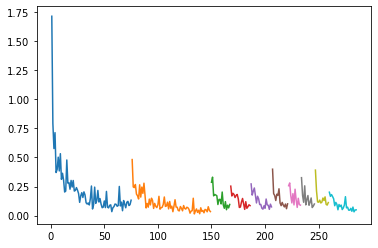

In [30]:
loss_plot(standard_total_loss_optimised)

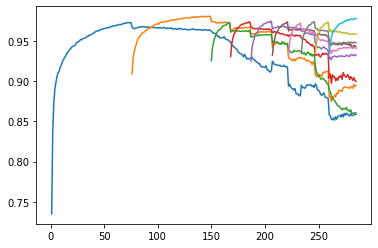

In [31]:
accuracy_plot(standard_prec_optimised)

In [32]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised, 
 ewc_total_loss_optimised,
 ewc_ce_loss_optimised, 
 ewc_ewc_loss_optimised) =train(
    mlp_consolidation_optimised, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.7578 | loss => ce: 1.653 / ewc: 0.0 / total: 1.653: : 375it [00:15, 24.62it/s]


Validation loss decreased (inf --> 1.624958).  Saving model ...


=> task: 1/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.7147 / ewc: 0.0 / total: 0.7147: : 375it [00:15, 24.69it/s]


Validation loss decreased (1.624958 --> 0.727378).  Saving model ...


=> task: 1/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.5309 / ewc: 0.0 / total: 0.5309: : 375it [00:15, 24.56it/s]


Validation loss decreased (0.727378 --> 0.508848).  Saving model ...


=> task: 1/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.51 / ewc: 0.0 / total: 0.51: : 375it [00:15, 24.35it/s]    


Validation loss decreased (0.508848 --> 0.423704).  Saving model ...


=> task: 1/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.5008 / ewc: 0.0 / total: 0.5008: : 375it [00:15, 24.52it/s]


Validation loss decreased (0.423704 --> 0.378985).  Saving model ...


=> task: 1/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.4496 / ewc: 0.0 / total: 0.4496: : 375it [00:14, 26.01it/s]


Validation loss decreased (0.378985 --> 0.350997).  Saving model ...


=> task: 1/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3994 / ewc: 0.0 / total: 0.3994: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.350997 --> 0.329327).  Saving model ...


=> task: 1/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4857 / ewc: 0.0 / total: 0.4857: : 375it [00:15, 24.52it/s]


Validation loss decreased (0.329327 --> 0.313175).  Saving model ...


=> task: 1/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3305 / ewc: 0.0 / total: 0.3305: : 375it [00:15, 24.47it/s]


Validation loss decreased (0.313175 --> 0.299430).  Saving model ...


=> task: 1/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2537 / ewc: 0.0 / total: 0.2537: : 375it [00:15, 24.53it/s]


Validation loss decreased (0.299430 --> 0.288198).  Saving model ...


=> task: 1/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3757 / ewc: 0.0 / total: 0.3757: : 375it [00:15, 24.54it/s]


Validation loss decreased (0.288198 --> 0.278214).  Saving model ...


=> task: 1/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3173 / ewc: 0.0 / total: 0.3173: : 375it [00:15, 24.46it/s]


Validation loss decreased (0.278214 --> 0.268541).  Saving model ...


=> task: 1/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2257 / ewc: 0.0 / total: 0.2257: : 375it [00:15, 24.63it/s]


Validation loss decreased (0.268541 --> 0.260096).  Saving model ...


=> task: 1/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1944 / ewc: 0.0 / total: 0.1944: : 375it [00:15, 24.42it/s]


Validation loss decreased (0.260096 --> 0.250194).  Saving model ...


=> task: 1/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3325 / ewc: 0.0 / total: 0.3325: : 375it [00:15, 24.55it/s]


Validation loss decreased (0.250194 --> 0.243151).  Saving model ...


=> task: 1/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3093 / ewc: 0.0 / total: 0.3093: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.243151 --> 0.234802).  Saving model ...


=> task: 1/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.2976 / ewc: 0.0 / total: 0.2976: : 375it [00:15, 24.43it/s]


Validation loss decreased (0.234802 --> 0.229268).  Saving model ...


=> task: 1/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1822 / ewc: 0.0 / total: 0.1822: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.229268 --> 0.222724).  Saving model ...


=> task: 1/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2845 / ewc: 0.0 / total: 0.2845: : 375it [00:15, 24.70it/s] 


Validation loss decreased (0.222724 --> 0.216338).  Saving model ...


=> task: 1/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1594 / ewc: 0.0 / total: 0.1594: : 375it [00:15, 24.34it/s]


Validation loss decreased (0.216338 --> 0.210352).  Saving model ...


=> task: 1/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2043 / ewc: 0.0 / total: 0.2043: : 375it [00:14, 25.08it/s] 


Validation loss decreased (0.210352 --> 0.203676).  Saving model ...


=> task: 1/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2755 / ewc: 0.0 / total: 0.2755: : 375it [00:15, 24.64it/s]


Validation loss decreased (0.203676 --> 0.199286).  Saving model ...


=> task: 1/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1366 / ewc: 0.0 / total: 0.1366: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.199286 --> 0.194478).  Saving model ...


=> task: 1/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2262 / ewc: 0.0 / total: 0.2262: : 375it [00:15, 24.53it/s] 


Validation loss decreased (0.194478 --> 0.189308).  Saving model ...


=> task: 1/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1838 / ewc: 0.0 / total: 0.1838: : 375it [00:15, 24.89it/s]


Validation loss decreased (0.189308 --> 0.185171).  Saving model ...


=> task: 1/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1919 / ewc: 0.0 / total: 0.1919: : 375it [00:15, 24.60it/s] 


Validation loss decreased (0.185171 --> 0.180741).  Saving model ...


=> task: 1/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.16 / ewc: 0.0 / total: 0.16: : 375it [00:15, 24.54it/s]     


Validation loss decreased (0.180741 --> 0.176874).  Saving model ...


=> task: 1/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2645 / ewc: 0.0 / total: 0.2645: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.176874 --> 0.172831).  Saving model ...


=> task: 1/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2205 / ewc: 0.0 / total: 0.2205: : 375it [00:15, 24.53it/s] 


Validation loss decreased (0.172831 --> 0.168603).  Saving model ...


=> task: 1/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.116 / ewc: 0.0 / total: 0.116: : 375it [00:15, 24.64it/s]   


Validation loss decreased (0.168603 --> 0.165237).  Saving model ...


=> task: 1/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08235 / ewc: 0.0 / total: 0.08235: : 375it [00:15, 24.50it/s]


Validation loss decreased (0.165237 --> 0.161941).  Saving model ...


=> task: 1/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1496 / ewc: 0.0 / total: 0.1496: : 375it [00:15, 24.52it/s] 


Validation loss decreased (0.161941 --> 0.158493).  Saving model ...


=> task: 1/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.08054 / ewc: 0.0 / total: 0.08054: : 375it [00:15, 24.65it/s]


Validation loss decreased (0.158493 --> 0.155792).  Saving model ...


=> task: 1/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2262 / ewc: 0.0 / total: 0.2262: : 375it [00:15, 24.55it/s] 


Validation loss decreased (0.155792 --> 0.152432).  Saving model ...


=> task: 1/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1837 / ewc: 0.0 / total: 0.1837: : 375it [00:15, 24.70it/s]  


Validation loss decreased (0.152432 --> 0.149464).  Saving model ...


=> task: 1/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1223 / ewc: 0.0 / total: 0.1223: : 375it [00:15, 24.62it/s] 


Validation loss decreased (0.149464 --> 0.146898).  Saving model ...


=> task: 1/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1631 / ewc: 0.0 / total: 0.1631: : 375it [00:15, 24.46it/s] 


Validation loss decreased (0.146898 --> 0.144690).  Saving model ...


=> task: 1/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1423 / ewc: 0.0 / total: 0.1423: : 375it [00:15, 24.55it/s]  


Validation loss decreased (0.144690 --> 0.141879).  Saving model ...


=> task: 1/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1246 / ewc: 0.0 / total: 0.1246: : 375it [00:15, 24.73it/s] 


Validation loss decreased (0.141879 --> 0.139209).  Saving model ...


=> task: 1/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1437 / ewc: 0.0 / total: 0.1437: : 375it [00:15, 24.43it/s] 


Validation loss decreased (0.139209 --> 0.136977).  Saving model ...


=> task: 1/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1651 / ewc: 0.0 / total: 0.1651: : 375it [00:15, 24.61it/s]  


Validation loss decreased (0.136977 --> 0.135630).  Saving model ...


=> task: 1/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.09979 / ewc: 0.0 / total: 0.09979: : 375it [00:15, 24.45it/s]


Validation loss decreased (0.135630 --> 0.132911).  Saving model ...


=> task: 1/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1809 / ewc: 0.0 / total: 0.1809: : 375it [00:15, 24.71it/s] 


Validation loss decreased (0.132911 --> 0.131361).  Saving model ...


=> task: 1/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09795 / ewc: 0.0 / total: 0.09795: : 375it [00:15, 24.66it/s]


Validation loss decreased (0.131361 --> 0.128619).  Saving model ...


=> task: 1/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07766 / ewc: 0.0 / total: 0.07766: : 375it [00:15, 24.50it/s]


Validation loss decreased (0.128619 --> 0.127429).  Saving model ...


=> task: 1/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1179 / ewc: 0.0 / total: 0.1179: : 375it [00:15, 24.91it/s] 


Validation loss decreased (0.127429 --> 0.125362).  Saving model ...


=> task: 1/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1554 / ewc: 0.0 / total: 0.1554: : 375it [00:14, 26.01it/s] 


Validation loss decreased (0.125362 --> 0.123595).  Saving model ...


=> task: 1/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07898 / ewc: 0.0 / total: 0.07898: : 375it [00:15, 24.50it/s]


Validation loss decreased (0.123595 --> 0.122181).  Saving model ...


=> task: 1/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09647 / ewc: 0.0 / total: 0.09647: : 375it [00:15, 24.68it/s]


Validation loss decreased (0.122181 --> 0.120479).  Saving model ...


=> task: 1/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.09362 / ewc: 0.0 / total: 0.09362: : 375it [00:15, 24.55it/s]


Validation loss decreased (0.120479 --> 0.119547).  Saving model ...


=> task: 1/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1392 / ewc: 0.0 / total: 0.1392: : 375it [00:15, 24.57it/s] 


Validation loss decreased (0.119547 --> 0.117805).  Saving model ...


=> task: 1/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08929 / ewc: 0.0 / total: 0.08929: : 375it [00:15, 24.74it/s]


Validation loss decreased (0.117805 --> 0.116816).  Saving model ...


=> task: 1/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1259 / ewc: 0.0 / total: 0.1259: : 375it [00:15, 24.54it/s] 


Validation loss decreased (0.116816 --> 0.114373).  Saving model ...


=> task: 1/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1279 / ewc: 0.0 / total: 0.1279: : 375it [00:15, 24.59it/s] 


Validation loss decreased (0.114373 --> 0.113479).  Saving model ...


=> task: 1/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1105 / ewc: 0.0 / total: 0.1105: : 375it [00:15, 24.61it/s] 


Validation loss decreased (0.113479 --> 0.112217).  Saving model ...


=> task: 1/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05603 / ewc: 0.0 / total: 0.05603: : 375it [00:15, 24.64it/s]


Validation loss decreased (0.112217 --> 0.111305).  Saving model ...


=> task: 1/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1333 / ewc: 0.0 / total: 0.1333: : 375it [00:15, 24.56it/s]  


Validation loss decreased (0.111305 --> 0.109280).  Saving model ...


=> task: 1/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1398 / ewc: 0.0 / total: 0.1398: : 375it [00:15, 24.57it/s]  


Validation loss decreased (0.109280 --> 0.108626).  Saving model ...


=> task: 1/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06501 / ewc: 0.0 / total: 0.06501: : 375it [00:15, 24.69it/s]


Validation loss decreased (0.108626 --> 0.107490).  Saving model ...


=> task: 1/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09739 / ewc: 0.0 / total: 0.09739: : 375it [00:15, 24.50it/s]


Validation loss decreased (0.107490 --> 0.105545).  Saving model ...


=> task: 1/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09023 / ewc: 0.0 / total: 0.09023: : 375it [00:15, 24.60it/s]


Validation loss decreased (0.105545 --> 0.105212).  Saving model ...


=> task: 1/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07541 / ewc: 0.0 / total: 0.07541: : 375it [00:15, 24.59it/s]


Validation loss decreased (0.105212 --> 0.104408).  Saving model ...


=> task: 1/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06569 / ewc: 0.0 / total: 0.06569: : 375it [00:15, 24.55it/s]


Validation loss decreased (0.104408 --> 0.102409).  Saving model ...


=> task: 1/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.05433 / ewc: 0.0 / total: 0.05433: : 375it [00:15, 24.64it/s]


Validation loss decreased (0.102409 --> 0.101844).  Saving model ...


=> task: 1/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05189 / ewc: 0.0 / total: 0.05189: : 375it [00:15, 24.51it/s]


Validation loss decreased (0.101844 --> 0.101357).  Saving model ...


=> task: 1/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05499 / ewc: 0.0 / total: 0.05499: : 375it [00:15, 24.57it/s]


Validation loss decreased (0.101357 --> 0.100227).  Saving model ...


=> task: 1/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09901 / ewc: 0.0 / total: 0.09901: : 375it [00:15, 24.61it/s]


Validation loss decreased (0.100227 --> 0.099478).  Saving model ...


=> task: 1/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2482 / ewc: 0.0 / total: 0.2482: : 375it [00:15, 24.65it/s] 


Validation loss decreased (0.099478 --> 0.098239).  Saving model ...


=> task: 1/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.128 / ewc: 0.0 / total: 0.128: : 375it [00:15, 24.61it/s]   


Validation loss decreased (0.098239 --> 0.097489).  Saving model ...


=> task: 1/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0436 / ewc: 0.0 / total: 0.0436: : 375it [00:15, 24.56it/s]  


Validation loss decreased (0.097489 --> 0.096344).  Saving model ...


=> task: 1/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06598 / ewc: 0.0 / total: 0.06598: : 375it [00:15, 24.48it/s]


Validation loss decreased (0.096344 --> 0.095479).  Saving model ...


=> task: 1/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1303 / ewc: 0.0 / total: 0.1303: : 375it [00:15, 24.69it/s]  


Validation loss decreased (0.095479 --> 0.095016).  Saving model ...


=> task: 1/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07912 / ewc: 0.0 / total: 0.07912: : 375it [00:15, 24.50it/s]


Validation loss decreased (0.095016 --> 0.093993).  Saving model ...


=> task: 1/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06952 / ewc: 0.0 / total: 0.06952: : 375it [00:15, 24.41it/s]


Validation loss decreased (0.093993 --> 0.092969).  Saving model ...


=> task: 1/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06187 / ewc: 0.0 / total: 0.06187: : 375it [00:15, 24.72it/s]


Validation loss decreased (0.092969 --> 0.092556).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3633 / ewc: 0.02171 / total: 0.385: : 375it [00:26, 14.03it/s]


Validation loss decreased (inf --> 0.216430).  Saving model ...


=> task: 2/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2959 / ewc: 0.02467 / total: 0.3206: : 375it [00:25, 14.49it/s]


Validation loss decreased (0.216430 --> 0.185600).  Saving model ...


=> task: 2/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2786 / ewc: 0.02548 / total: 0.3041: : 375it [00:26, 14.08it/s]


Validation loss decreased (0.185600 --> 0.169836).  Saving model ...


=> task: 2/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2236 / ewc: 0.02566 / total: 0.2493: : 375it [00:36, 10.15it/s]


Validation loss decreased (0.169836 --> 0.160402).  Saving model ...


=> task: 2/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1737 / ewc: 0.02555 / total: 0.1993: : 375it [08:14,  1.32s/it]


Validation loss decreased (0.160402 --> 0.153367).  Saving model ...


=> task: 2/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1447 / ewc: 0.02524 / total: 0.1699: : 375it [30:25,  4.87s/it]


Validation loss decreased (0.153367 --> 0.147231).  Saving model ...


=> task: 2/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2451 / ewc: 0.02494 / total: 0.2701: : 375it [01:08,  5.44it/s]


Validation loss decreased (0.147231 --> 0.142238).  Saving model ...


=> task: 2/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1585 / ewc: 0.02459 / total: 0.1831: : 375it [01:22,  4.54it/s]


Validation loss decreased (0.142238 --> 0.138592).  Saving model ...


=> task: 2/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1426 / ewc: 0.02418 / total: 0.1668: : 375it [01:19,  4.70it/s]


Validation loss decreased (0.138592 --> 0.135447).  Saving model ...


=> task: 2/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1773 / ewc: 0.02389 / total: 0.2012: : 375it [01:18,  4.75it/s]


Validation loss decreased (0.135447 --> 0.133258).  Saving model ...


=> task: 2/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1839 / ewc: 0.02355 / total: 0.2074: : 375it [10:03,  1.61s/it]


Validation loss decreased (0.133258 --> 0.129460).  Saving model ...


=> task: 2/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1352 / ewc: 0.02323 / total: 0.1585: : 375it [13:34,  2.17s/it] 


Validation loss decreased (0.129460 --> 0.127423).  Saving model ...


=> task: 2/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2702 / ewc: 0.02296 / total: 0.2932: : 375it [13:48,  2.21s/it] 


Validation loss decreased (0.127423 --> 0.125627).  Saving model ...


=> task: 2/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1375 / ewc: 0.02266 / total: 0.1601: : 375it [01:19,  4.70it/s] 


Validation loss decreased (0.125627 --> 0.123218).  Saving model ...


=> task: 2/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1104 / ewc: 0.02239 / total: 0.1328: : 375it [01:18,  4.77it/s] 


Validation loss decreased (0.123218 --> 0.121502).  Saving model ...


=> task: 2/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1487 / ewc: 0.02211 / total: 0.1708: : 375it [01:19,  4.72it/s] 


Validation loss decreased (0.121502 --> 0.120716).  Saving model ...


=> task: 2/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1648 / ewc: 0.02193 / total: 0.1868: : 375it [01:15,  4.99it/s] 


Validation loss decreased (0.120716 --> 0.119528).  Saving model ...


=> task: 2/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2102 / ewc: 0.02172 / total: 0.2319: : 375it [01:16,  4.93it/s] 


Validation loss decreased (0.119528 --> 0.117369).  Saving model ...


=> task: 2/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.2171 / ewc: 0.02149 / total: 0.2386: : 375it [01:14,  5.03it/s] 


Validation loss decreased (0.117369 --> 0.116230).  Saving model ...


=> task: 2/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1343 / ewc: 0.02127 / total: 0.1556: : 375it [01:13,  5.09it/s] 


Validation loss decreased (0.116230 --> 0.115139).  Saving model ...


=> task: 2/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.179 / ewc: 0.02107 / total: 0.2001: : 375it [01:15,  4.94it/s]  


Validation loss decreased (0.115139 --> 0.113976).  Saving model ...


=> task: 2/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1875 / ewc: 0.02093 / total: 0.2084: : 375it [14:22,  2.30s/it] 


Validation loss decreased (0.113976 --> 0.113148).  Saving model ...


=> task: 2/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07831 / ewc: 0.02075 / total: 0.09906: : 375it [14:05,  2.25s/it]


Validation loss decreased (0.113148 --> 0.112042).  Saving model ...


=> task: 2/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1682 / ewc: 0.02057 / total: 0.1888: : 375it [16:07,  2.58s/it] 


Validation loss decreased (0.112042 --> 0.111189).  Saving model ...


=> task: 2/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08582 / ewc: 0.02041 / total: 0.1062: : 375it [01:20,  4.64it/s]


Validation loss decreased (0.111189 --> 0.110294).  Saving model ...


=> task: 2/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06909 / ewc: 0.02025 / total: 0.08934: : 375it [01:14,  5.01it/s]


Validation loss decreased (0.110294 --> 0.109632).  Saving model ...


=> task: 2/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08891 / ewc: 0.02016 / total: 0.1091: : 375it [01:14,  5.01it/s]


Validation loss decreased (0.109632 --> 0.108933).  Saving model ...


=> task: 2/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1033 / ewc: 0.01999 / total: 0.1233: : 375it [01:15,  4.96it/s] 


Validation loss decreased (0.108933 --> 0.107622).  Saving model ...


=> task: 2/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07584 / ewc: 0.0199 / total: 0.09574: : 375it [01:15,  4.94it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0873 / ewc: 0.01978 / total: 0.1071: : 375it [01:14,  5.04it/s]  


Validation loss decreased (0.107622 --> 0.106696).  Saving model ...


=> task: 2/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1912 / ewc: 0.01964 / total: 0.2109: : 375it [01:15,  4.96it/s] 


Validation loss decreased (0.106696 --> 0.105916).  Saving model ...


=> task: 2/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1064 / ewc: 0.01957 / total: 0.126: : 375it [01:15,  5.00it/s]  


Validation loss decreased (0.105916 --> 0.105636).  Saving model ...


=> task: 2/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0839 / ewc: 0.01944 / total: 0.1033: : 375it [01:14,  5.01it/s] 


Validation loss decreased (0.105636 --> 0.105257).  Saving model ...


=> task: 2/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0893 / ewc: 0.01935 / total: 0.1087: : 375it [01:15,  4.94it/s] 


Validation loss decreased (0.105257 --> 0.104472).  Saving model ...


=> task: 2/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1151 / ewc: 0.01922 / total: 0.1344: : 375it [01:16,  4.88it/s] 


Validation loss decreased (0.104472 --> 0.103635).  Saving model ...


=> task: 2/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06521 / ewc: 0.01914 / total: 0.08435: : 375it [01:14,  5.04it/s]


Validation loss decreased (0.103635 --> 0.103337).  Saving model ...


=> task: 2/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09896 / ewc: 0.01905 / total: 0.118: : 375it [09:41,  1.55s/it]  


Validation loss decreased (0.103337 --> 0.102897).  Saving model ...


=> task: 2/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1029 / ewc: 0.01895 / total: 0.1219: : 375it [21:02,  3.37s/it] 


Validation loss decreased (0.102897 --> 0.102666).  Saving model ...


=> task: 2/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1146 / ewc: 0.01888 / total: 0.1335: : 375it [01:09,  5.41it/s] 


Validation loss decreased (0.102666 --> 0.102382).  Saving model ...


=> task: 2/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1092 / ewc: 0.01881 / total: 0.128: : 375it [01:18,  4.79it/s]   


Validation loss decreased (0.102382 --> 0.101367).  Saving model ...


=> task: 2/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2297 / ewc: 0.01875 / total: 0.2484: : 375it [01:12,  5.15it/s]  


Validation loss decreased (0.101367 --> 0.101271).  Saving model ...


=> task: 2/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09554 / ewc: 0.01867 / total: 0.1142: : 375it [01:14,  5.05it/s]


Validation loss decreased (0.101271 --> 0.100914).  Saving model ...


=> task: 2/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1221 / ewc: 0.01857 / total: 0.1406: : 375it [01:13,  5.13it/s] 


Validation loss decreased (0.100914 --> 0.100180).  Saving model ...


=> task: 2/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1386 / ewc: 0.01852 / total: 0.1572: : 375it [08:41,  1.39s/it]  


Validation loss decreased (0.100180 --> 0.099858).  Saving model ...


=> task: 2/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1091 / ewc: 0.01845 / total: 0.1276: : 375it [00:53,  7.07it/s]  


Validation loss decreased (0.099858 --> 0.099588).  Saving model ...


=> task: 2/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0985 / ewc: 0.01838 / total: 0.1169: : 375it [01:13,  5.13it/s]  


Validation loss decreased (0.099588 --> 0.099506).  Saving model ...


=> task: 2/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08804 / ewc: 0.01831 / total: 0.1063: : 375it [01:15,  4.95it/s] 


Validation loss decreased (0.099506 --> 0.099113).  Saving model ...


=> task: 2/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07952 / ewc: 0.01828 / total: 0.09779: : 375it [01:19,  4.69it/s]


Validation loss decreased (0.099113 --> 0.098772).  Saving model ...


=> task: 2/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09845 / ewc: 0.01821 / total: 0.1167: : 375it [01:14,  5.05it/s]


Validation loss decreased (0.098772 --> 0.098117).  Saving model ...


=> task: 2/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1416 / ewc: 0.01814 / total: 0.1597: : 375it [01:14,  5.01it/s] 


Validation loss decreased (0.098117 --> 0.097805).  Saving model ...


=> task: 2/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1143 / ewc: 0.01808 / total: 0.1324: : 375it [01:14,  5.06it/s]  


Validation loss decreased (0.097805 --> 0.097703).  Saving model ...


=> task: 2/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1228 / ewc: 0.01801 / total: 0.1408: : 375it [01:12,  5.19it/s]  


Validation loss decreased (0.097703 --> 0.097605).  Saving model ...


=> task: 2/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.07137 / ewc: 0.01794 / total: 0.08931: : 375it [01:13,  5.08it/s]


Validation loss decreased (0.097605 --> 0.097011).  Saving model ...


=> task: 2/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09568 / ewc: 0.01789 / total: 0.1136: : 375it [01:14,  5.01it/s]


Validation loss decreased (0.097011 --> 0.096995).  Saving model ...


=> task: 2/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06173 / ewc: 0.01784 / total: 0.07957: : 375it [01:14,  5.02it/s]


Validation loss decreased (0.096995 --> 0.096695).  Saving model ...


=> task: 2/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1374 / ewc: 0.01777 / total: 0.1552: : 375it [01:14,  5.05it/s] 


Validation loss decreased (0.096695 --> 0.096269).  Saving model ...


=> task: 2/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1088 / ewc: 0.01773 / total: 0.1265: : 375it [01:14,  5.06it/s] 


Validation loss decreased (0.096269 --> 0.096148).  Saving model ...


=> task: 2/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1062 / ewc: 0.01768 / total: 0.1238: : 375it [13:35,  2.17s/it]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05652 / ewc: 0.01763 / total: 0.07415: : 375it [11:21,  1.82s/it]


Validation loss decreased (0.096148 --> 0.095904).  Saving model ...


=> task: 2/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1287 / ewc: 0.01759 / total: 0.1463: : 375it [09:14,  1.48s/it]  


Validation loss decreased (0.095904 --> 0.095455).  Saving model ...


=> task: 2/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08706 / ewc: 0.01753 / total: 0.1046: : 375it [15:10,  2.43s/it]


Validation loss decreased (0.095455 --> 0.095148).  Saving model ...


=> task: 2/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1486 / ewc: 0.0175 / total: 0.1661: : 375it [01:14,  5.03it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1203 / ewc: 0.01745 / total: 0.1377: : 375it [01:09,  5.37it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1019 / ewc: 0.0174 / total: 0.1193: : 375it [01:14,  5.01it/s]  


Validation loss decreased (0.095148 --> 0.094393).  Saving model ...


=> task: 2/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1068 / ewc: 0.01735 / total: 0.1241: : 375it [01:14,  5.06it/s] 


Validation loss decreased (0.094393 --> 0.094255).  Saving model ...


=> task: 2/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0624 / ewc: 0.01731 / total: 0.07971: : 375it [01:13,  5.11it/s]


Validation loss decreased (0.094255 --> 0.093996).  Saving model ...


=> task: 2/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09621 / ewc: 0.01724 / total: 0.1135: : 375it [01:13,  5.10it/s] 


Validation loss decreased (0.093996 --> 0.093836).  Saving model ...


=> task: 2/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06524 / ewc: 0.0172 / total: 0.08244: : 375it [01:13,  5.11it/s]


Validation loss decreased (0.093836 --> 0.093646).  Saving model ...


=> task: 2/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03567 / ewc: 0.01716 / total: 0.05283: : 375it [01:13,  5.11it/s]  


Validation loss decreased (0.093646 --> 0.093575).  Saving model ...


=> task: 2/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04427 / ewc: 0.01712 / total: 0.06139: : 375it [01:12,  5.16it/s]


Validation loss decreased (0.093575 --> 0.093301).  Saving model ...


=> task: 2/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05426 / ewc: 0.01709 / total: 0.07135: : 375it [01:14,  5.06it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08475 / ewc: 0.01706 / total: 0.1018: : 375it [01:13,  5.11it/s]


Validation loss decreased (0.093301 --> 0.093167).  Saving model ...


=> task: 2/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05498 / ewc: 0.01701 / total: 0.07199: : 375it [01:14,  5.02it/s]


Validation loss decreased (0.093167 --> 0.092875).  Saving model ...


=> task: 2/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03227 / ewc: 0.01697 / total: 0.04924: : 375it [01:16,  4.91it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1015 / ewc: 0.01693 / total: 0.1184: : 375it [01:14,  5.04it/s] 


Validation loss decreased (0.092875 --> 0.092265).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.33 / ewc: 0.03209 / total: 0.3621: : 375it [00:27, 13.56it/s] 


Validation loss decreased (inf --> 0.174035).  Saving model ...


=> task: 3/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3157 / ewc: 0.03281 / total: 0.3485: : 375it [00:26, 14.10it/s]


Validation loss decreased (0.174035 --> 0.155075).  Saving model ...


=> task: 3/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1723 / ewc: 0.03147 / total: 0.2038: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.155075 --> 0.145855).  Saving model ...


=> task: 3/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.2815 / ewc: 0.03006 / total: 0.3115: : 375it [00:27, 13.87it/s]


Validation loss decreased (0.145855 --> 0.139707).  Saving model ...


=> task: 3/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2535 / ewc: 0.0287 / total: 0.2822: : 375it [00:26, 14.19it/s] 


Validation loss decreased (0.139707 --> 0.136131).  Saving model ...


=> task: 3/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2586 / ewc: 0.02758 / total: 0.2862: : 375it [00:26, 14.12it/s]


Validation loss decreased (0.136131 --> 0.132638).  Saving model ...


=> task: 3/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1604 / ewc: 0.02661 / total: 0.187: : 375it [00:26, 14.17it/s] 


Validation loss decreased (0.132638 --> 0.130389).  Saving model ...


=> task: 3/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2089 / ewc: 0.02581 / total: 0.2347: : 375it [00:26, 14.19it/s]


Validation loss decreased (0.130389 --> 0.128099).  Saving model ...


=> task: 3/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.212 / ewc: 0.02498 / total: 0.237: : 375it [00:26, 14.06it/s]  


Validation loss decreased (0.128099 --> 0.127520).  Saving model ...


=> task: 3/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1761 / ewc: 0.02427 / total: 0.2004: : 375it [00:26, 14.11it/s] 


Validation loss decreased (0.127520 --> 0.124988).  Saving model ...


=> task: 3/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.232 / ewc: 0.02366 / total: 0.2557: : 375it [00:26, 14.11it/s] 


Validation loss decreased (0.124988 --> 0.124710).  Saving model ...


=> task: 3/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2246 / ewc: 0.02313 / total: 0.2477: : 375it [00:26, 14.16it/s] 


Validation loss decreased (0.124710 --> 0.124201).  Saving model ...


=> task: 3/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1875 / ewc: 0.02264 / total: 0.2101: : 375it [00:26, 14.06it/s] 


Validation loss decreased (0.124201 --> 0.122392).  Saving model ...


=> task: 3/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.143 / ewc: 0.02222 / total: 0.1653: : 375it [00:26, 14.27it/s]  


Validation loss decreased (0.122392 --> 0.121962).  Saving model ...


=> task: 3/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08254 / ewc: 0.02179 / total: 0.1043: : 375it [00:27, 13.81it/s]


Validation loss decreased (0.121962 --> 0.120945).  Saving model ...


=> task: 3/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08286 / ewc: 0.02143 / total: 0.1043: : 375it [00:26, 13.98it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1378 / ewc: 0.02112 / total: 0.1589: : 375it [00:26, 13.90it/s] 


Validation loss decreased (0.120945 --> 0.119426).  Saving model ...


=> task: 3/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1282 / ewc: 0.0208 / total: 0.149: : 375it [00:27, 13.86it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1192 / ewc: 0.0205 / total: 0.1397: : 375it [00:26, 14.08it/s]  


Validation loss decreased (0.119426 --> 0.119251).  Saving model ...


=> task: 3/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1034 / ewc: 0.02022 / total: 0.1236: : 375it [00:27, 13.80it/s] 


Validation loss decreased (0.119251 --> 0.118042).  Saving model ...


=> task: 3/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2093 / ewc: 0.01995 / total: 0.2293: : 375it [00:26, 13.93it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1676 / ewc: 0.01969 / total: 0.1873: : 375it [00:26, 13.96it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07342 / ewc: 0.01946 / total: 0.09287: : 375it [00:27, 13.86it/s]


Validation loss decreased (0.118042 --> 0.116995).  Saving model ...


=> task: 3/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0972 / ewc: 0.01926 / total: 0.1165: : 375it [00:26, 14.03it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1395 / ewc: 0.01907 / total: 0.1586: : 375it [00:26, 13.92it/s] 


Validation loss decreased (0.116995 --> 0.116953).  Saving model ...


=> task: 3/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1469 / ewc: 0.01892 / total: 0.1658: : 375it [00:27, 13.78it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05533 / ewc: 0.01869 / total: 0.07403: : 375it [00:27, 13.84it/s]


Validation loss decreased (0.116953 --> 0.116629).  Saving model ...


=> task: 3/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08213 / ewc: 0.01851 / total: 0.1006: : 375it [00:27, 13.47it/s]


Validation loss decreased (0.116629 --> 0.116136).  Saving model ...


=> task: 3/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.04854 / ewc: 0.01834 / total: 0.06688: : 375it [00:28, 13.34it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.07548 / ewc: 0.01818 / total: 0.09367: : 375it [00:26, 13.99it/s]


Validation loss decreased (0.116136 --> 0.115703).  Saving model ...


=> task: 3/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08872 / ewc: 0.01803 / total: 0.1068: : 375it [00:27, 13.79it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.04356 / ewc: 0.0179 / total: 0.06146: : 375it [00:27, 13.75it/s]   


Validation loss decreased (0.115703 --> 0.115604).  Saving model ...


=> task: 3/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06962 / ewc: 0.01776 / total: 0.08738: : 375it [00:26, 13.95it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1269 / ewc: 0.01765 / total: 0.1446: : 375it [00:27, 13.75it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09508 / ewc: 0.01753 / total: 0.1126: : 375it [00:27, 13.82it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09472 / ewc: 0.01739 / total: 0.1121: : 375it [00:26, 14.30it/s]


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1199 / ewc: 0.01731 / total: 0.1372: : 375it [00:26, 14.04it/s]  


Validation loss decreased (0.115604 --> 0.115543).  Saving model ...


=> task: 3/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06115 / ewc: 0.01717 / total: 0.07832: : 375it [00:27, 13.83it/s]


Validation loss decreased (0.115543 --> 0.115289).  Saving model ...


=> task: 3/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08688 / ewc: 0.01708 / total: 0.104: : 375it [00:27, 13.88it/s] 


Validation loss decreased (0.115289 --> 0.114919).  Saving model ...


=> task: 3/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1012 / ewc: 0.01696 / total: 0.1182: : 375it [00:26, 14.07it/s] 


Validation loss decreased (0.114919 --> 0.114275).  Saving model ...


=> task: 3/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05937 / ewc: 0.01687 / total: 0.07624: : 375it [00:27, 13.86it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1192 / ewc: 0.01677 / total: 0.136: : 375it [00:27, 13.86it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.0547 / ewc: 0.01668 / total: 0.07138: : 375it [00:26, 14.01it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.04235 / ewc: 0.01658 / total: 0.05893: : 375it [00:26, 13.99it/s]


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03384 / ewc: 0.01651 / total: 0.05035: : 375it [00:27, 13.82it/s]   


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.4137 / ewc: 0.02411 / total: 0.4378: : 375it [00:26, 14.08it/s]


Validation loss decreased (inf --> 0.170283).  Saving model ...


=> task: 4/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2448 / ewc: 0.02529 / total: 0.2701: : 375it [00:25, 14.53it/s]


Validation loss decreased (0.170283 --> 0.155978).  Saving model ...


=> task: 4/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3034 / ewc: 0.02483 / total: 0.3282: : 375it [00:26, 14.20it/s]


Validation loss decreased (0.155978 --> 0.151007).  Saving model ...


=> task: 4/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2701 / ewc: 0.02396 / total: 0.294: : 375it [00:25, 14.49it/s] 


Validation loss decreased (0.151007 --> 0.147622).  Saving model ...


=> task: 4/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1765 / ewc: 0.02306 / total: 0.1996: : 375it [00:26, 14.18it/s] 


Validation loss decreased (0.147622 --> 0.144292).  Saving model ...


=> task: 4/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.215 / ewc: 0.02229 / total: 0.2373: : 375it [00:27, 13.72it/s] 


Validation loss decreased (0.144292 --> 0.142896).  Saving model ...


=> task: 4/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1761 / ewc: 0.0215 / total: 0.1976: : 375it [00:26, 14.08it/s]  


Validation loss decreased (0.142896 --> 0.141157).  Saving model ...


=> task: 4/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2502 / ewc: 0.02095 / total: 0.2711: : 375it [00:26, 14.24it/s] 


Validation loss decreased (0.141157 --> 0.140666).  Saving model ...


=> task: 4/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1392 / ewc: 0.02034 / total: 0.1595: : 375it [00:26, 14.17it/s] 


Validation loss decreased (0.140666 --> 0.139546).  Saving model ...


=> task: 4/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1511 / ewc: 0.01984 / total: 0.171: : 375it [00:26, 14.19it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1262 / ewc: 0.01932 / total: 0.1455: : 375it [00:25, 14.50it/s] 


Validation loss decreased (0.139546 --> 0.138334).  Saving model ...


=> task: 4/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09674 / ewc: 0.01887 / total: 0.1156: : 375it [00:26, 13.98it/s]


Validation loss decreased (0.138334 --> 0.137217).  Saving model ...


=> task: 4/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1163 / ewc: 0.01845 / total: 0.1348: : 375it [00:26, 13.89it/s] 


Validation loss decreased (0.137217 --> 0.136000).  Saving model ...


=> task: 4/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2254 / ewc: 0.01808 / total: 0.2435: : 375it [00:26, 14.00it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09225 / ewc: 0.01779 / total: 0.11: : 375it [00:26, 13.92it/s]   


Validation loss decreased (0.136000 --> 0.135269).  Saving model ...


=> task: 4/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1114 / ewc: 0.01746 / total: 0.1289: : 375it [00:26, 14.21it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1438 / ewc: 0.0172 / total: 0.161: : 375it [00:26, 14.14it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1358 / ewc: 0.01692 / total: 0.1527: : 375it [00:26, 14.07it/s]  


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05422 / ewc: 0.01672 / total: 0.07093: : 375it [00:26, 13.95it/s]


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0789 / ewc: 0.01647 / total: 0.09538: : 375it [00:26, 13.94it/s]


Validation loss decreased (0.135269 --> 0.135139).  Saving model ...


=> task: 4/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09963 / ewc: 0.01627 / total: 0.1159: : 375it [00:26, 14.12it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09893 / ewc: 0.01608 / total: 0.115: : 375it [00:26, 14.11it/s] 


Validation loss decreased (0.135139 --> 0.133870).  Saving model ...


=> task: 4/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1031 / ewc: 0.01589 / total: 0.119: : 375it [00:27, 13.74it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08472 / ewc: 0.01572 / total: 0.1004: : 375it [00:26, 14.10it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1046 / ewc: 0.01555 / total: 0.1201: : 375it [00:24, 15.21it/s]  


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.03914 / ewc: 0.0154 / total: 0.05455: : 375it [00:26, 14.00it/s]   


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09872 / ewc: 0.01525 / total: 0.114: : 375it [00:26, 14.03it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2181 / ewc: 0.03467 / total: 0.2528: : 375it [00:26, 13.94it/s]


Validation loss decreased (inf --> 0.178736).  Saving model ...


=> task: 5/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.27 / ewc: 0.03232 / total: 0.3023: : 375it [00:26, 14.08it/s]  


Validation loss decreased (0.178736 --> 0.168254).  Saving model ...


=> task: 5/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1859 / ewc: 0.02983 / total: 0.2157: : 375it [00:26, 14.24it/s]


Validation loss decreased (0.168254 --> 0.163175).  Saving model ...


=> task: 5/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2545 / ewc: 0.02768 / total: 0.2822: : 375it [00:25, 14.77it/s]


Validation loss decreased (0.163175 --> 0.161730).  Saving model ...


=> task: 5/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1649 / ewc: 0.02609 / total: 0.191: : 375it [00:26, 14.14it/s] 


Validation loss decreased (0.161730 --> 0.159831).  Saving model ...


=> task: 5/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2351 / ewc: 0.02467 / total: 0.2597: : 375it [00:26, 14.12it/s] 


Validation loss decreased (0.159831 --> 0.158569).  Saving model ...


=> task: 5/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2106 / ewc: 0.02362 / total: 0.2342: : 375it [00:26, 14.20it/s] 


Validation loss decreased (0.158569 --> 0.157163).  Saving model ...


=> task: 5/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1933 / ewc: 0.0226 / total: 0.2159: : 375it [00:26, 14.19it/s]  


Validation loss decreased (0.157163 --> 0.156408).  Saving model ...


=> task: 5/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1454 / ewc: 0.02174 / total: 0.1671: : 375it [00:26, 14.05it/s] 


Validation loss decreased (0.156408 --> 0.155886).  Saving model ...


=> task: 5/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1838 / ewc: 0.02102 / total: 0.2049: : 375it [00:26, 14.24it/s] 


Validation loss decreased (0.155886 --> 0.155228).  Saving model ...


=> task: 5/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1107 / ewc: 0.02044 / total: 0.1311: : 375it [00:26, 14.14it/s] 


Validation loss decreased (0.155228 --> 0.154894).  Saving model ...


=> task: 5/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1637 / ewc: 0.01982 / total: 0.1836: : 375it [00:26, 14.06it/s] 


Validation loss decreased (0.154894 --> 0.153964).  Saving model ...


=> task: 5/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2042 / ewc: 0.01927 / total: 0.2235: : 375it [00:26, 14.15it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1088 / ewc: 0.01878 / total: 0.1276: : 375it [00:26, 14.09it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07867 / ewc: 0.01835 / total: 0.09702: : 375it [00:26, 14.13it/s]


Validation loss decreased (0.153964 --> 0.153932).  Saving model ...


=> task: 5/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1374 / ewc: 0.018 / total: 0.1554: : 375it [00:26, 13.96it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1278 / ewc: 0.01765 / total: 0.1455: : 375it [00:27, 13.84it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2244 / ewc: 0.01735 / total: 0.2417: : 375it [00:26, 14.01it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09926 / ewc: 0.01707 / total: 0.1163: : 375it [00:26, 14.01it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05481 / ewc: 0.01676 / total: 0.07157: : 375it [00:26, 14.04it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2641 / ewc: 0.03647 / total: 0.3006: : 375it [00:28, 12.98it/s]


Validation loss decreased (inf --> 0.185113).  Saving model ...


=> task: 6/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2962 / ewc: 0.03281 / total: 0.329: : 375it [00:27, 13.74it/s] 


Validation loss decreased (0.185113 --> 0.174014).  Saving model ...


=> task: 6/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3119 / ewc: 0.02985 / total: 0.3418: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.174014 --> 0.171437).  Saving model ...


=> task: 6/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1306 / ewc: 0.02747 / total: 0.1581: : 375it [00:27, 13.47it/s]


Validation loss decreased (0.171437 --> 0.169265).  Saving model ...


=> task: 6/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1548 / ewc: 0.02561 / total: 0.1804: : 375it [00:27, 13.85it/s]


Validation loss decreased (0.169265 --> 0.164767).  Saving model ...


=> task: 6/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1746 / ewc: 0.02416 / total: 0.1987: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.164767 --> 0.162903).  Saving model ...


=> task: 6/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1683 / ewc: 0.02302 / total: 0.1913: : 375it [00:26, 14.19it/s]


Validation loss decreased (0.162903 --> 0.162030).  Saving model ...


=> task: 6/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2711 / ewc: 0.02205 / total: 0.2931: : 375it [00:26, 14.12it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1399 / ewc: 0.02109 / total: 0.161: : 375it [00:26, 14.14it/s]  


Validation loss decreased (0.162030 --> 0.161121).  Saving model ...


=> task: 6/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1893 / ewc: 0.02039 / total: 0.2097: : 375it [00:26, 14.15it/s] 


Validation loss decreased (0.161121 --> 0.159410).  Saving model ...


=> task: 6/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.07427 / ewc: 0.01976 / total: 0.09403: : 375it [00:25, 14.48it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1751 / ewc: 0.01914 / total: 0.1943: : 375it [00:26, 14.17it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1532 / ewc: 0.01866 / total: 0.1719: : 375it [00:25, 14.49it/s] 


Validation loss decreased (0.159410 --> 0.159067).  Saving model ...


=> task: 6/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1294 / ewc: 0.01822 / total: 0.1476: : 375it [00:27, 13.64it/s] 


Validation loss decreased (0.159067 --> 0.158985).  Saving model ...


=> task: 6/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1737 / ewc: 0.01779 / total: 0.1915: : 375it [00:26, 14.23it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1332 / ewc: 0.01744 / total: 0.1507: : 375it [00:26, 14.06it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.03332 / ewc: 0.0171 / total: 0.05042: : 375it [00:27, 13.82it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1267 / ewc: 0.01681 / total: 0.1436: : 375it [00:25, 14.44it/s]  


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1131 / ewc: 0.01653 / total: 0.1296: : 375it [00:26, 14.02it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.3777 / ewc: 0.0391 / total: 0.4168: : 375it [00:27, 13.74it/s] 


Validation loss decreased (inf --> 0.196753).  Saving model ...


=> task: 7/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1994 / ewc: 0.03392 / total: 0.2334: : 375it [00:26, 14.14it/s]


Validation loss decreased (0.196753 --> 0.189576).  Saving model ...


=> task: 7/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1479 / ewc: 0.02992 / total: 0.1778: : 375it [00:26, 14.30it/s]


Validation loss decreased (0.189576 --> 0.183696).  Saving model ...


=> task: 7/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.191 / ewc: 0.0273 / total: 0.2183: : 375it [00:26, 14.30it/s] 


Validation loss decreased (0.183696 --> 0.181111).  Saving model ...


=> task: 7/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1618 / ewc: 0.02535 / total: 0.1872: : 375it [00:26, 14.34it/s]


Validation loss decreased (0.181111 --> 0.178991).  Saving model ...


=> task: 7/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1685 / ewc: 0.02384 / total: 0.1924: : 375it [00:25, 14.46it/s]


Validation loss decreased (0.178991 --> 0.177021).  Saving model ...


=> task: 7/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2152 / ewc: 0.02252 / total: 0.2377: : 375it [00:25, 14.60it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2608 / ewc: 0.02153 / total: 0.2824: : 375it [00:26, 14.27it/s] 


Validation loss decreased (0.177021 --> 0.175555).  Saving model ...


=> task: 7/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1839 / ewc: 0.02067 / total: 0.2045: : 375it [00:26, 14.30it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1948 / ewc: 0.01998 / total: 0.2148: : 375it [00:26, 14.22it/s] 


Validation loss decreased (0.175555 --> 0.174473).  Saving model ...


=> task: 7/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06984 / ewc: 0.01928 / total: 0.08912: : 375it [00:26, 14.14it/s]


Validation loss decreased (0.174473 --> 0.173277).  Saving model ...


=> task: 7/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1058 / ewc: 0.01878 / total: 0.1245: : 375it [00:27, 13.80it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09574 / ewc: 0.01825 / total: 0.114: : 375it [00:27, 13.85it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1404 / ewc: 0.0178 / total: 0.1582: : 375it [00:27, 13.88it/s]  


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1704 / ewc: 0.0174 / total: 0.1878: : 375it [00:27, 13.84it/s]  


Validation loss decreased (0.173277 --> 0.173000).  Saving model ...


=> task: 7/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1484 / ewc: 0.01702 / total: 0.1654: : 375it [00:26, 14.11it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1646 / ewc: 0.01662 / total: 0.1812: : 375it [00:26, 14.01it/s] 


Validation loss decreased (0.173000 --> 0.172846).  Saving model ...


=> task: 7/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1726 / ewc: 0.01631 / total: 0.1889: : 375it [00:27, 13.72it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1139 / ewc: 0.01602 / total: 0.1299: : 375it [00:26, 14.10it/s] 


Validation loss decreased (0.172846 --> 0.172802).  Saving model ...


=> task: 7/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1088 / ewc: 0.01576 / total: 0.1245: : 375it [00:26, 14.10it/s]  


Validation loss decreased (0.172802 --> 0.172584).  Saving model ...


=> task: 7/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.05608 / ewc: 0.01557 / total: 0.07165: : 375it [00:26, 14.03it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06154 / ewc: 0.01529 / total: 0.07683: : 375it [00:26, 14.13it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1022 / ewc: 0.01509 / total: 0.1173: : 375it [00:26, 14.01it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.04125 / ewc: 0.01488 / total: 0.05613: : 375it [00:26, 13.97it/s]  


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.06403 / ewc: 0.0147 / total: 0.07873: : 375it [00:26, 13.98it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.4516 / ewc: 0.03091 / total: 0.4825: : 375it [00:26, 14.06it/s]


Validation loss decreased (inf --> 0.196836).  Saving model ...


=> task: 8/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.3908 / ewc: 0.02814 / total: 0.4189: : 375it [00:26, 14.32it/s]


Validation loss decreased (0.196836 --> 0.190417).  Saving model ...


=> task: 8/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2205 / ewc: 0.02562 / total: 0.2462: : 375it [00:28, 13.30it/s]


Validation loss decreased (0.190417 --> 0.187470).  Saving model ...


=> task: 8/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2 / ewc: 0.02365 / total: 0.2236: : 375it [00:25, 14.50it/s]   


Validation loss decreased (0.187470 --> 0.186421).  Saving model ...


=> task: 8/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2542 / ewc: 0.02209 / total: 0.2763: : 375it [00:26, 14.31it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1122 / ewc: 0.0209 / total: 0.1331: : 375it [00:25, 14.51it/s]  


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08404 / ewc: 0.0199 / total: 0.1039: : 375it [00:26, 14.16it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.06815 / ewc: 0.01901 / total: 0.08717: : 375it [00:27, 13.58it/s]


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1988 / ewc: 0.01818 / total: 0.217: : 375it [00:25, 14.81it/s]  


Validation loss decreased (0.186421 --> 0.186254).  Saving model ...


=> task: 8/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.05665 / ewc: 0.01757 / total: 0.07421: : 375it [00:26, 14.15it/s]  


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1096 / ewc: 0.01695 / total: 0.1266: : 375it [00:26, 14.29it/s] 


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1149 / ewc: 0.01646 / total: 0.1313: : 375it [00:26, 14.27it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.0968 / ewc: 0.016 / total: 0.1128: : 375it [00:26, 14.05it/s]   


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1325 / ewc: 0.01559 / total: 0.1481: : 375it [00:26, 14.07it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.344 / ewc: 0.03734 / total: 0.3813: : 375it [00:26, 13.96it/s] 


Validation loss decreased (inf --> 0.209362).  Saving model ...


=> task: 9/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1817 / ewc: 0.03246 / total: 0.2142: : 375it [00:26, 14.22it/s]


Validation loss decreased (0.209362 --> 0.207454).  Saving model ...


=> task: 9/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1968 / ewc: 0.02913 / total: 0.2259: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.207454 --> 0.203693).  Saving model ...


=> task: 9/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1375 / ewc: 0.02653 / total: 0.164: : 375it [00:26, 14.39it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1577 / ewc: 0.02467 / total: 0.1824: : 375it [00:26, 14.41it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1423 / ewc: 0.02327 / total: 0.1655: : 375it [00:27, 13.67it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1036 / ewc: 0.0221 / total: 0.1257: : 375it [00:26, 13.96it/s]  


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1567 / ewc: 0.02117 / total: 0.1779: : 375it [00:28, 13.23it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2916 / ewc: 0.04258 / total: 0.3342: : 375it [00:27, 13.84it/s]


Validation loss decreased (inf --> 0.240886).  Saving model ...


=> task: 10/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2308 / ewc: 0.03441 / total: 0.2652: : 375it [00:26, 14.34it/s]


Validation loss decreased (0.240886 --> 0.239180).  Saving model ...


=> task: 10/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.195 / ewc: 0.02998 / total: 0.225: : 375it [00:26, 14.07it/s]  


Validation loss decreased (0.239180 --> 0.235400).  Saving model ...


=> task: 10/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2236 / ewc: 0.02692 / total: 0.2506: : 375it [00:26, 14.22it/s]


Validation loss decreased (0.235400 --> 0.232991).  Saving model ...


=> task: 10/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1163 / ewc: 0.02497 / total: 0.1413: : 375it [00:26, 14.04it/s]


Validation loss decreased (0.232991 --> 0.232119).  Saving model ...


=> task: 10/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1177 / ewc: 0.02334 / total: 0.1411: : 375it [00:26, 14.14it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1398 / ewc: 0.022 / total: 0.1618: : 375it [00:26, 13.89it/s]   


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2273 / ewc: 0.02104 / total: 0.2483: : 375it [00:26, 13.99it/s] 


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1768 / ewc: 0.02019 / total: 0.1969: : 375it [00:26, 14.03it/s] 


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1103 / ewc: 0.01946 / total: 0.1297: : 375it [00:27, 13.82it/s] 


Validation loss decreased (0.232119 --> 0.231662).  Saving model ...


=> task: 10/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.05919 / ewc: 0.0188 / total: 0.07799: : 375it [00:26, 13.89it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0877 / ewc: 0.0182 / total: 0.1059: : 375it [00:26, 13.91it/s]  


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1312 / ewc: 0.01766 / total: 0.1489: : 375it [00:26, 13.93it/s] 


Validation loss decreased (0.231662 --> 0.231185).  Saving model ...


=> task: 10/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1215 / ewc: 0.01725 / total: 0.1388: : 375it [00:27, 13.86it/s]  


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1023 / ewc: 0.01685 / total: 0.1192: : 375it [00:27, 13.84it/s] 


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1145 / ewc: 0.01647 / total: 0.131: : 375it [00:26, 13.96it/s]  


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07267 / ewc: 0.01616 / total: 0.08884: : 375it [00:27, 13.86it/s]


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1032 / ewc: 0.01584 / total: 0.119: : 375it [00:26, 13.94it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


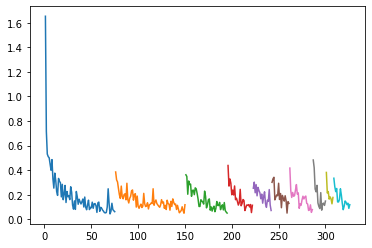

In [33]:
loss_plot(ewc_total_loss_optimised)

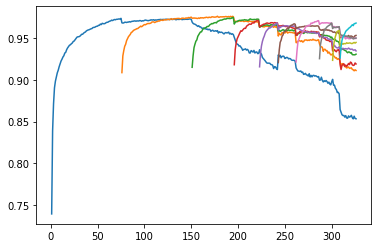

In [34]:
accuracy_plot(ewc_prec_optimised)

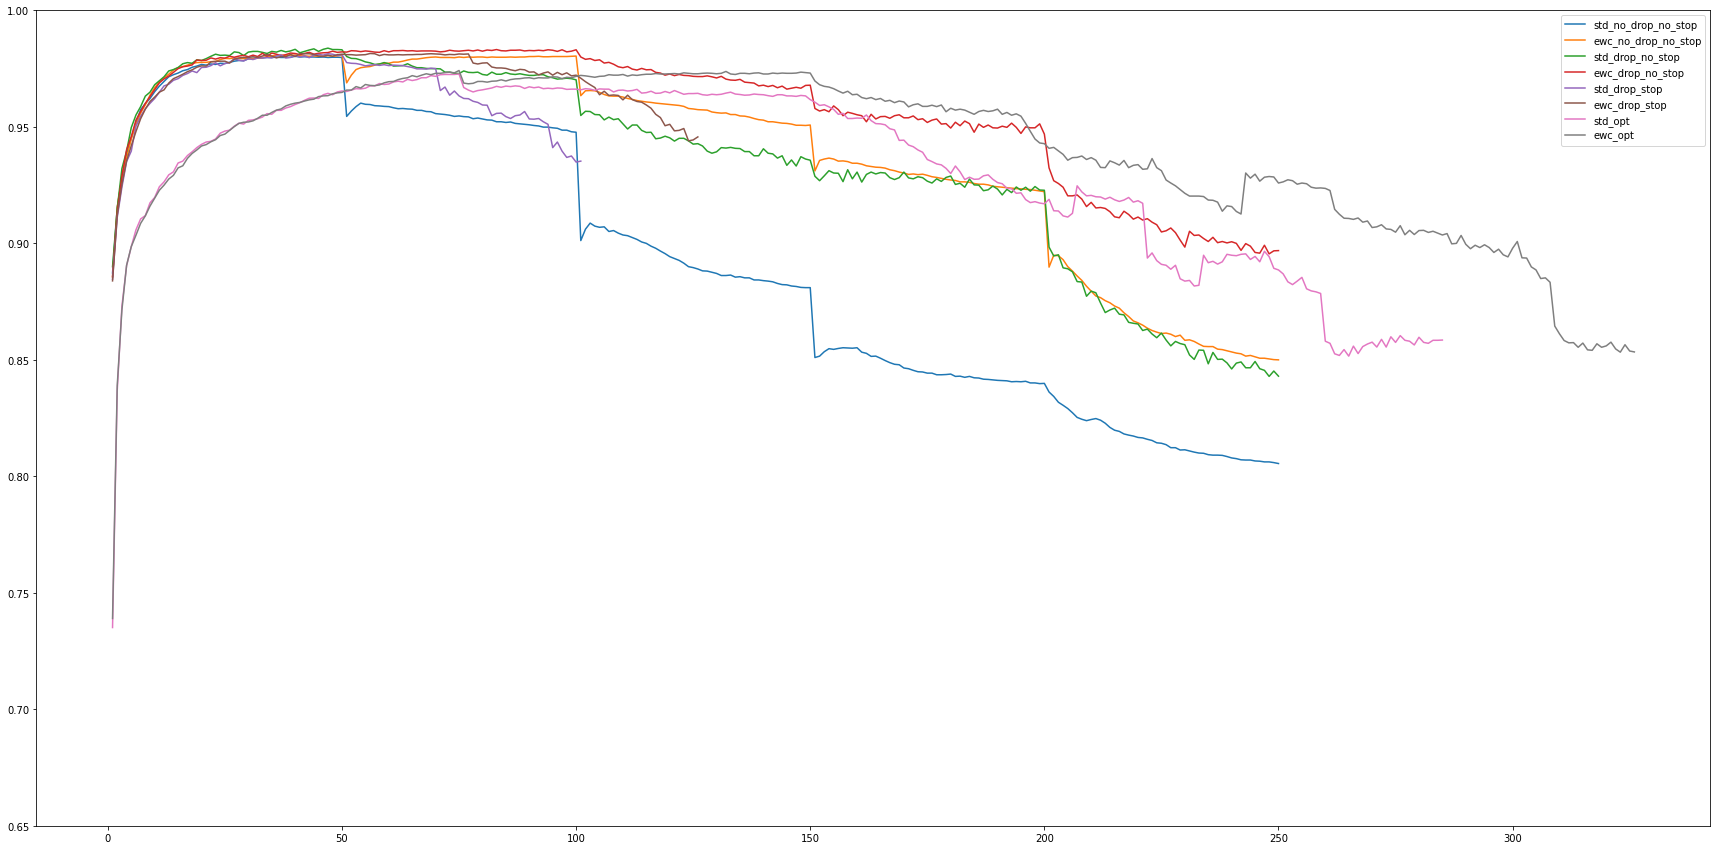

In [40]:
#compare performance on first task:
fig = plt.figure(figsize = (30,15))
plt.ylim(0.65,1)

plt.plot(range(1, len(standard_prec_no_dropout_no_earlystopping[1])+1),
         standard_prec_no_dropout_no_earlystopping[1], label = 'std_no_drop_no_stop')
plt.plot(range(1, len(ewc_prec_no_dropout_no_earlystopping[1])+1),
         ewc_prec_no_dropout_no_earlystopping[1], label = 'ewc_no_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropout_no_earlystopping[1])+1),
         standard_prec_dropout_no_earlystopping[1], label = 'std_drop_no_stop')
plt.plot(range(1, len(ewc_prec_dropout_no_earlystopping[1])+1),
         ewc_prec_dropout_no_earlystopping[1], label = 'ewc_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropout_earlystopping[1])+1),
         standard_prec_dropout_earlystopping[1], label = 'std_drop_stop')
plt.plot(range(1, len(ewc_prec_dropout_earlystopping[1])+1),
         ewc_prec_dropout_earlystopping[1], label = 'ewc_drop_stop')
plt.plot(range(1, len(standard_prec_optimised[1])+1),
         standard_prec_optimised[1], label = 'std_opt')
plt.plot(range(1, len(ewc_prec_optimised[1])+1),
         ewc_prec_optimised[1], label = 'ewc_opt')
plt.legend()
plt.show()

In [43]:
lamda = 800
lr = 5.e-3
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised2 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised2)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised2, 
 ewc_total_loss_optimised2,
 ewc_ce_loss_optimised2, 
 ewc_ewc_loss_optimised2) =train(
    mlp_consolidation_optimised2, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.5469 | loss => ce: 2.118 / ewc: 0.0 / total: 2.118: : 375it [00:15, 24.42it/s]


Validation loss decreased (inf --> 2.096886).  Saving model ...


=> task: 1/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.7109 | loss => ce: 1.619 / ewc: 0.0 / total: 1.619: : 375it [00:15, 24.87it/s]


Validation loss decreased (2.096886 --> 1.593182).  Saving model ...


=> task: 1/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.7656 | loss => ce: 1.049 / ewc: 0.0 / total: 1.049: : 375it [00:14, 25.37it/s] 


Validation loss decreased (1.593182 --> 0.993906).  Saving model ...


=> task: 1/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8203 | loss => ce: 0.7522 / ewc: 0.0 / total: 0.7522: : 375it [00:14, 25.88it/s]


Validation loss decreased (0.993906 --> 0.710522).  Saving model ...


=> task: 1/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8125 | loss => ce: 0.727 / ewc: 0.0 / total: 0.727: : 375it [00:15, 24.59it/s]  


Validation loss decreased (0.710522 --> 0.577185).  Saving model ...


=> task: 1/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8125 | loss => ce: 0.5999 / ewc: 0.0 / total: 0.5999: : 375it [00:15, 24.89it/s]


Validation loss decreased (0.577185 --> 0.501912).  Saving model ...


=> task: 1/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4651 / ewc: 0.0 / total: 0.4651: : 375it [00:15, 24.62it/s]


Validation loss decreased (0.501912 --> 0.452385).  Saving model ...


=> task: 1/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.4779 / ewc: 0.0 / total: 0.4779: : 375it [00:15, 24.84it/s]


Validation loss decreased (0.452385 --> 0.418638).  Saving model ...


=> task: 1/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.471 / ewc: 0.0 / total: 0.471: : 375it [00:15, 24.95it/s]  


Validation loss decreased (0.418638 --> 0.394221).  Saving model ...


=> task: 1/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4089 / ewc: 0.0 / total: 0.4089: : 375it [00:15, 24.85it/s]


Validation loss decreased (0.394221 --> 0.375249).  Saving model ...


=> task: 1/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3355 / ewc: 0.0 / total: 0.3355: : 375it [00:15, 24.84it/s]


Validation loss decreased (0.375249 --> 0.360711).  Saving model ...


=> task: 1/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3499 / ewc: 0.0 / total: 0.3499: : 375it [00:15, 23.92it/s]


Validation loss decreased (0.360711 --> 0.347484).  Saving model ...


=> task: 1/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.3996 / ewc: 0.0 / total: 0.3996: : 375it [00:15, 23.62it/s]


Validation loss decreased (0.347484 --> 0.336507).  Saving model ...


=> task: 1/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3745 / ewc: 0.0 / total: 0.3745: : 375it [00:15, 24.86it/s]


Validation loss decreased (0.336507 --> 0.327810).  Saving model ...


=> task: 1/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3206 / ewc: 0.0 / total: 0.3206: : 375it [00:15, 24.68it/s]


Validation loss decreased (0.327810 --> 0.319759).  Saving model ...


=> task: 1/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.286 / ewc: 0.0 / total: 0.286: : 375it [00:13, 26.98it/s]  


Validation loss decreased (0.319759 --> 0.311391).  Saving model ...


=> task: 1/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.4047 / ewc: 0.0 / total: 0.4047: : 375it [00:15, 24.73it/s]


Validation loss decreased (0.311391 --> 0.304340).  Saving model ...


=> task: 1/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.226 / ewc: 0.0 / total: 0.226: : 375it [00:15, 24.98it/s]  


Validation loss decreased (0.304340 --> 0.298036).  Saving model ...


=> task: 1/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.329 / ewc: 0.0 / total: 0.329: : 375it [00:15, 24.41it/s]  


Validation loss decreased (0.298036 --> 0.291990).  Saving model ...


=> task: 1/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2758 / ewc: 0.0 / total: 0.2758: : 375it [00:14, 26.38it/s]


Validation loss decreased (0.291990 --> 0.286013).  Saving model ...


=> task: 1/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1662 / ewc: 0.0 / total: 0.1662: : 375it [00:15, 24.98it/s]


Validation loss decreased (0.286013 --> 0.280906).  Saving model ...


=> task: 1/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2738 / ewc: 0.0 / total: 0.2738: : 375it [00:15, 24.60it/s]


Validation loss decreased (0.280906 --> 0.275725).  Saving model ...


=> task: 1/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2488 / ewc: 0.0 / total: 0.2488: : 375it [00:14, 25.28it/s]


Validation loss decreased (0.275725 --> 0.270624).  Saving model ...


=> task: 1/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2013 / ewc: 0.0 / total: 0.2013: : 375it [00:15, 24.86it/s]


Validation loss decreased (0.270624 --> 0.267013).  Saving model ...


=> task: 1/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.47 / ewc: 0.0 / total: 0.47: : 375it [00:15, 24.42it/s]    


Validation loss decreased (0.267013 --> 0.261802).  Saving model ...


=> task: 1/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1784 / ewc: 0.0 / total: 0.1784: : 375it [00:14, 25.37it/s]


Validation loss decreased (0.261802 --> 0.257046).  Saving model ...


=> task: 1/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2219 / ewc: 0.0 / total: 0.2219: : 375it [00:15, 23.79it/s]


Validation loss decreased (0.257046 --> 0.252327).  Saving model ...


=> task: 1/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2134 / ewc: 0.0 / total: 0.2134: : 375it [00:15, 24.62it/s]


Validation loss decreased (0.252327 --> 0.248984).  Saving model ...


=> task: 1/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3205 / ewc: 0.0 / total: 0.3205: : 375it [00:15, 24.53it/s]


Validation loss decreased (0.248984 --> 0.244986).  Saving model ...


=> task: 1/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2616 / ewc: 0.0 / total: 0.2616: : 375it [00:16, 22.68it/s]


Validation loss decreased (0.244986 --> 0.242323).  Saving model ...


=> task: 1/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3108 / ewc: 0.0 / total: 0.3108: : 375it [00:15, 24.27it/s]


Validation loss decreased (0.242323 --> 0.237395).  Saving model ...


=> task: 1/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2375 / ewc: 0.0 / total: 0.2375: : 375it [00:15, 24.85it/s]


Validation loss decreased (0.237395 --> 0.234203).  Saving model ...


=> task: 1/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1544 / ewc: 0.0 / total: 0.1544: : 375it [00:15, 23.80it/s]


Validation loss decreased (0.234203 --> 0.231041).  Saving model ...


=> task: 1/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2393 / ewc: 0.0 / total: 0.2393: : 375it [00:15, 24.00it/s] 


Validation loss decreased (0.231041 --> 0.226599).  Saving model ...


=> task: 1/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1878 / ewc: 0.0 / total: 0.1878: : 375it [00:15, 24.11it/s]


Validation loss decreased (0.226599 --> 0.223315).  Saving model ...


=> task: 1/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2929 / ewc: 0.0 / total: 0.2929: : 375it [00:15, 24.09it/s]


Validation loss decreased (0.223315 --> 0.219898).  Saving model ...


=> task: 1/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2275 / ewc: 0.0 / total: 0.2275: : 375it [00:14, 25.49it/s]


Validation loss decreased (0.219898 --> 0.217522).  Saving model ...


=> task: 1/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2004 / ewc: 0.0 / total: 0.2004: : 375it [00:15, 24.67it/s] 


Validation loss decreased (0.217522 --> 0.214179).  Saving model ...


=> task: 1/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2608 / ewc: 0.0 / total: 0.2608: : 375it [00:15, 23.94it/s]


Validation loss decreased (0.214179 --> 0.211902).  Saving model ...


=> task: 1/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3622 / ewc: 0.0 / total: 0.3622: : 375it [00:15, 24.74it/s]


Validation loss decreased (0.211902 --> 0.208283).  Saving model ...


=> task: 1/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2803 / ewc: 0.0 / total: 0.2803: : 375it [00:15, 24.69it/s] 


Validation loss decreased (0.208283 --> 0.206062).  Saving model ...


=> task: 1/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2921 / ewc: 0.0 / total: 0.2921: : 375it [00:14, 25.93it/s] 


Validation loss decreased (0.206062 --> 0.202802).  Saving model ...


=> task: 1/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1755 / ewc: 0.0 / total: 0.1755: : 375it [00:15, 24.63it/s] 


Validation loss decreased (0.202802 --> 0.199813).  Saving model ...


=> task: 1/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1649 / ewc: 0.0 / total: 0.1649: : 375it [00:15, 24.46it/s] 


Validation loss decreased (0.199813 --> 0.197619).  Saving model ...


=> task: 1/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1277 / ewc: 0.0 / total: 0.1277: : 375it [00:15, 23.98it/s] 


Validation loss decreased (0.197619 --> 0.194252).  Saving model ...


=> task: 1/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2302 / ewc: 0.0 / total: 0.2302: : 375it [00:15, 24.39it/s] 


Validation loss decreased (0.194252 --> 0.192359).  Saving model ...


=> task: 1/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1209 / ewc: 0.0 / total: 0.1209: : 375it [00:15, 24.21it/s] 


Validation loss decreased (0.192359 --> 0.190478).  Saving model ...


=> task: 1/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2334 / ewc: 0.0 / total: 0.2334: : 375it [00:14, 25.05it/s] 


Validation loss decreased (0.190478 --> 0.187383).  Saving model ...


=> task: 1/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1569 / ewc: 0.0 / total: 0.1569: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.187383 --> 0.185228).  Saving model ...


=> task: 1/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2675 / ewc: 0.0 / total: 0.2675: : 375it [00:14, 25.33it/s] 


Validation loss decreased (0.185228 --> 0.183323).  Saving model ...


=> task: 1/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1984 / ewc: 0.0 / total: 0.1984: : 375it [00:15, 24.46it/s] 


Validation loss decreased (0.183323 --> 0.181022).  Saving model ...


=> task: 1/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2007 / ewc: 0.0 / total: 0.2007: : 375it [00:15, 24.33it/s] 


Validation loss decreased (0.181022 --> 0.179147).  Saving model ...


=> task: 1/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.284 / ewc: 0.0 / total: 0.284: : 375it [00:15, 23.73it/s]   


Validation loss decreased (0.179147 --> 0.176402).  Saving model ...


=> task: 1/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1451 / ewc: 0.0 / total: 0.1451: : 375it [00:15, 24.63it/s] 


Validation loss decreased (0.176402 --> 0.175011).  Saving model ...


=> task: 1/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1375 / ewc: 0.0 / total: 0.1375: : 375it [00:15, 23.94it/s] 


Validation loss decreased (0.175011 --> 0.173254).  Saving model ...


=> task: 1/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1222 / ewc: 0.0 / total: 0.1222: : 375it [00:15, 23.50it/s] 


Validation loss decreased (0.173254 --> 0.170844).  Saving model ...


=> task: 1/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1438 / ewc: 0.0 / total: 0.1438: : 375it [00:15, 24.96it/s] 


Validation loss decreased (0.170844 --> 0.169410).  Saving model ...


=> task: 1/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1561 / ewc: 0.0 / total: 0.1561: : 375it [00:15, 23.98it/s] 


Validation loss decreased (0.169410 --> 0.167659).  Saving model ...


=> task: 1/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1426 / ewc: 0.0 / total: 0.1426: : 375it [00:15, 23.70it/s] 


Validation loss decreased (0.167659 --> 0.166041).  Saving model ...


=> task: 1/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1606 / ewc: 0.0 / total: 0.1606: : 375it [00:15, 24.87it/s] 


Validation loss decreased (0.166041 --> 0.163820).  Saving model ...


=> task: 1/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1769 / ewc: 0.0 / total: 0.1769: : 375it [00:15, 24.51it/s] 


Validation loss decreased (0.163820 --> 0.162900).  Saving model ...


=> task: 1/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1683 / ewc: 0.0 / total: 0.1683: : 375it [00:15, 24.72it/s] 


Validation loss decreased (0.162900 --> 0.160866).  Saving model ...


=> task: 1/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1969 / ewc: 0.0 / total: 0.1969: : 375it [00:15, 24.92it/s] 


Validation loss decreased (0.160866 --> 0.159569).  Saving model ...


=> task: 1/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.155 / ewc: 0.0 / total: 0.155: : 375it [00:15, 24.86it/s]   


Validation loss decreased (0.159569 --> 0.158530).  Saving model ...


=> task: 1/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2236 / ewc: 0.0 / total: 0.2236: : 375it [00:15, 24.90it/s] 


Validation loss decreased (0.158530 --> 0.155998).  Saving model ...


=> task: 1/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.126 / ewc: 0.0 / total: 0.126: : 375it [00:14, 25.07it/s]   


Validation loss decreased (0.155998 --> 0.154690).  Saving model ...


=> task: 1/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1587 / ewc: 0.0 / total: 0.1587: : 375it [00:15, 24.64it/s] 


Validation loss decreased (0.154690 --> 0.153355).  Saving model ...


=> task: 1/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2247 / ewc: 0.0 / total: 0.2247: : 375it [00:15, 24.85it/s] 


Validation loss decreased (0.153355 --> 0.152134).  Saving model ...


=> task: 1/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.156 / ewc: 0.0 / total: 0.156: : 375it [00:15, 24.73it/s]   


Validation loss decreased (0.152134 --> 0.151143).  Saving model ...


=> task: 1/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1109 / ewc: 0.0 / total: 0.1109: : 375it [00:15, 24.76it/s] 


Validation loss decreased (0.151143 --> 0.149320).  Saving model ...


=> task: 1/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3272 / ewc: 0.0 / total: 0.3272: : 375it [00:15, 24.74it/s] 


Validation loss decreased (0.149320 --> 0.148188).  Saving model ...


=> task: 1/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2166 / ewc: 0.0 / total: 0.2166: : 375it [00:15, 24.82it/s]  


Validation loss decreased (0.148188 --> 0.146649).  Saving model ...


=> task: 1/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.305 / ewc: 0.0 / total: 0.305: : 375it [00:15, 24.61it/s]   


Validation loss decreased (0.146649 --> 0.145097).  Saving model ...


=> task: 1/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1902 / ewc: 0.0 / total: 0.1902: : 375it [00:15, 24.95it/s] 


Validation loss decreased (0.145097 --> 0.143912).  Saving model ...


=> task: 1/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1443 / ewc: 0.0 / total: 0.1443: : 375it [00:15, 24.89it/s] 


Validation loss decreased (0.143912 --> 0.143089).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.6286 / ewc: 0.03443 / total: 0.663: : 375it [00:25, 14.60it/s]


Validation loss decreased (inf --> 0.331227).  Saving model ...


=> task: 2/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.7812 | loss => ce: 0.6388 / ewc: 0.0412 / total: 0.68: : 375it [00:26, 14.31it/s]   


Validation loss decreased (0.331227 --> 0.273809).  Saving model ...


=> task: 2/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3531 / ewc: 0.0425 / total: 0.3956: : 375it [00:26, 14.16it/s] 


Validation loss decreased (0.273809 --> 0.250729).  Saving model ...


=> task: 2/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.4107 / ewc: 0.04228 / total: 0.453: : 375it [00:27, 13.76it/s] 


Validation loss decreased (0.250729 --> 0.238444).  Saving model ...


=> task: 2/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.3707 / ewc: 0.04134 / total: 0.412: : 375it [00:26, 13.93it/s] 


Validation loss decreased (0.238444 --> 0.227165).  Saving model ...


=> task: 2/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3405 / ewc: 0.04042 / total: 0.381: : 375it [00:26, 14.00it/s]


Validation loss decreased (0.227165 --> 0.220078).  Saving model ...


=> task: 2/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.312 / ewc: 0.03964 / total: 0.3516: : 375it [00:26, 13.94it/s] 


Validation loss decreased (0.220078 --> 0.214282).  Saving model ...


=> task: 2/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.309 / ewc: 0.03881 / total: 0.3478: : 375it [00:27, 13.87it/s] 


Validation loss decreased (0.214282 --> 0.209603).  Saving model ...


=> task: 2/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3344 / ewc: 0.038 / total: 0.3724: : 375it [00:26, 14.03it/s]  


Validation loss decreased (0.209603 --> 0.205298).  Saving model ...


=> task: 2/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3795 / ewc: 0.03731 / total: 0.4169: : 375it [00:26, 13.95it/s] 


Validation loss decreased (0.205298 --> 0.201237).  Saving model ...


=> task: 2/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2886 / ewc: 0.03667 / total: 0.3252: : 375it [00:26, 13.97it/s]


Validation loss decreased (0.201237 --> 0.198306).  Saving model ...


=> task: 2/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.18 / ewc: 0.03599 / total: 0.216: : 375it [00:26, 13.96it/s]   


Validation loss decreased (0.198306 --> 0.194910).  Saving model ...


=> task: 2/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3302 / ewc: 0.03548 / total: 0.3656: : 375it [00:26, 13.95it/s]


Validation loss decreased (0.194910 --> 0.192615).  Saving model ...


=> task: 2/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1691 / ewc: 0.03501 / total: 0.2041: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.192615 --> 0.189983).  Saving model ...


=> task: 2/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2174 / ewc: 0.03456 / total: 0.252: : 375it [00:25, 14.64it/s] 


Validation loss decreased (0.189983 --> 0.187675).  Saving model ...


=> task: 2/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2746 / ewc: 0.0341 / total: 0.3087: : 375it [00:26, 13.95it/s] 


Validation loss decreased (0.187675 --> 0.185511).  Saving model ...


=> task: 2/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1625 / ewc: 0.03368 / total: 0.1962: : 375it [00:26, 14.07it/s]


Validation loss decreased (0.185511 --> 0.183357).  Saving model ...


=> task: 2/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1916 / ewc: 0.03331 / total: 0.2249: : 375it [00:26, 13.94it/s]


Validation loss decreased (0.183357 --> 0.181191).  Saving model ...


=> task: 2/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2206 / ewc: 0.03295 / total: 0.2536: : 375it [00:26, 14.29it/s]


Validation loss decreased (0.181191 --> 0.179857).  Saving model ...


=> task: 2/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2273 / ewc: 0.0326 / total: 0.2599: : 375it [00:26, 13.91it/s]


Validation loss decreased (0.179857 --> 0.177566).  Saving model ...


=> task: 2/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2385 / ewc: 0.03235 / total: 0.2708: : 375it [00:26, 13.94it/s]


Validation loss decreased (0.177566 --> 0.176392).  Saving model ...


=> task: 2/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.168 / ewc: 0.03204 / total: 0.2001: : 375it [00:26, 13.98it/s] 


Validation loss decreased (0.176392 --> 0.174930).  Saving model ...


=> task: 2/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.221 / ewc: 0.03178 / total: 0.2528: : 375it [00:27, 13.85it/s] 


Validation loss decreased (0.174930 --> 0.173537).  Saving model ...


=> task: 2/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2525 / ewc: 0.03156 / total: 0.284: : 375it [00:25, 14.51it/s] 


Validation loss decreased (0.173537 --> 0.172160).  Saving model ...


=> task: 2/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1442 / ewc: 0.03136 / total: 0.1756: : 375it [00:26, 14.08it/s]


Validation loss decreased (0.172160 --> 0.171102).  Saving model ...


=> task: 2/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1844 / ewc: 0.03109 / total: 0.2154: : 375it [00:27, 13.85it/s]


Validation loss decreased (0.171102 --> 0.169491).  Saving model ...


=> task: 2/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.199 / ewc: 0.03089 / total: 0.2299: : 375it [00:26, 14.25it/s] 


Validation loss decreased (0.169491 --> 0.168578).  Saving model ...


=> task: 2/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1476 / ewc: 0.03071 / total: 0.1783: : 375it [00:27, 13.81it/s]


Validation loss decreased (0.168578 --> 0.167376).  Saving model ...


=> task: 2/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1246 / ewc: 0.0305 / total: 0.1551: : 375it [00:26, 13.91it/s]


Validation loss decreased (0.167376 --> 0.166144).  Saving model ...


=> task: 2/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.184 / ewc: 0.03028 / total: 0.2142: : 375it [00:26, 14.00it/s] 


Validation loss decreased (0.166144 --> 0.164916).  Saving model ...


=> task: 2/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1981 / ewc: 0.03015 / total: 0.2283: : 375it [00:27, 13.82it/s]


Validation loss decreased (0.164916 --> 0.164381).  Saving model ...


=> task: 2/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2708 / ewc: 0.02995 / total: 0.3008: : 375it [00:25, 14.66it/s]


Validation loss decreased (0.164381 --> 0.163242).  Saving model ...


=> task: 2/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1668 / ewc: 0.02978 / total: 0.1966: : 375it [00:26, 14.41it/s]


Validation loss decreased (0.163242 --> 0.162122).  Saving model ...


=> task: 2/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1795 / ewc: 0.02963 / total: 0.2091: : 375it [00:26, 14.39it/s]


Validation loss decreased (0.162122 --> 0.161346).  Saving model ...


=> task: 2/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2003 / ewc: 0.02951 / total: 0.2298: : 375it [00:25, 14.46it/s]


Validation loss decreased (0.161346 --> 0.160682).  Saving model ...


=> task: 2/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2165 / ewc: 0.02932 / total: 0.2459: : 375it [00:26, 14.33it/s]


Validation loss decreased (0.160682 --> 0.159920).  Saving model ...


=> task: 2/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1954 / ewc: 0.02916 / total: 0.2245: : 375it [00:26, 14.24it/s]


Validation loss decreased (0.159920 --> 0.158707).  Saving model ...


=> task: 2/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2389 / ewc: 0.02904 / total: 0.2679: : 375it [00:26, 14.22it/s]


Validation loss decreased (0.158707 --> 0.158567).  Saving model ...


=> task: 2/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.127 / ewc: 0.02896 / total: 0.156: : 375it [00:25, 14.81it/s]  


Validation loss decreased (0.158567 --> 0.157766).  Saving model ...


=> task: 2/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1132 / ewc: 0.02877 / total: 0.142: : 375it [00:25, 14.45it/s] 


Validation loss decreased (0.157766 --> 0.156778).  Saving model ...


=> task: 2/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2011 / ewc: 0.02864 / total: 0.2297: : 375it [00:26, 14.32it/s]


Validation loss decreased (0.156778 --> 0.155851).  Saving model ...


=> task: 2/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2803 / ewc: 0.02856 / total: 0.3088: : 375it [00:26, 14.33it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.2713 / ewc: 0.02843 / total: 0.2997: : 375it [00:25, 14.62it/s]


Validation loss decreased (0.155851 --> 0.155157).  Saving model ...


=> task: 2/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1948 / ewc: 0.0283 / total: 0.2231: : 375it [00:26, 14.39it/s] 


Validation loss decreased (0.155157 --> 0.154216).  Saving model ...


=> task: 2/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2779 / ewc: 0.02819 / total: 0.3061: : 375it [00:25, 14.43it/s]


Validation loss decreased (0.154216 --> 0.153815).  Saving model ...


=> task: 2/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 1.0 | loss => ce: 0.07529 / ewc: 0.02809 / total: 0.1034: : 375it [00:27, 13.64it/s]  


Validation loss decreased (0.153815 --> 0.153309).  Saving model ...


=> task: 2/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1828 / ewc: 0.028 / total: 0.2108: : 375it [00:27, 13.69it/s]  


Validation loss decreased (0.153309 --> 0.152395).  Saving model ...


=> task: 2/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1866 / ewc: 0.02788 / total: 0.2145: : 375it [00:26, 13.98it/s]


Validation loss decreased (0.152395 --> 0.151667).  Saving model ...


=> task: 2/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1826 / ewc: 0.02779 / total: 0.2104: : 375it [00:26, 13.99it/s]


Validation loss decreased (0.151667 --> 0.151219).  Saving model ...


=> task: 2/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1852 / ewc: 0.02766 / total: 0.2128: : 375it [00:26, 13.92it/s]


Validation loss decreased (0.151219 --> 0.150878).  Saving model ...


=> task: 2/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1358 / ewc: 0.02759 / total: 0.1633: : 375it [00:27, 13.65it/s] 


Validation loss decreased (0.150878 --> 0.150798).  Saving model ...


=> task: 2/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2642 / ewc: 0.02746 / total: 0.2916: : 375it [00:26, 14.09it/s] 


Validation loss decreased (0.150798 --> 0.149652).  Saving model ...


=> task: 2/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2189 / ewc: 0.02736 / total: 0.2462: : 375it [00:25, 14.60it/s] 


Validation loss decreased (0.149652 --> 0.149099).  Saving model ...


=> task: 2/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1931 / ewc: 0.02726 / total: 0.2203: : 375it [00:24, 15.07it/s]


Validation loss decreased (0.149099 --> 0.148522).  Saving model ...


=> task: 2/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1427 / ewc: 0.0272 / total: 0.1699: : 375it [00:25, 14.62it/s] 


Validation loss decreased (0.148522 --> 0.148433).  Saving model ...


=> task: 2/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1373 / ewc: 0.02713 / total: 0.1644: : 375it [00:26, 14.08it/s] 


Validation loss decreased (0.148433 --> 0.148038).  Saving model ...


=> task: 2/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1902 / ewc: 0.02704 / total: 0.2173: : 375it [00:26, 13.95it/s] 


Validation loss decreased (0.148038 --> 0.147385).  Saving model ...


=> task: 2/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1634 / ewc: 0.02698 / total: 0.1904: : 375it [00:27, 13.89it/s] 


Validation loss decreased (0.147385 --> 0.147272).  Saving model ...


=> task: 2/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1357 / ewc: 0.02687 / total: 0.1626: : 375it [00:27, 13.66it/s]


Validation loss decreased (0.147272 --> 0.146589).  Saving model ...


=> task: 2/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1303 / ewc: 0.02677 / total: 0.157: : 375it [00:26, 13.97it/s]  


Validation loss decreased (0.146589 --> 0.146224).  Saving model ...


=> task: 2/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1611 / ewc: 0.02671 / total: 0.1878: : 375it [00:27, 13.80it/s] 


Validation loss decreased (0.146224 --> 0.145671).  Saving model ...


=> task: 2/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1615 / ewc: 0.02662 / total: 0.1882: : 375it [00:28, 13.33it/s] 


Validation loss decreased (0.145671 --> 0.145408).  Saving model ...


=> task: 2/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1367 / ewc: 0.02656 / total: 0.1633: : 375it [00:26, 14.20it/s] 


Validation loss decreased (0.145408 --> 0.145183).  Saving model ...


=> task: 2/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1432 / ewc: 0.02649 / total: 0.1697: : 375it [00:26, 13.89it/s] 


Validation loss decreased (0.145183 --> 0.144750).  Saving model ...


=> task: 2/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.229 / ewc: 0.02643 / total: 0.2554: : 375it [00:26, 14.38it/s]  


Validation loss decreased (0.144750 --> 0.144107).  Saving model ...


=> task: 2/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1268 / ewc: 0.02637 / total: 0.1532: : 375it [00:25, 14.44it/s] 


Validation loss decreased (0.144107 --> 0.144029).  Saving model ...


=> task: 2/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09035 / ewc: 0.02628 / total: 0.1166: : 375it [00:26, 14.14it/s]


Validation loss decreased (0.144029 --> 0.143294).  Saving model ...


=> task: 2/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.19 / ewc: 0.02621 / total: 0.2162: : 375it [00:25, 14.67it/s]   


Validation loss decreased (0.143294 --> 0.143171).  Saving model ...


=> task: 2/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1123 / ewc: 0.02617 / total: 0.1384: : 375it [00:26, 14.11it/s]


Validation loss decreased (0.143171 --> 0.142946).  Saving model ...


=> task: 2/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09702 / ewc: 0.02607 / total: 0.1231: : 375it [00:27, 13.83it/s]


Validation loss decreased (0.142946 --> 0.142286).  Saving model ...


=> task: 2/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1266 / ewc: 0.02601 / total: 0.1526: : 375it [00:27, 13.83it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1607 / ewc: 0.02594 / total: 0.1866: : 375it [00:24, 15.39it/s] 


Validation loss decreased (0.142286 --> 0.141725).  Saving model ...


=> task: 2/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1749 / ewc: 0.02588 / total: 0.2008: : 375it [00:26, 14.38it/s] 


Validation loss decreased (0.141725 --> 0.141236).  Saving model ...


=> task: 2/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1402 / ewc: 0.02582 / total: 0.166: : 375it [00:26, 14.22it/s]  


Validation loss decreased (0.141236 --> 0.141115).  Saving model ...


=> task: 2/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.2148 / ewc: 0.02577 / total: 0.2406: : 375it [00:23, 15.98it/s] 


Validation loss decreased (0.141115 --> 0.140672).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.5289 / ewc: 0.04459 / total: 0.5734: : 375it [00:26, 14.08it/s]


Validation loss decreased (inf --> 0.269082).  Saving model ...


=> task: 3/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4199 / ewc: 0.04909 / total: 0.469: : 375it [00:26, 14.26it/s] 


Validation loss decreased (0.269082 --> 0.234102).  Saving model ...


=> task: 3/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.4028 / ewc: 0.04876 / total: 0.4516: : 375it [00:25, 14.43it/s]


Validation loss decreased (0.234102 --> 0.219497).  Saving model ...


=> task: 3/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.37 / ewc: 0.04718 / total: 0.4172: : 375it [00:25, 14.50it/s]  


Validation loss decreased (0.219497 --> 0.210912).  Saving model ...


=> task: 3/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2334 / ewc: 0.04548 / total: 0.2789: : 375it [00:25, 14.46it/s]


Validation loss decreased (0.210912 --> 0.206056).  Saving model ...


=> task: 3/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3016 / ewc: 0.04383 / total: 0.3455: : 375it [00:25, 14.74it/s]


Validation loss decreased (0.206056 --> 0.202706).  Saving model ...


=> task: 3/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2673 / ewc: 0.04238 / total: 0.3097: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.202706 --> 0.199134).  Saving model ...


=> task: 3/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2829 / ewc: 0.0411 / total: 0.324: : 375it [00:26, 14.04it/s] 


Validation loss decreased (0.199134 --> 0.196633).  Saving model ...


=> task: 3/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2332 / ewc: 0.03991 / total: 0.2731: : 375it [00:26, 14.31it/s]


Validation loss decreased (0.196633 --> 0.194329).  Saving model ...


=> task: 3/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3184 / ewc: 0.03891 / total: 0.3573: : 375it [00:26, 14.28it/s]


Validation loss decreased (0.194329 --> 0.192427).  Saving model ...


=> task: 3/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2496 / ewc: 0.03808 / total: 0.2877: : 375it [00:25, 14.83it/s]


Validation loss decreased (0.192427 --> 0.191443).  Saving model ...


=> task: 3/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2863 / ewc: 0.03727 / total: 0.3236: : 375it [00:26, 14.03it/s]


Validation loss decreased (0.191443 --> 0.190177).  Saving model ...


=> task: 3/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2097 / ewc: 0.03658 / total: 0.2463: : 375it [00:26, 13.92it/s]


Validation loss decreased (0.190177 --> 0.188558).  Saving model ...


=> task: 3/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1881 / ewc: 0.03583 / total: 0.2239: : 375it [00:27, 13.77it/s]


Validation loss decreased (0.188558 --> 0.187866).  Saving model ...


=> task: 3/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2305 / ewc: 0.03529 / total: 0.2658: : 375it [00:27, 13.66it/s]


Validation loss decreased (0.187866 --> 0.186936).  Saving model ...


=> task: 3/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2111 / ewc: 0.03466 / total: 0.2457: : 375it [00:26, 13.96it/s]


Validation loss decreased (0.186936 --> 0.185540).  Saving model ...


=> task: 3/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1818 / ewc: 0.03412 / total: 0.2159: : 375it [00:27, 13.78it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2611 / ewc: 0.03362 / total: 0.2947: : 375it [00:26, 13.90it/s]


Validation loss decreased (0.185540 --> 0.184311).  Saving model ...


=> task: 3/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2538 / ewc: 0.03315 / total: 0.2869: : 375it [00:26, 14.09it/s]


Validation loss decreased (0.184311 --> 0.183115).  Saving model ...


=> task: 3/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3369 / ewc: 0.03277 / total: 0.3697: : 375it [00:26, 14.07it/s]


Validation loss decreased (0.183115 --> 0.182934).  Saving model ...


=> task: 3/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.131 / ewc: 0.03236 / total: 0.1633: : 375it [00:26, 13.97it/s] 


Validation loss decreased (0.182934 --> 0.182521).  Saving model ...


=> task: 3/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1385 / ewc: 0.03201 / total: 0.1705: : 375it [00:26, 14.08it/s]


Validation loss decreased (0.182521 --> 0.182339).  Saving model ...


=> task: 3/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1323 / ewc: 0.03166 / total: 0.1639: : 375it [00:26, 14.32it/s]


Validation loss decreased (0.182339 --> 0.181938).  Saving model ...


=> task: 3/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1839 / ewc: 0.03133 / total: 0.2152: : 375it [00:25, 14.98it/s]


Validation loss decreased (0.181938 --> 0.179824).  Saving model ...


=> task: 3/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1406 / ewc: 0.03106 / total: 0.1716: : 375it [00:26, 14.24it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2434 / ewc: 0.03076 / total: 0.2742: : 375it [00:26, 14.05it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2143 / ewc: 0.03048 / total: 0.2448: : 375it [00:26, 14.38it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1919 / ewc: 0.03019 / total: 0.2221: : 375it [00:25, 14.70it/s]


Validation loss decreased (0.179824 --> 0.179814).  Saving model ...


=> task: 3/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1663 / ewc: 0.02992 / total: 0.1963: : 375it [00:26, 14.11it/s]


Validation loss decreased (0.179814 --> 0.179351).  Saving model ...


=> task: 3/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1443 / ewc: 0.02966 / total: 0.1739: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.179351 --> 0.179166).  Saving model ...


=> task: 3/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2072 / ewc: 0.02944 / total: 0.2367: : 375it [00:26, 14.10it/s]


Validation loss decreased (0.179166 --> 0.178695).  Saving model ...


=> task: 3/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1768 / ewc: 0.02919 / total: 0.206: : 375it [00:26, 14.24it/s] 


Validation loss decreased (0.178695 --> 0.178452).  Saving model ...


=> task: 3/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2612 / ewc: 0.02901 / total: 0.2902: : 375it [00:24, 15.28it/s]


Validation loss decreased (0.178452 --> 0.176879).  Saving model ...


=> task: 3/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1978 / ewc: 0.02878 / total: 0.2266: : 375it [00:25, 14.55it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1151 / ewc: 0.02859 / total: 0.1437: : 375it [00:26, 14.13it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2721 / ewc: 0.02839 / total: 0.3005: : 375it [00:26, 14.04it/s]


Validation loss decreased (0.176879 --> 0.176667).  Saving model ...


=> task: 3/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1594 / ewc: 0.0282 / total: 0.1876: : 375it [00:26, 14.03it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2365 / ewc: 0.02803 / total: 0.2646: : 375it [00:26, 14.14it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.209 / ewc: 0.02786 / total: 0.2368: : 375it [00:26, 14.09it/s] 


Validation loss decreased (0.176667 --> 0.175749).  Saving model ...


=> task: 3/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1894 / ewc: 0.0277 / total: 0.2171: : 375it [00:24, 15.15it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2462 / ewc: 0.02756 / total: 0.2738: : 375it [00:26, 14.08it/s]


Validation loss decreased (0.175749 --> 0.174927).  Saving model ...


=> task: 3/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1425 / ewc: 0.0274 / total: 0.1699: : 375it [00:26, 14.08it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1505 / ewc: 0.02725 / total: 0.1777: : 375it [00:26, 14.12it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1348 / ewc: 0.02711 / total: 0.1619: : 375it [00:26, 14.06it/s] 


Validation loss decreased (0.174927 --> 0.174246).  Saving model ...


=> task: 3/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2182 / ewc: 0.02699 / total: 0.2451: : 375it [00:26, 14.28it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.161 / ewc: 0.02681 / total: 0.1879: : 375it [00:26, 14.27it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1492 / ewc: 0.02665 / total: 0.1759: : 375it [00:26, 13.96it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1273 / ewc: 0.02655 / total: 0.1538: : 375it [00:26, 14.03it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1199 / ewc: 0.0264 / total: 0.1463: : 375it [00:26, 14.23it/s]  


Validation loss decreased (0.174246 --> 0.173952).  Saving model ...


=> task: 3/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1822 / ewc: 0.02627 / total: 0.2084: : 375it [00:26, 14.02it/s] 


Validation loss decreased (0.173952 --> 0.173564).  Saving model ...


=> task: 3/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1778 / ewc: 0.02615 / total: 0.204: : 375it [00:26, 14.06it/s]  


Validation loss decreased (0.173564 --> 0.173408).  Saving model ...


=> task: 3/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1829 / ewc: 0.02608 / total: 0.209: : 375it [00:25, 14.65it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1755 / ewc: 0.02594 / total: 0.2014: : 375it [00:26, 14.00it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1784 / ewc: 0.02585 / total: 0.2042: : 375it [00:26, 14.10it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.156 / ewc: 0.02573 / total: 0.1817: : 375it [00:25, 14.80it/s]  


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1063 / ewc: 0.02561 / total: 0.132: : 375it [00:26, 14.23it/s]  


Validation loss decreased (0.173408 --> 0.173344).  Saving model ...


=> task: 3/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.131 / ewc: 0.02549 / total: 0.1565: : 375it [00:26, 13.91it/s]  


Validation loss decreased (0.173344 --> 0.172418).  Saving model ...


=> task: 3/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1171 / ewc: 0.02538 / total: 0.1425: : 375it [00:25, 14.61it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2065 / ewc: 0.02527 / total: 0.2317: : 375it [00:26, 13.90it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1799 / ewc: 0.02517 / total: 0.205: : 375it [00:26, 14.02it/s]  


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1775 / ewc: 0.02508 / total: 0.2026: : 375it [00:26, 13.93it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09449 / ewc: 0.02497 / total: 0.1195: : 375it [00:26, 13.97it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4956 / ewc: 0.04128 / total: 0.5369: : 375it [00:26, 14.29it/s]


Validation loss decreased (inf --> 0.255433).  Saving model ...


=> task: 4/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3001 / ewc: 0.04372 / total: 0.3438: : 375it [00:26, 14.41it/s]


Validation loss decreased (0.255433 --> 0.232431).  Saving model ...


=> task: 4/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2643 / ewc: 0.04242 / total: 0.3067: : 375it [00:26, 14.34it/s]


Validation loss decreased (0.232431 --> 0.222375).  Saving model ...


=> task: 4/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2843 / ewc: 0.04059 / total: 0.3249: : 375it [00:26, 14.33it/s]


Validation loss decreased (0.222375 --> 0.214947).  Saving model ...


=> task: 4/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2883 / ewc: 0.03908 / total: 0.3274: : 375it [00:25, 14.72it/s]


Validation loss decreased (0.214947 --> 0.213398).  Saving model ...


=> task: 4/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3645 / ewc: 0.03753 / total: 0.402: : 375it [00:26, 14.26it/s]  


Validation loss decreased (0.213398 --> 0.210480).  Saving model ...


=> task: 4/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.2853 / ewc: 0.03626 / total: 0.3216: : 375it [00:26, 14.39it/s]


Validation loss decreased (0.210480 --> 0.207467).  Saving model ...


=> task: 4/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3179 / ewc: 0.03514 / total: 0.353: : 375it [00:25, 14.64it/s] 


Validation loss decreased (0.207467 --> 0.205918).  Saving model ...


=> task: 4/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1388 / ewc: 0.03408 / total: 0.1729: : 375it [00:25, 14.68it/s]


Validation loss decreased (0.205918 --> 0.203621).  Saving model ...


=> task: 4/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3131 / ewc: 0.03319 / total: 0.3463: : 375it [00:25, 14.50it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1787 / ewc: 0.03236 / total: 0.2111: : 375it [00:25, 14.51it/s]


Validation loss decreased (0.203621 --> 0.201636).  Saving model ...


=> task: 4/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1639 / ewc: 0.03162 / total: 0.1955: : 375it [00:26, 14.30it/s]


Validation loss decreased (0.201636 --> 0.201074).  Saving model ...


=> task: 4/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.232 / ewc: 0.03092 / total: 0.2629: : 375it [00:26, 14.32it/s] 


Validation loss decreased (0.201074 --> 0.199378).  Saving model ...


=> task: 4/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2955 / ewc: 0.03038 / total: 0.3259: : 375it [00:26, 14.34it/s]


Validation loss decreased (0.199378 --> 0.197419).  Saving model ...


=> task: 4/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.263 / ewc: 0.0298 / total: 0.2928: : 375it [00:25, 14.45it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2847 / ewc: 0.0292 / total: 0.3139: : 375it [00:25, 14.47it/s] 


Validation loss decreased (0.197419 --> 0.196611).  Saving model ...


=> task: 4/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1794 / ewc: 0.02876 / total: 0.2082: : 375it [00:26, 14.42it/s]


Validation loss decreased (0.196611 --> 0.196270).  Saving model ...


=> task: 4/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1316 / ewc: 0.02832 / total: 0.1599: : 375it [00:26, 14.23it/s]


Validation loss decreased (0.196270 --> 0.195332).  Saving model ...


=> task: 4/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2768 / ewc: 0.02789 / total: 0.3047: : 375it [00:26, 14.28it/s]


Validation loss decreased (0.195332 --> 0.195013).  Saving model ...


=> task: 4/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1847 / ewc: 0.02755 / total: 0.2122: : 375it [00:26, 14.39it/s]


Validation loss decreased (0.195013 --> 0.194266).  Saving model ...


=> task: 4/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1012 / ewc: 0.02717 / total: 0.1284: : 375it [00:24, 15.03it/s]


Validation loss decreased (0.194266 --> 0.194068).  Saving model ...


=> task: 4/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2091 / ewc: 0.02681 / total: 0.2359: : 375it [00:25, 14.45it/s]


Validation loss decreased (0.194068 --> 0.192408).  Saving model ...


=> task: 4/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.171 / ewc: 0.02651 / total: 0.1975: : 375it [00:26, 14.36it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2249 / ewc: 0.02617 / total: 0.2511: : 375it [00:25, 14.47it/s]


Validation loss decreased (0.192408 --> 0.191795).  Saving model ...


=> task: 4/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2095 / ewc: 0.0259 / total: 0.2354: : 375it [00:26, 14.30it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1757 / ewc: 0.02565 / total: 0.2014: : 375it [00:24, 15.13it/s]


Validation loss decreased (0.191795 --> 0.191794).  Saving model ...


=> task: 4/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1635 / ewc: 0.02538 / total: 0.1889: : 375it [00:26, 14.27it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2521 / ewc: 0.02515 / total: 0.2772: : 375it [00:26, 14.38it/s]


Validation loss decreased (0.191794 --> 0.191311).  Saving model ...


=> task: 4/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2371 / ewc: 0.02491 / total: 0.262: : 375it [00:26, 14.34it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1429 / ewc: 0.0247 / total: 0.1676: : 375it [00:26, 14.32it/s] 


Validation loss decreased (0.191311 --> 0.189550).  Saving model ...


=> task: 4/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1135 / ewc: 0.02449 / total: 0.138: : 375it [00:26, 14.40it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2359 / ewc: 0.02429 / total: 0.2602: : 375it [00:25, 14.63it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.07623 / ewc: 0.02407 / total: 0.1003: : 375it [00:26, 14.36it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2091 / ewc: 0.02385 / total: 0.233: : 375it [00:26, 14.30it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1921 / ewc: 0.02368 / total: 0.2158: : 375it [00:26, 14.16it/s] 


Validation loss decreased (0.189550 --> 0.188991).  Saving model ...


=> task: 4/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.253 / ewc: 0.02348 / total: 0.2764: : 375it [00:26, 14.12it/s]  


Validation loss decreased (0.188991 --> 0.188911).  Saving model ...


=> task: 4/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1639 / ewc: 0.02331 / total: 0.1872: : 375it [00:26, 14.32it/s]


Validation loss decreased (0.188911 --> 0.188661).  Saving model ...


=> task: 4/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1207 / ewc: 0.02317 / total: 0.1438: : 375it [00:26, 14.13it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1508 / ewc: 0.02301 / total: 0.1739: : 375it [00:26, 14.04it/s] 


Validation loss decreased (0.188661 --> 0.188069).  Saving model ...


=> task: 4/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1993 / ewc: 0.02285 / total: 0.2222: : 375it [00:26, 14.12it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1554 / ewc: 0.02269 / total: 0.1781: : 375it [00:26, 14.06it/s] 


Validation loss decreased (0.188069 --> 0.187915).  Saving model ...


=> task: 4/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09198 / ewc: 0.02258 / total: 0.1146: : 375it [00:26, 14.16it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1564 / ewc: 0.02242 / total: 0.1789: : 375it [00:26, 14.10it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0873 / ewc: 0.02231 / total: 0.1096: : 375it [00:26, 14.26it/s] 


Validation loss decreased (0.187915 --> 0.186678).  Saving model ...


=> task: 4/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1311 / ewc: 0.02219 / total: 0.1533: : 375it [00:26, 14.08it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2103 / ewc: 0.02201 / total: 0.2323: : 375it [00:26, 14.37it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.08489 / ewc: 0.02191 / total: 0.1068: : 375it [00:26, 14.05it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.217 / ewc: 0.0218 / total: 0.2388: : 375it [00:26, 13.97it/s]   


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.145 / ewc: 0.02167 / total: 0.1667: : 375it [00:26, 14.02it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.5373 / ewc: 0.05176 / total: 0.5891: : 375it [00:26, 14.34it/s]


Validation loss decreased (inf --> 0.247342).  Saving model ...


=> task: 5/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3688 / ewc: 0.04985 / total: 0.4187: : 375it [00:25, 14.76it/s]


Validation loss decreased (0.247342 --> 0.229962).  Saving model ...


=> task: 5/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.4234 / ewc: 0.0459 / total: 0.4693: : 375it [00:26, 14.33it/s]


Validation loss decreased (0.229962 --> 0.222867).  Saving model ...


=> task: 5/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3228 / ewc: 0.04257 / total: 0.3654: : 375it [00:25, 14.76it/s]


Validation loss decreased (0.222867 --> 0.218241).  Saving model ...


=> task: 5/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4348 / ewc: 0.04005 / total: 0.4749: : 375it [00:25, 14.43it/s]


Validation loss decreased (0.218241 --> 0.216426).  Saving model ...


=> task: 5/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3138 / ewc: 0.03791 / total: 0.3517: : 375it [00:26, 14.39it/s]


Validation loss decreased (0.216426 --> 0.213627).  Saving model ...


=> task: 5/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3353 / ewc: 0.03608 / total: 0.3714: : 375it [00:26, 14.37it/s]


Validation loss decreased (0.213627 --> 0.213193).  Saving model ...


=> task: 5/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2382 / ewc: 0.03466 / total: 0.2729: : 375it [00:25, 14.62it/s]


Validation loss decreased (0.213193 --> 0.212253).  Saving model ...


=> task: 5/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.256 / ewc: 0.03336 / total: 0.2893: : 375it [00:25, 14.90it/s] 


Validation loss decreased (0.212253 --> 0.210769).  Saving model ...


=> task: 5/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1802 / ewc: 0.03232 / total: 0.2126: : 375it [00:25, 14.45it/s]


Validation loss decreased (0.210769 --> 0.210400).  Saving model ...


=> task: 5/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1784 / ewc: 0.03145 / total: 0.2098: : 375it [00:26, 14.38it/s]


Validation loss decreased (0.210400 --> 0.210013).  Saving model ...


=> task: 5/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2284 / ewc: 0.03057 / total: 0.259: : 375it [00:28, 13.17it/s] 


Validation loss decreased (0.210013 --> 0.208688).  Saving model ...


=> task: 5/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3078 / ewc: 0.02991 / total: 0.3377: : 375it [00:57,  6.56it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1123 / ewc: 0.0293 / total: 0.1416: : 375it [01:51,  3.37it/s]


Validation loss decreased (0.208688 --> 0.207229).  Saving model ...


=> task: 5/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1316 / ewc: 0.02863 / total: 0.1602: : 375it [00:26, 14.23it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2863 / ewc: 0.02808 / total: 0.3144: : 375it [00:25, 14.53it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1931 / ewc: 0.02754 / total: 0.2206: : 375it [00:27, 13.86it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2717 / ewc: 0.02708 / total: 0.2988: : 375it [00:26, 13.96it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2458 / ewc: 0.02668 / total: 0.2725: : 375it [00:27, 13.87it/s]


Validation loss decreased (0.207229 --> 0.206200).  Saving model ...


=> task: 5/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2155 / ewc: 0.02626 / total: 0.2418: : 375it [00:27, 13.63it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1784 / ewc: 0.02589 / total: 0.2043: : 375it [00:26, 14.09it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2359 / ewc: 0.02555 / total: 0.2614: : 375it [00:28, 13.18it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.197 / ewc: 0.02524 / total: 0.2223: : 375it [00:26, 13.90it/s] 


Validation loss decreased (0.206200 --> 0.206097).  Saving model ...


=> task: 5/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.169 / ewc: 0.02496 / total: 0.194: : 375it [00:26, 14.42it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1815 / ewc: 0.02465 / total: 0.2062: : 375it [00:26, 13.95it/s]


Validation loss decreased (0.206097 --> 0.206071).  Saving model ...


=> task: 5/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2165 / ewc: 0.02438 / total: 0.2409: : 375it [00:26, 13.97it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1898 / ewc: 0.0241 / total: 0.2138: : 375it [00:26, 13.93it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1721 / ewc: 0.02387 / total: 0.196: : 375it [00:26, 13.93it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1262 / ewc: 0.02362 / total: 0.1498: : 375it [00:26, 14.09it/s]


Validation loss decreased (0.206071 --> 0.205420).  Saving model ...


=> task: 5/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1247 / ewc: 0.02338 / total: 0.1481: : 375it [00:26, 14.14it/s] 


Validation loss decreased (0.205420 --> 0.205103).  Saving model ...


=> task: 5/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1589 / ewc: 0.02322 / total: 0.1821: : 375it [00:26, 14.02it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.151 / ewc: 0.02301 / total: 0.174: : 375it [00:26, 14.14it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1546 / ewc: 0.0228 / total: 0.1774: : 375it [00:26, 14.09it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1466 / ewc: 0.02258 / total: 0.1692: : 375it [00:26, 13.96it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2044 / ewc: 0.02237 / total: 0.2268: : 375it [00:25, 14.48it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3981 / ewc: 0.05444 / total: 0.4525: : 375it [00:28, 13.26it/s]


Validation loss decreased (inf --> 0.255430).  Saving model ...


=> task: 6/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3966 / ewc: 0.05169 / total: 0.4483: : 375it [00:25, 14.43it/s] 


Validation loss decreased (0.255430 --> 0.238800).  Saving model ...


=> task: 6/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3406 / ewc: 0.04703 / total: 0.3876: : 375it [00:26, 14.41it/s]


Validation loss decreased (0.238800 --> 0.232065).  Saving model ...


=> task: 6/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3179 / ewc: 0.04324 / total: 0.3611: : 375it [00:26, 14.28it/s]


Validation loss decreased (0.232065 --> 0.228577).  Saving model ...


=> task: 6/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3356 / ewc: 0.04024 / total: 0.3758: : 375it [00:26, 14.01it/s]


Validation loss decreased (0.228577 --> 0.224532).  Saving model ...


=> task: 6/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3062 / ewc: 0.03802 / total: 0.3442: : 375it [00:26, 14.07it/s]


Validation loss decreased (0.224532 --> 0.221448).  Saving model ...


=> task: 6/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2376 / ewc: 0.03607 / total: 0.2736: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.221448 --> 0.220049).  Saving model ...


=> task: 6/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2471 / ewc: 0.03448 / total: 0.2816: : 375it [00:26, 14.00it/s]


Validation loss decreased (0.220049 --> 0.217794).  Saving model ...


=> task: 6/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3358 / ewc: 0.03317 / total: 0.3689: : 375it [00:26, 13.96it/s] 


Validation loss decreased (0.217794 --> 0.216271).  Saving model ...


=> task: 6/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2 / ewc: 0.03214 / total: 0.2322: : 375it [00:27, 13.71it/s]   


Validation loss decreased (0.216271 --> 0.215226).  Saving model ...


=> task: 6/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1993 / ewc: 0.03106 / total: 0.2303: : 375it [00:26, 14.02it/s]


Validation loss decreased (0.215226 --> 0.214588).  Saving model ...


=> task: 6/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.224 / ewc: 0.03031 / total: 0.2543: : 375it [00:26, 13.91it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1561 / ewc: 0.0294 / total: 0.1855: : 375it [00:27, 13.79it/s]


Validation loss decreased (0.214588 --> 0.212824).  Saving model ...


=> task: 6/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2261 / ewc: 0.02878 / total: 0.2548: : 375it [00:28, 13.34it/s]


Validation loss decreased (0.212824 --> 0.212523).  Saving model ...


=> task: 6/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2013 / ewc: 0.0281 / total: 0.2294: : 375it [00:28, 13.10it/s] 


Validation loss decreased (0.212523 --> 0.211635).  Saving model ...


=> task: 6/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2024 / ewc: 0.02751 / total: 0.2299: : 375it [00:28, 13.19it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2093 / ewc: 0.02697 / total: 0.2362: : 375it [00:26, 14.02it/s]


Validation loss decreased (0.211635 --> 0.211449).  Saving model ...


=> task: 6/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1969 / ewc: 0.02646 / total: 0.2233: : 375it [00:27, 13.56it/s]


Validation loss decreased (0.211449 --> 0.211001).  Saving model ...


=> task: 6/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.259 / ewc: 0.02601 / total: 0.285: : 375it [00:28, 13.11it/s]   


Validation loss decreased (0.211001 --> 0.210417).  Saving model ...


=> task: 6/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1481 / ewc: 0.02563 / total: 0.1737: : 375it [00:27, 13.81it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1936 / ewc: 0.02521 / total: 0.2188: : 375it [00:27, 13.52it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1945 / ewc: 0.02481 / total: 0.2193: : 375it [00:26, 14.00it/s]


Validation loss decreased (0.210417 --> 0.210347).  Saving model ...


=> task: 6/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1889 / ewc: 0.02446 / total: 0.2133: : 375it [00:26, 13.95it/s]


Validation loss decreased (0.210347 --> 0.209407).  Saving model ...


=> task: 6/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1362 / ewc: 0.02414 / total: 0.1604: : 375it [00:26, 14.19it/s]


Validation loss decreased (0.209407 --> 0.209328).  Saving model ...


=> task: 6/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2186 / ewc: 0.02381 / total: 0.2424: : 375it [00:26, 13.96it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1326 / ewc: 0.02352 / total: 0.1561: : 375it [00:26, 13.94it/s] 


Validation loss decreased (0.209328 --> 0.208573).  Saving model ...


=> task: 6/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1299 / ewc: 0.02325 / total: 0.1532: : 375it [00:26, 14.11it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1785 / ewc: 0.023 / total: 0.2015: : 375it [00:27, 13.81it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1292 / ewc: 0.02278 / total: 0.152: : 375it [00:27, 13.84it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1794 / ewc: 0.02256 / total: 0.2019: : 375it [00:25, 14.82it/s] 


Validation loss decreased (0.208573 --> 0.208102).  Saving model ...


=> task: 6/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1559 / ewc: 0.02232 / total: 0.1782: : 375it [00:26, 14.01it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1925 / ewc: 0.02214 / total: 0.2146: : 375it [00:25, 14.50it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1369 / ewc: 0.02192 / total: 0.1588: : 375it [00:28, 13.28it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1156 / ewc: 0.02172 / total: 0.1373: : 375it [00:27, 13.87it/s] 


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1402 / ewc: 0.02154 / total: 0.1618: : 375it [00:27, 13.84it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.4783 / ewc: 0.05669 / total: 0.535: : 375it [00:27, 13.85it/s] 


Validation loss decreased (inf --> 0.256454).  Saving model ...


=> task: 7/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4081 / ewc: 0.0536 / total: 0.4617: : 375it [00:26, 14.38it/s] 


Validation loss decreased (0.256454 --> 0.244738).  Saving model ...


=> task: 7/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4124 / ewc: 0.04902 / total: 0.4614: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.244738 --> 0.237885).  Saving model ...


=> task: 7/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3179 / ewc: 0.04547 / total: 0.3634: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.237885 --> 0.234032).  Saving model ...


=> task: 7/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2221 / ewc: 0.04253 / total: 0.2646: : 375it [00:26, 14.34it/s]


Validation loss decreased (0.234032 --> 0.231340).  Saving model ...


=> task: 7/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3777 / ewc: 0.04004 / total: 0.4178: : 375it [00:26, 14.26it/s] 


Validation loss decreased (0.231340 --> 0.229363).  Saving model ...


=> task: 7/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3209 / ewc: 0.03795 / total: 0.3589: : 375it [00:26, 14.28it/s]


Validation loss decreased (0.229363 --> 0.226800).  Saving model ...


=> task: 7/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.2888 / ewc: 0.03641 / total: 0.3252: : 375it [00:26, 14.22it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2206 / ewc: 0.03499 / total: 0.2556: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.226800 --> 0.225928).  Saving model ...


=> task: 7/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1739 / ewc: 0.03381 / total: 0.2077: : 375it [00:26, 14.00it/s]


Validation loss decreased (0.225928 --> 0.224000).  Saving model ...


=> task: 7/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2911 / ewc: 0.03268 / total: 0.3237: : 375it [00:26, 14.30it/s]


Validation loss decreased (0.224000 --> 0.223919).  Saving model ...


=> task: 7/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1393 / ewc: 0.0318 / total: 0.1711: : 375it [00:26, 14.21it/s] 


Validation loss decreased (0.223919 --> 0.223804).  Saving model ...


=> task: 7/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3253 / ewc: 0.03096 / total: 0.3563: : 375it [00:26, 14.31it/s]


Validation loss decreased (0.223804 --> 0.222171).  Saving model ...


=> task: 7/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1681 / ewc: 0.03016 / total: 0.1983: : 375it [00:27, 13.67it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2547 / ewc: 0.0295 / total: 0.2842: : 375it [00:26, 14.03it/s] 


Validation loss decreased (0.222171 --> 0.222052).  Saving model ...


=> task: 7/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1938 / ewc: 0.02887 / total: 0.2227: : 375it [00:27, 13.78it/s]


Validation loss decreased (0.222052 --> 0.220562).  Saving model ...


=> task: 7/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2533 / ewc: 0.02832 / total: 0.2816: : 375it [00:26, 14.24it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.126 / ewc: 0.02774 / total: 0.1537: : 375it [00:27, 13.81it/s] 


Validation loss decreased (0.220562 --> 0.220518).  Saving model ...


=> task: 7/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2242 / ewc: 0.02723 / total: 0.2514: : 375it [00:27, 13.76it/s]


Validation loss decreased (0.220518 --> 0.220317).  Saving model ...


=> task: 7/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2969 / ewc: 0.02672 / total: 0.3236: : 375it [00:27, 13.57it/s]


Validation loss decreased (0.220317 --> 0.219498).  Saving model ...


=> task: 7/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2209 / ewc: 0.02633 / total: 0.2472: : 375it [00:27, 13.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1799 / ewc: 0.02593 / total: 0.2058: : 375it [00:27, 13.53it/s] 


Validation loss decreased (0.219498 --> 0.218925).  Saving model ...


=> task: 7/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1385 / ewc: 0.02551 / total: 0.164: : 375it [00:27, 13.58it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1803 / ewc: 0.02516 / total: 0.2054: : 375it [00:27, 13.79it/s] 


Validation loss decreased (0.218925 --> 0.218631).  Saving model ...


=> task: 7/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2674 / ewc: 0.02479 / total: 0.2922: : 375it [00:27, 13.82it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1096 / ewc: 0.02449 / total: 0.1341: : 375it [00:27, 13.56it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2145 / ewc: 0.02418 / total: 0.2386: : 375it [00:27, 13.69it/s]


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09754 / ewc: 0.02388 / total: 0.1214: : 375it [00:27, 13.49it/s]


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.203 / ewc: 0.02363 / total: 0.2266: : 375it [00:26, 14.01it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8047 | loss => ce: 0.4969 / ewc: 0.04905 / total: 0.546: : 375it [00:26, 14.08it/s]


Validation loss decreased (inf --> 0.249914).  Saving model ...


=> task: 8/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.4762 / ewc: 0.04463 / total: 0.5208: : 375it [00:26, 14.22it/s]


Validation loss decreased (0.249914 --> 0.240890).  Saving model ...


=> task: 8/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2716 / ewc: 0.04014 / total: 0.3118: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.240890 --> 0.238764).  Saving model ...


=> task: 8/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2145 / ewc: 0.03704 / total: 0.2515: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.238764 --> 0.238477).  Saving model ...


=> task: 8/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2723 / ewc: 0.03434 / total: 0.3066: : 375it [00:26, 14.30it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.3004 / ewc: 0.03252 / total: 0.3329: : 375it [00:26, 14.29it/s]


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1727 / ewc: 0.03084 / total: 0.2036: : 375it [00:27, 13.67it/s]


Validation loss decreased (0.238477 --> 0.238324).  Saving model ...


=> task: 8/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2257 / ewc: 0.02962 / total: 0.2553: : 375it [00:26, 14.19it/s]


Validation loss decreased (0.238324 --> 0.237587).  Saving model ...


=> task: 8/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2345 / ewc: 0.02851 / total: 0.263: : 375it [00:27, 13.57it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1828 / ewc: 0.02754 / total: 0.2103: : 375it [00:26, 13.94it/s]


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1613 / ewc: 0.0267 / total: 0.188: : 375it [00:26, 14.02it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2501 / ewc: 0.02595 / total: 0.2761: : 375it [00:26, 14.03it/s]


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1666 / ewc: 0.02533 / total: 0.1919: : 375it [00:27, 13.43it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.7734 | loss => ce: 0.6217 / ewc: 0.06566 / total: 0.6874: : 375it [00:26, 14.07it/s]


Validation loss decreased (inf --> 0.268903).  Saving model ...


=> task: 9/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.4926 / ewc: 0.05652 / total: 0.5491: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.268903 --> 0.263500).  Saving model ...


=> task: 9/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.5362 / ewc: 0.05034 / total: 0.5866: : 375it [00:26, 14.20it/s]


Validation loss decreased (0.263500 --> 0.262685).  Saving model ...


=> task: 9/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2922 / ewc: 0.04617 / total: 0.3384: : 375it [00:26, 14.41it/s]


Validation loss decreased (0.262685 --> 0.261752).  Saving model ...


=> task: 9/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3235 / ewc: 0.04297 / total: 0.3665: : 375it [00:26, 14.38it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3196 / ewc: 0.04048 / total: 0.3601: : 375it [00:26, 14.39it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2692 / ewc: 0.03866 / total: 0.3079: : 375it [00:25, 14.78it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2853 / ewc: 0.03696 / total: 0.3222: : 375it [00:26, 14.34it/s]


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.233 / ewc: 0.0356 / total: 0.2686: : 375it [00:26, 14.01it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.4376 / ewc: 0.06554 / total: 0.5031: : 375it [00:27, 13.66it/s]


Validation loss decreased (inf --> 0.309002).  Saving model ...


=> task: 10/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3201 / ewc: 0.05438 / total: 0.3745: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.309002 --> 0.305443).  Saving model ...


=> task: 10/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2584 / ewc: 0.04766 / total: 0.306: : 375it [00:26, 14.32it/s] 


Validation loss decreased (0.305443 --> 0.300396).  Saving model ...


=> task: 10/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3723 / ewc: 0.0432 / total: 0.4155: : 375it [00:26, 14.23it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3569 / ewc: 0.04017 / total: 0.3971: : 375it [00:26, 14.23it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2849 / ewc: 0.03759 / total: 0.3225: : 375it [00:25, 14.45it/s]


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.351 / ewc: 0.03572 / total: 0.3867: : 375it [00:25, 14.48it/s] 


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2252 / ewc: 0.03406 / total: 0.2593: : 375it [00:27, 13.71it/s]


EarlyStopping counter: 5 out of 5
Early stopping


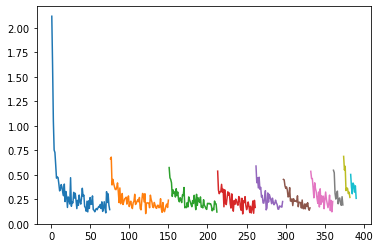

In [44]:
loss_plot(ewc_total_loss_optimised2)

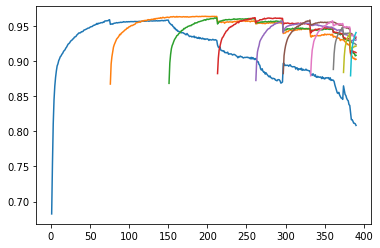

In [45]:
accuracy_plot(ewc_prec_optimised2)

In [46]:
lamda = 400
lr = 5.e-3
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised3 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised2)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised3, 
 ewc_total_loss_optimised3,
 ewc_ce_loss_optimised3, 
 ewc_ewc_loss_optimised3) =train(
    mlp_consolidation_optimised3, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.5859 | loss => ce: 2.106 / ewc: 0.0 / total: 2.106: : 375it [00:15, 23.87it/s]


Validation loss decreased (inf --> 2.088259).  Saving model ...


=> task: 1/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.6484 | loss => ce: 1.595 / ewc: 0.0 / total: 1.595: : 375it [00:15, 23.82it/s]


Validation loss decreased (2.088259 --> 1.572191).  Saving model ...


=> task: 1/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.7422 | loss => ce: 1.052 / ewc: 0.0 / total: 1.052: : 375it [00:15, 24.93it/s] 


Validation loss decreased (1.572191 --> 0.979688).  Saving model ...


=> task: 1/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8125 | loss => ce: 0.7669 / ewc: 0.0 / total: 0.7669: : 375it [00:15, 23.79it/s]


Validation loss decreased (0.979688 --> 0.702951).  Saving model ...


=> task: 1/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.6137 / ewc: 0.0 / total: 0.6137: : 375it [00:15, 24.05it/s]


Validation loss decreased (0.702951 --> 0.571692).  Saving model ...


=> task: 1/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.5992 / ewc: 0.0 / total: 0.5992: : 375it [00:15, 24.74it/s]


Validation loss decreased (0.571692 --> 0.499609).  Saving model ...


=> task: 1/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.5259 / ewc: 0.0 / total: 0.5259: : 375it [00:15, 23.90it/s]


Validation loss decreased (0.499609 --> 0.452951).  Saving model ...


=> task: 1/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3277 / ewc: 0.0 / total: 0.3277: : 375it [00:15, 24.29it/s]


Validation loss decreased (0.452951 --> 0.420219).  Saving model ...


=> task: 1/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.5416 / ewc: 0.0 / total: 0.5416: : 375it [00:15, 23.80it/s]


Validation loss decreased (0.420219 --> 0.395344).  Saving model ...


=> task: 1/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3396 / ewc: 0.0 / total: 0.3396: : 375it [00:15, 23.76it/s]


Validation loss decreased (0.395344 --> 0.376685).  Saving model ...


=> task: 1/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4892 / ewc: 0.0 / total: 0.4892: : 375it [00:15, 24.28it/s]


Validation loss decreased (0.376685 --> 0.361361).  Saving model ...


=> task: 1/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4218 / ewc: 0.0 / total: 0.4218: : 375it [00:15, 23.54it/s]


Validation loss decreased (0.361361 --> 0.348700).  Saving model ...


=> task: 1/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4039 / ewc: 0.0 / total: 0.4039: : 375it [00:16, 22.49it/s]


Validation loss decreased (0.348700 --> 0.338152).  Saving model ...


=> task: 1/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3205 / ewc: 0.0 / total: 0.3205: : 375it [00:15, 23.79it/s]


Validation loss decreased (0.338152 --> 0.328604).  Saving model ...


=> task: 1/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.304 / ewc: 0.0 / total: 0.304: : 375it [00:15, 24.21it/s]  


Validation loss decreased (0.328604 --> 0.319809).  Saving model ...


=> task: 1/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.3795 / ewc: 0.0 / total: 0.3795: : 375it [00:15, 23.85it/s]


Validation loss decreased (0.319809 --> 0.312808).  Saving model ...


=> task: 1/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3095 / ewc: 0.0 / total: 0.3095: : 375it [00:15, 24.09it/s]


Validation loss decreased (0.312808 --> 0.306713).  Saving model ...


=> task: 1/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3556 / ewc: 0.0 / total: 0.3556: : 375it [00:15, 23.45it/s]


Validation loss decreased (0.306713 --> 0.299232).  Saving model ...


=> task: 1/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4206 / ewc: 0.0 / total: 0.4206: : 375it [00:15, 24.36it/s]


Validation loss decreased (0.299232 --> 0.293961).  Saving model ...


=> task: 1/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.397 / ewc: 0.0 / total: 0.397: : 375it [00:16, 22.66it/s]  


Validation loss decreased (0.293961 --> 0.287312).  Saving model ...


=> task: 1/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2335 / ewc: 0.0 / total: 0.2335: : 375it [00:16, 22.86it/s]


Validation loss decreased (0.287312 --> 0.282731).  Saving model ...


=> task: 1/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2982 / ewc: 0.0 / total: 0.2982: : 375it [00:16, 23.18it/s]


Validation loss decreased (0.282731 --> 0.277787).  Saving model ...


=> task: 1/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2276 / ewc: 0.0 / total: 0.2276: : 375it [00:15, 24.29it/s]


Validation loss decreased (0.277787 --> 0.272729).  Saving model ...


=> task: 1/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3888 / ewc: 0.0 / total: 0.3888: : 375it [00:15, 24.72it/s]


Validation loss decreased (0.272729 --> 0.268324).  Saving model ...


=> task: 1/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2385 / ewc: 0.0 / total: 0.2385: : 375it [00:16, 23.27it/s]


Validation loss decreased (0.268324 --> 0.263486).  Saving model ...


=> task: 1/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4573 / ewc: 0.0 / total: 0.4573: : 375it [00:15, 24.20it/s]


Validation loss decreased (0.263486 --> 0.259616).  Saving model ...


=> task: 1/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3732 / ewc: 0.0 / total: 0.3732: : 375it [00:15, 24.21it/s]


Validation loss decreased (0.259616 --> 0.256096).  Saving model ...


=> task: 1/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3156 / ewc: 0.0 / total: 0.3156: : 375it [00:15, 24.59it/s]


Validation loss decreased (0.256096 --> 0.251663).  Saving model ...


=> task: 1/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3902 / ewc: 0.0 / total: 0.3902: : 375it [00:15, 24.34it/s]


Validation loss decreased (0.251663 --> 0.247841).  Saving model ...


=> task: 1/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.23 / ewc: 0.0 / total: 0.23: : 375it [00:15, 24.48it/s]    


Validation loss decreased (0.247841 --> 0.244800).  Saving model ...


=> task: 1/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2221 / ewc: 0.0 / total: 0.2221: : 375it [00:15, 24.41it/s]


Validation loss decreased (0.244800 --> 0.240104).  Saving model ...


=> task: 1/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1642 / ewc: 0.0 / total: 0.1642: : 375it [00:15, 24.23it/s]


Validation loss decreased (0.240104 --> 0.237277).  Saving model ...


=> task: 1/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2188 / ewc: 0.0 / total: 0.2188: : 375it [00:15, 24.36it/s]


Validation loss decreased (0.237277 --> 0.233653).  Saving model ...


=> task: 1/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2849 / ewc: 0.0 / total: 0.2849: : 375it [00:15, 24.44it/s]


Validation loss decreased (0.233653 --> 0.229723).  Saving model ...


=> task: 1/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3235 / ewc: 0.0 / total: 0.3235: : 375it [00:15, 24.26it/s]


Validation loss decreased (0.229723 --> 0.226356).  Saving model ...


=> task: 1/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1955 / ewc: 0.0 / total: 0.1955: : 375it [00:15, 24.48it/s]


Validation loss decreased (0.226356 --> 0.223847).  Saving model ...


=> task: 1/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2412 / ewc: 0.0 / total: 0.2412: : 375it [00:15, 24.32it/s]


Validation loss decreased (0.223847 --> 0.220209).  Saving model ...


=> task: 1/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2117 / ewc: 0.0 / total: 0.2117: : 375it [00:15, 24.43it/s] 


Validation loss decreased (0.220209 --> 0.217269).  Saving model ...


=> task: 1/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07951 / ewc: 0.0 / total: 0.07951: : 375it [00:15, 24.44it/s]


Validation loss decreased (0.217269 --> 0.214462).  Saving model ...


=> task: 1/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2441 / ewc: 0.0 / total: 0.2441: : 375it [00:13, 27.07it/s]


Validation loss decreased (0.214462 --> 0.212299).  Saving model ...


=> task: 1/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2376 / ewc: 0.0 / total: 0.2376: : 375it [00:14, 25.59it/s]


Validation loss decreased (0.212299 --> 0.209051).  Saving model ...


=> task: 1/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2769 / ewc: 0.0 / total: 0.2769: : 375it [00:15, 24.42it/s] 


Validation loss decreased (0.209051 --> 0.206029).  Saving model ...


=> task: 1/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2792 / ewc: 0.0 / total: 0.2792: : 375it [00:15, 24.31it/s] 


Validation loss decreased (0.206029 --> 0.203893).  Saving model ...


=> task: 1/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1233 / ewc: 0.0 / total: 0.1233: : 375it [00:15, 24.38it/s] 


Validation loss decreased (0.203893 --> 0.201062).  Saving model ...


=> task: 1/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2877 / ewc: 0.0 / total: 0.2877: : 375it [00:15, 24.44it/s] 


Validation loss decreased (0.201062 --> 0.198362).  Saving model ...


=> task: 1/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1758 / ewc: 0.0 / total: 0.1758: : 375it [00:15, 24.41it/s] 


Validation loss decreased (0.198362 --> 0.195983).  Saving model ...


=> task: 1/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2234 / ewc: 0.0 / total: 0.2234: : 375it [00:15, 24.37it/s] 


Validation loss decreased (0.195983 --> 0.193563).  Saving model ...


=> task: 1/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2 / ewc: 0.0 / total: 0.2: : 375it [00:15, 24.36it/s]       


Validation loss decreased (0.193563 --> 0.191170).  Saving model ...


=> task: 1/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2633 / ewc: 0.0 / total: 0.2633: : 375it [00:15, 24.31it/s] 


Validation loss decreased (0.191170 --> 0.189494).  Saving model ...


=> task: 1/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1955 / ewc: 0.0 / total: 0.1955: : 375it [00:15, 24.43it/s] 


Validation loss decreased (0.189494 --> 0.187268).  Saving model ...


=> task: 1/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2599 / ewc: 0.0 / total: 0.2599: : 375it [00:15, 24.34it/s] 


Validation loss decreased (0.187268 --> 0.184864).  Saving model ...


=> task: 1/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2007 / ewc: 0.0 / total: 0.2007: : 375it [00:15, 24.30it/s] 


Validation loss decreased (0.184864 --> 0.182379).  Saving model ...


=> task: 1/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1711 / ewc: 0.0 / total: 0.1711: : 375it [00:15, 24.46it/s] 


Validation loss decreased (0.182379 --> 0.180520).  Saving model ...


=> task: 1/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1186 / ewc: 0.0 / total: 0.1186: : 375it [00:15, 24.47it/s] 


Validation loss decreased (0.180520 --> 0.177900).  Saving model ...


=> task: 1/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1362 / ewc: 0.0 / total: 0.1362: : 375it [00:15, 24.40it/s] 


Validation loss decreased (0.177900 --> 0.176530).  Saving model ...


=> task: 1/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2471 / ewc: 0.0 / total: 0.2471: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.176530 --> 0.174357).  Saving model ...


=> task: 1/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1836 / ewc: 0.0 / total: 0.1836: : 375it [00:15, 24.85it/s] 


Validation loss decreased (0.174357 --> 0.172482).  Saving model ...


=> task: 1/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1797 / ewc: 0.0 / total: 0.1797: : 375it [00:15, 24.54it/s] 


Validation loss decreased (0.172482 --> 0.170999).  Saving model ...


=> task: 1/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2154 / ewc: 0.0 / total: 0.2154: : 375it [00:15, 24.47it/s] 


Validation loss decreased (0.170999 --> 0.168875).  Saving model ...


=> task: 1/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1343 / ewc: 0.0 / total: 0.1343: : 375it [00:15, 24.49it/s] 


Validation loss decreased (0.168875 --> 0.166965).  Saving model ...


=> task: 1/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.187 / ewc: 0.0 / total: 0.187: : 375it [00:15, 24.30it/s]   


Validation loss decreased (0.166965 --> 0.165417).  Saving model ...


=> task: 1/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1074 / ewc: 0.0 / total: 0.1074: : 375it [00:15, 24.48it/s] 


Validation loss decreased (0.165417 --> 0.164221).  Saving model ...


=> task: 1/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2073 / ewc: 0.0 / total: 0.2073: : 375it [00:15, 24.27it/s] 


Validation loss decreased (0.164221 --> 0.162403).  Saving model ...


=> task: 1/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.07408 / ewc: 0.0 / total: 0.07408: : 375it [00:15, 24.83it/s]


Validation loss decreased (0.162403 --> 0.160417).  Saving model ...


=> task: 1/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1261 / ewc: 0.0 / total: 0.1261: : 375it [00:15, 23.63it/s] 


Validation loss decreased (0.160417 --> 0.158570).  Saving model ...


=> task: 1/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1215 / ewc: 0.0 / total: 0.1215: : 375it [00:15, 24.17it/s]  


Validation loss decreased (0.158570 --> 0.157442).  Saving model ...


=> task: 1/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.185 / ewc: 0.0 / total: 0.185: : 375it [00:15, 24.29it/s]   


Validation loss decreased (0.157442 --> 0.156318).  Saving model ...


=> task: 1/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.188 / ewc: 0.0 / total: 0.188: : 375it [00:15, 24.08it/s]   


Validation loss decreased (0.156318 --> 0.154426).  Saving model ...


=> task: 1/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1207 / ewc: 0.0 / total: 0.1207: : 375it [00:15, 24.09it/s] 


Validation loss decreased (0.154426 --> 0.152973).  Saving model ...


=> task: 1/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1772 / ewc: 0.0 / total: 0.1772: : 375it [00:15, 24.23it/s]  


Validation loss decreased (0.152973 --> 0.151584).  Saving model ...


=> task: 1/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1938 / ewc: 0.0 / total: 0.1938: : 375it [00:15, 24.77it/s] 


Validation loss decreased (0.151584 --> 0.150086).  Saving model ...


=> task: 1/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08047 / ewc: 0.0 / total: 0.08047: : 375it [00:15, 24.17it/s]


Validation loss decreased (0.150086 --> 0.149114).  Saving model ...


=> task: 1/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1551 / ewc: 0.0 / total: 0.1551: : 375it [00:15, 24.20it/s] 


Validation loss decreased (0.149114 --> 0.147569).  Saving model ...


=> task: 1/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.152 / ewc: 0.0 / total: 0.152: : 375it [00:15, 24.51it/s]   


Validation loss decreased (0.147569 --> 0.146397).  Saving model ...


=> task: 1/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1087 / ewc: 0.0 / total: 0.1087: : 375it [00:15, 24.33it/s] 


Validation loss decreased (0.146397 --> 0.144852).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4639 / ewc: 0.02364 / total: 0.4875: : 375it [00:26, 14.03it/s]


Validation loss decreased (inf --> 0.333209).  Saving model ...


=> task: 2/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4721 / ewc: 0.03022 / total: 0.5023: : 375it [00:26, 14.39it/s]


Validation loss decreased (0.333209 --> 0.276254).  Saving model ...


=> task: 2/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.5051 / ewc: 0.0326 / total: 0.5377: : 375it [00:25, 14.52it/s] 


Validation loss decreased (0.276254 --> 0.251292).  Saving model ...


=> task: 2/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2363 / ewc: 0.03342 / total: 0.2697: : 375it [00:26, 14.40it/s]


Validation loss decreased (0.251292 --> 0.237522).  Saving model ...


=> task: 2/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2899 / ewc: 0.0338 / total: 0.3237: : 375it [00:25, 14.46it/s] 


Validation loss decreased (0.237522 --> 0.228137).  Saving model ...


=> task: 2/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3144 / ewc: 0.03378 / total: 0.3481: : 375it [00:25, 14.76it/s]


Validation loss decreased (0.228137 --> 0.220857).  Saving model ...


=> task: 2/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1985 / ewc: 0.03359 / total: 0.2321: : 375it [00:25, 14.48it/s]


Validation loss decreased (0.220857 --> 0.214239).  Saving model ...


=> task: 2/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3015 / ewc: 0.03345 / total: 0.3349: : 375it [00:25, 14.47it/s]


Validation loss decreased (0.214239 --> 0.209452).  Saving model ...


=> task: 2/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2849 / ewc: 0.03312 / total: 0.318: : 375it [00:25, 14.51it/s] 


Validation loss decreased (0.209452 --> 0.205174).  Saving model ...


=> task: 2/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3054 / ewc: 0.03285 / total: 0.3383: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.205174 --> 0.202076).  Saving model ...


=> task: 2/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2903 / ewc: 0.03254 / total: 0.3229: : 375it [00:26, 14.21it/s]


Validation loss decreased (0.202076 --> 0.198728).  Saving model ...


=> task: 2/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3752 / ewc: 0.0322 / total: 0.4074: : 375it [00:26, 14.29it/s] 


Validation loss decreased (0.198728 --> 0.195245).  Saving model ...


=> task: 2/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2997 / ewc: 0.03197 / total: 0.3316: : 375it [00:26, 14.33it/s]


Validation loss decreased (0.195245 --> 0.192702).  Saving model ...


=> task: 2/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2566 / ewc: 0.03167 / total: 0.2882: : 375it [00:26, 14.30it/s]


Validation loss decreased (0.192702 --> 0.189708).  Saving model ...


=> task: 2/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3664 / ewc: 0.03144 / total: 0.3979: : 375it [00:26, 14.23it/s]


Validation loss decreased (0.189708 --> 0.188455).  Saving model ...


=> task: 2/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3032 / ewc: 0.03112 / total: 0.3343: : 375it [00:25, 14.45it/s]


Validation loss decreased (0.188455 --> 0.184796).  Saving model ...


=> task: 2/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.148 / ewc: 0.03091 / total: 0.1789: : 375it [00:24, 15.00it/s] 


Validation loss decreased (0.184796 --> 0.182872).  Saving model ...


=> task: 2/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1668 / ewc: 0.03066 / total: 0.1974: : 375it [00:26, 14.14it/s]


Validation loss decreased (0.182872 --> 0.181405).  Saving model ...


=> task: 2/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2114 / ewc: 0.03048 / total: 0.2419: : 375it [00:26, 14.32it/s]


Validation loss decreased (0.181405 --> 0.179452).  Saving model ...


=> task: 2/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2624 / ewc: 0.03029 / total: 0.2927: : 375it [00:26, 14.02it/s]


Validation loss decreased (0.179452 --> 0.177333).  Saving model ...


=> task: 2/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2026 / ewc: 0.03007 / total: 0.2327: : 375it [00:26, 14.04it/s]


Validation loss decreased (0.177333 --> 0.175908).  Saving model ...


=> task: 2/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2081 / ewc: 0.02988 / total: 0.238: : 375it [00:26, 14.11it/s] 


Validation loss decreased (0.175908 --> 0.174169).  Saving model ...


=> task: 2/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2142 / ewc: 0.02967 / total: 0.2438: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.174169 --> 0.172910).  Saving model ...


=> task: 2/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1153 / ewc: 0.02954 / total: 0.1449: : 375it [00:26, 14.03it/s]


Validation loss decreased (0.172910 --> 0.171749).  Saving model ...


=> task: 2/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2323 / ewc: 0.0294 / total: 0.2617: : 375it [00:26, 14.14it/s] 


Validation loss decreased (0.171749 --> 0.170198).  Saving model ...


=> task: 2/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2925 / ewc: 0.02922 / total: 0.3217: : 375it [00:26, 14.08it/s]


Validation loss decreased (0.170198 --> 0.168806).  Saving model ...


=> task: 2/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2007 / ewc: 0.02909 / total: 0.2298: : 375it [00:26, 13.99it/s]


Validation loss decreased (0.168806 --> 0.167820).  Saving model ...


=> task: 2/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2017 / ewc: 0.02895 / total: 0.2307: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.167820 --> 0.166248).  Saving model ...


=> task: 2/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1999 / ewc: 0.02882 / total: 0.2288: : 375it [00:26, 14.01it/s]


Validation loss decreased (0.166248 --> 0.165610).  Saving model ...


=> task: 2/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1765 / ewc: 0.02862 / total: 0.2051: : 375it [00:26, 14.00it/s]


Validation loss decreased (0.165610 --> 0.164157).  Saving model ...


=> task: 2/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3235 / ewc: 0.02852 / total: 0.3521: : 375it [00:26, 14.07it/s] 


Validation loss decreased (0.164157 --> 0.163280).  Saving model ...


=> task: 2/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2741 / ewc: 0.02839 / total: 0.3025: : 375it [00:25, 14.57it/s]


Validation loss decreased (0.163280 --> 0.162554).  Saving model ...


=> task: 2/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1758 / ewc: 0.0283 / total: 0.2041: : 375it [00:26, 13.92it/s] 


Validation loss decreased (0.162554 --> 0.161592).  Saving model ...


=> task: 2/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1471 / ewc: 0.02819 / total: 0.1753: : 375it [00:26, 14.22it/s]


Validation loss decreased (0.161592 --> 0.160779).  Saving model ...


=> task: 2/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1457 / ewc: 0.02804 / total: 0.1737: : 375it [00:25, 14.49it/s] 


Validation loss decreased (0.160779 --> 0.160371).  Saving model ...


=> task: 2/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1396 / ewc: 0.02793 / total: 0.1675: : 375it [00:25, 14.44it/s]


Validation loss decreased (0.160371 --> 0.159130).  Saving model ...


=> task: 2/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1744 / ewc: 0.02782 / total: 0.2022: : 375it [00:26, 14.14it/s]


Validation loss decreased (0.159130 --> 0.158220).  Saving model ...


=> task: 2/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1496 / ewc: 0.02773 / total: 0.1773: : 375it [00:26, 13.98it/s]


Validation loss decreased (0.158220 --> 0.157715).  Saving model ...


=> task: 2/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2076 / ewc: 0.02766 / total: 0.2352: : 375it [00:26, 14.14it/s]


Validation loss decreased (0.157715 --> 0.156930).  Saving model ...


=> task: 2/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1637 / ewc: 0.02752 / total: 0.1913: : 375it [00:26, 14.09it/s]


Validation loss decreased (0.156930 --> 0.155902).  Saving model ...


=> task: 2/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1371 / ewc: 0.02744 / total: 0.1645: : 375it [00:26, 13.98it/s]


Validation loss decreased (0.155902 --> 0.155698).  Saving model ...


=> task: 2/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.186 / ewc: 0.02733 / total: 0.2133: : 375it [00:26, 13.95it/s] 


Validation loss decreased (0.155698 --> 0.155002).  Saving model ...


=> task: 2/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1323 / ewc: 0.02726 / total: 0.1595: : 375it [00:26, 13.98it/s] 


Validation loss decreased (0.155002 --> 0.154472).  Saving model ...


=> task: 2/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1494 / ewc: 0.02718 / total: 0.1765: : 375it [00:26, 14.22it/s] 


Validation loss decreased (0.154472 --> 0.153472).  Saving model ...


=> task: 2/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.133 / ewc: 0.02713 / total: 0.1601: : 375it [00:26, 13.93it/s] 


Validation loss decreased (0.153472 --> 0.152980).  Saving model ...


=> task: 2/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1714 / ewc: 0.02705 / total: 0.1985: : 375it [00:26, 14.11it/s] 


Validation loss decreased (0.152980 --> 0.152223).  Saving model ...


=> task: 2/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1614 / ewc: 0.02693 / total: 0.1884: : 375it [00:25, 14.75it/s] 


Validation loss decreased (0.152223 --> 0.151495).  Saving model ...


=> task: 2/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1498 / ewc: 0.02686 / total: 0.1767: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.151495 --> 0.151138).  Saving model ...


=> task: 2/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1643 / ewc: 0.0268 / total: 0.1911: : 375it [00:26, 14.01it/s]  


Validation loss decreased (0.151138 --> 0.150321).  Saving model ...


=> task: 2/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1795 / ewc: 0.0267 / total: 0.2061: : 375it [00:26, 14.29it/s]  


Validation loss decreased (0.150321 --> 0.149697).  Saving model ...


=> task: 2/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1456 / ewc: 0.02663 / total: 0.1722: : 375it [00:26, 13.97it/s] 


Validation loss decreased (0.149697 --> 0.149501).  Saving model ...


=> task: 2/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2229 / ewc: 0.02654 / total: 0.2494: : 375it [00:23, 15.99it/s] 


Validation loss decreased (0.149501 --> 0.148987).  Saving model ...


=> task: 2/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.175 / ewc: 0.02648 / total: 0.2015: : 375it [00:26, 14.22it/s]  


Validation loss decreased (0.148987 --> 0.148547).  Saving model ...


=> task: 2/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2321 / ewc: 0.02638 / total: 0.2584: : 375it [00:26, 14.01it/s] 


Validation loss decreased (0.148547 --> 0.147602).  Saving model ...


=> task: 2/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1788 / ewc: 0.02635 / total: 0.2051: : 375it [00:26, 14.15it/s] 


Validation loss decreased (0.147602 --> 0.147187).  Saving model ...


=> task: 2/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1229 / ewc: 0.02627 / total: 0.1491: : 375it [00:26, 14.02it/s]


Validation loss decreased (0.147187 --> 0.146840).  Saving model ...


=> task: 2/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1003 / ewc: 0.02621 / total: 0.1265: : 375it [00:26, 14.01it/s] 


Validation loss decreased (0.146840 --> 0.146537).  Saving model ...


=> task: 2/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1609 / ewc: 0.02615 / total: 0.1871: : 375it [00:26, 14.07it/s] 


Validation loss decreased (0.146537 --> 0.145786).  Saving model ...


=> task: 2/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1396 / ewc: 0.02609 / total: 0.1657: : 375it [00:26, 14.15it/s] 


Validation loss decreased (0.145786 --> 0.145735).  Saving model ...


=> task: 2/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2443 / ewc: 0.02601 / total: 0.2703: : 375it [00:26, 14.00it/s] 


Validation loss decreased (0.145735 --> 0.145254).  Saving model ...


=> task: 2/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1328 / ewc: 0.02596 / total: 0.1588: : 375it [00:26, 14.02it/s]


Validation loss decreased (0.145254 --> 0.144615).  Saving model ...


=> task: 2/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1647 / ewc: 0.02591 / total: 0.1906: : 375it [00:26, 14.17it/s]


Validation loss decreased (0.144615 --> 0.144220).  Saving model ...


=> task: 2/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1123 / ewc: 0.02586 / total: 0.1382: : 375it [00:26, 13.95it/s] 


Validation loss decreased (0.144220 --> 0.144121).  Saving model ...


=> task: 2/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1081 / ewc: 0.0258 / total: 0.1339: : 375it [00:25, 14.62it/s]  


Validation loss decreased (0.144121 --> 0.143560).  Saving model ...


=> task: 2/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1392 / ewc: 0.02577 / total: 0.165: : 375it [00:26, 14.11it/s]  


Validation loss decreased (0.143560 --> 0.143541).  Saving model ...


=> task: 2/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1654 / ewc: 0.02571 / total: 0.1911: : 375it [00:26, 13.97it/s] 


Validation loss decreased (0.143541 --> 0.142741).  Saving model ...


=> task: 2/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08385 / ewc: 0.02563 / total: 0.1095: : 375it [00:26, 14.00it/s]


Validation loss decreased (0.142741 --> 0.142437).  Saving model ...


=> task: 2/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2175 / ewc: 0.0256 / total: 0.2431: : 375it [00:26, 13.91it/s]  


Validation loss decreased (0.142437 --> 0.142120).  Saving model ...


=> task: 2/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2411 / ewc: 0.02554 / total: 0.2666: : 375it [00:26, 14.03it/s] 


Validation loss decreased (0.142120 --> 0.142099).  Saving model ...


=> task: 2/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1142 / ewc: 0.0255 / total: 0.1397: : 375it [00:24, 15.17it/s]  


Validation loss decreased (0.142099 --> 0.141616).  Saving model ...


=> task: 2/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1209 / ewc: 0.02544 / total: 0.1463: : 375it [00:26, 14.19it/s] 


Validation loss decreased (0.141616 --> 0.141451).  Saving model ...


=> task: 2/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1611 / ewc: 0.02537 / total: 0.1864: : 375it [00:26, 14.06it/s] 


Validation loss decreased (0.141451 --> 0.140381).  Saving model ...


=> task: 2/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1533 / ewc: 0.02532 / total: 0.1786: : 375it [00:26, 14.02it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1188 / ewc: 0.02526 / total: 0.144: : 375it [00:26, 13.94it/s]  


Validation loss decreased (0.140381 --> 0.140169).  Saving model ...


=> task: 2/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1051 / ewc: 0.02522 / total: 0.1303: : 375it [00:26, 14.14it/s] 


Validation loss decreased (0.140169 --> 0.139976).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.587 / ewc: 0.027 / total: 0.614: : 375it [00:28, 13.00it/s]   


Validation loss decreased (inf --> 0.263272).  Saving model ...


=> task: 3/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3707 / ewc: 0.03313 / total: 0.4038: : 375it [00:27, 13.43it/s]


Validation loss decreased (0.263272 --> 0.227651).  Saving model ...


=> task: 3/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.367 / ewc: 0.03504 / total: 0.402: : 375it [00:27, 13.57it/s]  


Validation loss decreased (0.227651 --> 0.214218).  Saving model ...


=> task: 3/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4333 / ewc: 0.03545 / total: 0.4687: : 375it [00:27, 13.70it/s]


Validation loss decreased (0.214218 --> 0.206094).  Saving model ...


=> task: 3/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3162 / ewc: 0.03533 / total: 0.3515: : 375it [00:27, 13.61it/s]


Validation loss decreased (0.206094 --> 0.200147).  Saving model ...


=> task: 3/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2945 / ewc: 0.03494 / total: 0.3294: : 375it [00:27, 13.66it/s]


Validation loss decreased (0.200147 --> 0.196840).  Saving model ...


=> task: 3/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3156 / ewc: 0.03452 / total: 0.3502: : 375it [00:27, 13.50it/s]


Validation loss decreased (0.196840 --> 0.193222).  Saving model ...


=> task: 3/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2602 / ewc: 0.03404 / total: 0.2943: : 375it [00:27, 13.61it/s]


Validation loss decreased (0.193222 --> 0.191458).  Saving model ...


=> task: 3/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.3412 / ewc: 0.03354 / total: 0.3747: : 375it [00:28, 13.37it/s]


Validation loss decreased (0.191458 --> 0.188973).  Saving model ...


=> task: 3/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2118 / ewc: 0.03308 / total: 0.2449: : 375it [00:26, 13.91it/s]


Validation loss decreased (0.188973 --> 0.187454).  Saving model ...


=> task: 3/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2262 / ewc: 0.0326 / total: 0.2588: : 375it [00:27, 13.64it/s]


Validation loss decreased (0.187454 --> 0.185642).  Saving model ...


=> task: 3/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.2909 / ewc: 0.0322 / total: 0.3231: : 375it [00:27, 13.77it/s]


Validation loss decreased (0.185642 --> 0.183570).  Saving model ...


=> task: 3/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2302 / ewc: 0.03177 / total: 0.262: : 375it [00:27, 13.41it/s] 


Validation loss decreased (0.183570 --> 0.183083).  Saving model ...


=> task: 3/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2161 / ewc: 0.03143 / total: 0.2476: : 375it [00:27, 13.57it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1403 / ewc: 0.031 / total: 0.1713: : 375it [00:27, 13.81it/s]  


Validation loss decreased (0.183083 --> 0.181183).  Saving model ...


=> task: 3/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2363 / ewc: 0.03066 / total: 0.2669: : 375it [00:27, 13.54it/s]


Validation loss decreased (0.181183 --> 0.179698).  Saving model ...


=> task: 3/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1455 / ewc: 0.03033 / total: 0.1758: : 375it [00:27, 13.41it/s]


Validation loss decreased (0.179698 --> 0.179338).  Saving model ...


=> task: 3/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1525 / ewc: 0.02998 / total: 0.1825: : 375it [00:27, 13.64it/s]


Validation loss decreased (0.179338 --> 0.179299).  Saving model ...


=> task: 3/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2105 / ewc: 0.02971 / total: 0.2402: : 375it [00:27, 13.73it/s]


Validation loss decreased (0.179299 --> 0.177629).  Saving model ...


=> task: 3/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1787 / ewc: 0.02941 / total: 0.2081: : 375it [00:27, 13.50it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2864 / ewc: 0.02918 / total: 0.3156: : 375it [00:27, 13.72it/s]


Validation loss decreased (0.177629 --> 0.177532).  Saving model ...


=> task: 3/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3077 / ewc: 0.02892 / total: 0.3366: : 375it [00:27, 13.56it/s]


Validation loss decreased (0.177532 --> 0.177283).  Saving model ...


=> task: 3/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1041 / ewc: 0.0287 / total: 0.1328: : 375it [00:27, 13.69it/s] 


Validation loss decreased (0.177283 --> 0.175152).  Saving model ...


=> task: 3/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2204 / ewc: 0.02844 / total: 0.2488: : 375it [00:27, 13.67it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1224 / ewc: 0.0282 / total: 0.1506: : 375it [00:27, 13.63it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1434 / ewc: 0.02796 / total: 0.1713: : 375it [00:27, 13.54it/s]


Validation loss decreased (0.175152 --> 0.174697).  Saving model ...


=> task: 3/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1103 / ewc: 0.02776 / total: 0.138: : 375it [00:27, 13.75it/s] 


Validation loss decreased (0.174697 --> 0.173997).  Saving model ...


=> task: 3/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1761 / ewc: 0.02758 / total: 0.2037: : 375it [00:27, 13.54it/s]


Validation loss decreased (0.173997 --> 0.173788).  Saving model ...


=> task: 3/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2601 / ewc: 0.02739 / total: 0.2875: : 375it [00:27, 13.44it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2005 / ewc: 0.02721 / total: 0.2277: : 375it [00:27, 13.46it/s]


Validation loss decreased (0.173788 --> 0.173332).  Saving model ...


=> task: 3/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1634 / ewc: 0.02702 / total: 0.1905: : 375it [00:27, 13.41it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1288 / ewc: 0.02688 / total: 0.1557: : 375it [00:27, 13.56it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1037 / ewc: 0.02671 / total: 0.1304: : 375it [00:27, 13.43it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2185 / ewc: 0.02657 / total: 0.245: : 375it [00:27, 13.44it/s]  


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1921 / ewc: 0.02641 / total: 0.2185: : 375it [00:27, 13.50it/s]


Validation loss decreased (0.173332 --> 0.171819).  Saving model ...


=> task: 3/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2405 / ewc: 0.02626 / total: 0.2668: : 375it [00:27, 13.66it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2216 / ewc: 0.02611 / total: 0.2477: : 375it [00:27, 13.47it/s]


Validation loss decreased (0.171819 --> 0.171793).  Saving model ...


=> task: 3/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1687 / ewc: 0.02599 / total: 0.1947: : 375it [00:27, 13.64it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1145 / ewc: 0.02584 / total: 0.1404: : 375it [00:27, 13.45it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1052 / ewc: 0.02572 / total: 0.1309: : 375it [00:27, 13.54it/s] 


Validation loss decreased (0.171793 --> 0.171369).  Saving model ...


=> task: 3/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1552 / ewc: 0.02558 / total: 0.1808: : 375it [00:28, 13.31it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1147 / ewc: 0.02549 / total: 0.1402: : 375it [00:27, 13.52it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0868 / ewc: 0.02538 / total: 0.1122: : 375it [00:28, 13.36it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09888 / ewc: 0.02527 / total: 0.1242: : 375it [00:28, 13.37it/s]


Validation loss decreased (0.171369 --> 0.170747).  Saving model ...


=> task: 3/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1414 / ewc: 0.02515 / total: 0.1665: : 375it [00:28, 13.27it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0868 / ewc: 0.02506 / total: 0.1119: : 375it [00:28, 13.27it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08826 / ewc: 0.02496 / total: 0.1132: : 375it [00:27, 13.46it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.0896 / ewc: 0.02486 / total: 0.1145: : 375it [00:27, 13.57it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2002 / ewc: 0.02477 / total: 0.2249: : 375it [00:28, 13.37it/s] 


Validation loss decreased (0.170747 --> 0.170614).  Saving model ...


=> task: 3/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1962 / ewc: 0.02469 / total: 0.2208: : 375it [00:28, 13.34it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1273 / ewc: 0.02458 / total: 0.1519: : 375it [00:27, 13.62it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1092 / ewc: 0.02448 / total: 0.1336: : 375it [00:27, 13.45it/s] 


Validation loss decreased (0.170614 --> 0.170074).  Saving model ...


=> task: 3/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1056 / ewc: 0.0244 / total: 0.13: : 375it [00:28, 13.37it/s]    


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1157 / ewc: 0.02431 / total: 0.14: : 375it [00:27, 13.49it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1045 / ewc: 0.02423 / total: 0.1287: : 375it [00:28, 13.39it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.123 / ewc: 0.02416 / total: 0.1472: : 375it [00:27, 13.43it/s]  


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1548 / ewc: 0.02408 / total: 0.1789: : 375it [00:27, 13.48it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.417 / ewc: 0.02672 / total: 0.4438: : 375it [00:28, 13.09it/s] 


Validation loss decreased (inf --> 0.249486).  Saving model ...


=> task: 4/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.389 / ewc: 0.03085 / total: 0.4198: : 375it [00:27, 13.45it/s] 


Validation loss decreased (0.249486 --> 0.227428).  Saving model ...


=> task: 4/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2507 / ewc: 0.03171 / total: 0.2824: : 375it [00:27, 13.68it/s]


Validation loss decreased (0.227428 --> 0.216321).  Saving model ...


=> task: 4/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3397 / ewc: 0.03142 / total: 0.3711: : 375it [00:28, 13.38it/s]


Validation loss decreased (0.216321 --> 0.209885).  Saving model ...


=> task: 4/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2945 / ewc: 0.03087 / total: 0.3253: : 375it [00:27, 13.48it/s]


Validation loss decreased (0.209885 --> 0.205284).  Saving model ...


=> task: 4/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2978 / ewc: 0.03028 / total: 0.3281: : 375it [00:27, 13.66it/s]


Validation loss decreased (0.205284 --> 0.204391).  Saving model ...


=> task: 4/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2584 / ewc: 0.02969 / total: 0.2881: : 375it [00:27, 13.56it/s]


Validation loss decreased (0.204391 --> 0.201232).  Saving model ...


=> task: 4/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2505 / ewc: 0.02904 / total: 0.2795: : 375it [00:27, 13.53it/s]


Validation loss decreased (0.201232 --> 0.198409).  Saving model ...


=> task: 4/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2343 / ewc: 0.0285 / total: 0.2628: : 375it [00:27, 13.43it/s]


Validation loss decreased (0.198409 --> 0.197576).  Saving model ...


=> task: 4/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1917 / ewc: 0.02795 / total: 0.2196: : 375it [00:28, 13.19it/s]


Validation loss decreased (0.197576 --> 0.195886).  Saving model ...


=> task: 4/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1702 / ewc: 0.02744 / total: 0.1976: : 375it [00:28, 13.30it/s]


Validation loss decreased (0.195886 --> 0.193480).  Saving model ...


=> task: 4/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1512 / ewc: 0.02698 / total: 0.1782: : 375it [00:27, 13.54it/s]


Validation loss decreased (0.193480 --> 0.192732).  Saving model ...


=> task: 4/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.191 / ewc: 0.02654 / total: 0.2175: : 375it [00:28, 13.24it/s] 


Validation loss decreased (0.192732 --> 0.192536).  Saving model ...


=> task: 4/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.171 / ewc: 0.02614 / total: 0.1972: : 375it [00:27, 13.54it/s]


Validation loss decreased (0.192536 --> 0.192471).  Saving model ...


=> task: 4/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2659 / ewc: 0.02578 / total: 0.2916: : 375it [00:28, 13.39it/s]


Validation loss decreased (0.192471 --> 0.191025).  Saving model ...


=> task: 4/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1685 / ewc: 0.02544 / total: 0.194: : 375it [00:28, 13.14it/s] 


Validation loss decreased (0.191025 --> 0.189819).  Saving model ...


=> task: 4/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1679 / ewc: 0.0251 / total: 0.193: : 375it [00:27, 13.49it/s]  


Validation loss decreased (0.189819 --> 0.189143).  Saving model ...


=> task: 4/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1579 / ewc: 0.02481 / total: 0.1827: : 375it [00:28, 13.33it/s]


Validation loss decreased (0.189143 --> 0.189030).  Saving model ...


=> task: 4/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2139 / ewc: 0.02451 / total: 0.2384: : 375it [00:28, 13.24it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3481 / ewc: 0.02424 / total: 0.3723: : 375it [00:28, 13.28it/s]


Validation loss decreased (0.189030 --> 0.187918).  Saving model ...


=> task: 4/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2295 / ewc: 0.02396 / total: 0.2535: : 375it [00:28, 13.38it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1261 / ewc: 0.02371 / total: 0.1498: : 375it [00:27, 13.47it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1857 / ewc: 0.0235 / total: 0.2092: : 375it [00:28, 13.24it/s]  


Validation loss decreased (0.187918 --> 0.187462).  Saving model ...


=> task: 4/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1948 / ewc: 0.02326 / total: 0.218: : 375it [00:28, 13.34it/s] 


Validation loss decreased (0.187462 --> 0.186726).  Saving model ...


=> task: 4/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1861 / ewc: 0.02305 / total: 0.2091: : 375it [00:28, 13.26it/s]


Validation loss decreased (0.186726 --> 0.185426).  Saving model ...


=> task: 4/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2541 / ewc: 0.02284 / total: 0.277: : 375it [00:27, 13.70it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1974 / ewc: 0.02265 / total: 0.22: : 375it [00:27, 13.88it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1743 / ewc: 0.02249 / total: 0.1968: : 375it [00:26, 13.95it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1209 / ewc: 0.02231 / total: 0.1432: : 375it [00:26, 14.20it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.195 / ewc: 0.02218 / total: 0.2172: : 375it [00:26, 14.03it/s]  


Validation loss decreased (0.185426 --> 0.185169).  Saving model ...


=> task: 4/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1576 / ewc: 0.022 / total: 0.1796: : 375it [00:27, 13.87it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1871 / ewc: 0.02185 / total: 0.2089: : 375it [00:26, 14.04it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09652 / ewc: 0.02168 / total: 0.1182: : 375it [00:26, 13.96it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1428 / ewc: 0.02153 / total: 0.1644: : 375it [00:26, 14.00it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2189 / ewc: 0.02139 / total: 0.2403: : 375it [00:26, 14.04it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3922 / ewc: 0.04328 / total: 0.4355: : 375it [00:26, 14.14it/s]


Validation loss decreased (inf --> 0.243128).  Saving model ...


=> task: 5/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4228 / ewc: 0.04501 / total: 0.4678: : 375it [00:26, 14.35it/s]


Validation loss decreased (0.243128 --> 0.225665).  Saving model ...


=> task: 5/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.5525 / ewc: 0.04309 / total: 0.5955: : 375it [00:25, 14.52it/s]


Validation loss decreased (0.225665 --> 0.219265).  Saving model ...


=> task: 5/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3028 / ewc: 0.04091 / total: 0.3437: : 375it [00:26, 14.42it/s]


Validation loss decreased (0.219265 --> 0.215257).  Saving model ...


=> task: 5/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3355 / ewc: 0.03877 / total: 0.3743: : 375it [00:26, 14.37it/s]


Validation loss decreased (0.215257 --> 0.211981).  Saving model ...


=> task: 5/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3459 / ewc: 0.03693 / total: 0.3828: : 375it [00:26, 14.39it/s]


Validation loss decreased (0.211981 --> 0.209359).  Saving model ...


=> task: 5/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3198 / ewc: 0.03542 / total: 0.3553: : 375it [00:25, 14.50it/s]


Validation loss decreased (0.209359 --> 0.206936).  Saving model ...


=> task: 5/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2805 / ewc: 0.03415 / total: 0.3147: : 375it [00:26, 14.12it/s]


Validation loss decreased (0.206936 --> 0.206796).  Saving model ...


=> task: 5/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1835 / ewc: 0.03308 / total: 0.2166: : 375it [00:26, 14.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2481 / ewc: 0.03207 / total: 0.2801: : 375it [00:26, 14.07it/s]


Validation loss decreased (0.206796 --> 0.205120).  Saving model ...


=> task: 5/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3763 / ewc: 0.03115 / total: 0.4074: : 375it [00:26, 14.11it/s]


Validation loss decreased (0.205120 --> 0.204948).  Saving model ...


=> task: 5/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2225 / ewc: 0.03039 / total: 0.2529: : 375it [00:26, 14.05it/s]


Validation loss decreased (0.204948 --> 0.203751).  Saving model ...


=> task: 5/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3319 / ewc: 0.02969 / total: 0.3616: : 375it [00:26, 14.17it/s]


Validation loss decreased (0.203751 --> 0.203550).  Saving model ...


=> task: 5/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1421 / ewc: 0.02902 / total: 0.1711: : 375it [00:26, 14.07it/s]


Validation loss decreased (0.203550 --> 0.202159).  Saving model ...


=> task: 5/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.195 / ewc: 0.02844 / total: 0.2234: : 375it [00:26, 14.04it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1597 / ewc: 0.02791 / total: 0.1876: : 375it [00:26, 14.21it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1557 / ewc: 0.02743 / total: 0.1831: : 375it [00:26, 14.00it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1801 / ewc: 0.027 / total: 0.2071: : 375it [00:27, 13.86it/s]  


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1321 / ewc: 0.0266 / total: 0.1587: : 375it [00:26, 14.23it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4096 / ewc: 0.04112 / total: 0.4508: : 375it [00:26, 14.02it/s] 


Validation loss decreased (inf --> 0.257458).  Saving model ...


=> task: 6/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4067 / ewc: 0.04265 / total: 0.4494: : 375it [00:25, 14.54it/s] 


Validation loss decreased (0.257458 --> 0.239501).  Saving model ...


=> task: 6/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4171 / ewc: 0.04086 / total: 0.4579: : 375it [00:25, 14.50it/s]


Validation loss decreased (0.239501 --> 0.230173).  Saving model ...


=> task: 6/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.3586 / ewc: 0.03872 / total: 0.3974: : 375it [00:25, 14.58it/s]


Validation loss decreased (0.230173 --> 0.225731).  Saving model ...


=> task: 6/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1748 / ewc: 0.03677 / total: 0.2116: : 375it [00:25, 14.56it/s]


Validation loss decreased (0.225731 --> 0.221478).  Saving model ...


=> task: 6/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2107 / ewc: 0.03523 / total: 0.2459: : 375it [00:26, 14.42it/s]


Validation loss decreased (0.221478 --> 0.219169).  Saving model ...


=> task: 6/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3017 / ewc: 0.03389 / total: 0.3356: : 375it [00:25, 14.47it/s]


Validation loss decreased (0.219169 --> 0.216316).  Saving model ...


=> task: 6/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2787 / ewc: 0.03264 / total: 0.3114: : 375it [00:26, 14.37it/s]


Validation loss decreased (0.216316 --> 0.213336).  Saving model ...


=> task: 6/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2208 / ewc: 0.03168 / total: 0.2525: : 375it [00:26, 14.38it/s]


Validation loss decreased (0.213336 --> 0.212166).  Saving model ...


=> task: 6/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2379 / ewc: 0.03077 / total: 0.2686: : 375it [00:26, 14.22it/s]


Validation loss decreased (0.212166 --> 0.210545).  Saving model ...


=> task: 6/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2396 / ewc: 0.02996 / total: 0.2696: : 375it [00:26, 14.37it/s]


Validation loss decreased (0.210545 --> 0.210163).  Saving model ...


=> task: 6/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.2253 / ewc: 0.02927 / total: 0.2546: : 375it [00:26, 14.24it/s]


Validation loss decreased (0.210163 --> 0.208002).  Saving model ...


=> task: 6/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.203 / ewc: 0.02861 / total: 0.2316: : 375it [00:26, 14.36it/s] 


Validation loss decreased (0.208002 --> 0.207328).  Saving model ...


=> task: 6/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09693 / ewc: 0.02798 / total: 0.1249: : 375it [00:26, 14.32it/s]


Validation loss decreased (0.207328 --> 0.206906).  Saving model ...


=> task: 6/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1025 / ewc: 0.02751 / total: 0.13: : 375it [00:26, 14.21it/s]  


Validation loss decreased (0.206906 --> 0.205985).  Saving model ...


=> task: 6/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2598 / ewc: 0.02699 / total: 0.2868: : 375it [00:26, 14.18it/s]


Validation loss decreased (0.205985 --> 0.204693).  Saving model ...


=> task: 6/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1589 / ewc: 0.02654 / total: 0.1854: : 375it [00:26, 14.26it/s]


Validation loss decreased (0.204693 --> 0.204348).  Saving model ...


=> task: 6/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2575 / ewc: 0.02618 / total: 0.2837: : 375it [00:26, 14.06it/s]


Validation loss decreased (0.204348 --> 0.203796).  Saving model ...


=> task: 6/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1865 / ewc: 0.02577 / total: 0.2123: : 375it [00:26, 14.03it/s]


Validation loss decreased (0.203796 --> 0.203460).  Saving model ...


=> task: 6/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.193 / ewc: 0.02539 / total: 0.2184: : 375it [00:26, 14.25it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2463 / ewc: 0.02503 / total: 0.2714: : 375it [00:26, 14.24it/s]


Validation loss decreased (0.203460 --> 0.202813).  Saving model ...


=> task: 6/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1169 / ewc: 0.02464 / total: 0.1416: : 375it [00:26, 13.89it/s]


Validation loss decreased (0.202813 --> 0.202210).  Saving model ...


=> task: 6/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1519 / ewc: 0.02435 / total: 0.1762: : 375it [00:29, 12.78it/s]


Validation loss decreased (0.202210 --> 0.202193).  Saving model ...


=> task: 6/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1779 / ewc: 0.02411 / total: 0.202: : 375it [00:28, 13.08it/s]  


Validation loss decreased (0.202193 --> 0.201424).  Saving model ...


=> task: 6/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1381 / ewc: 0.02385 / total: 0.1619: : 375it [00:27, 13.52it/s]


Validation loss decreased (0.201424 --> 0.201282).  Saving model ...


=> task: 6/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1093 / ewc: 0.0236 / total: 0.1329: : 375it [00:27, 13.67it/s]  


Validation loss decreased (0.201282 --> 0.201239).  Saving model ...


=> task: 6/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2861 / ewc: 0.02334 / total: 0.3094: : 375it [00:27, 13.67it/s]


Validation loss decreased (0.201239 --> 0.201114).  Saving model ...


=> task: 6/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1306 / ewc: 0.02308 / total: 0.1537: : 375it [00:27, 13.42it/s]


Validation loss decreased (0.201114 --> 0.200373).  Saving model ...


=> task: 6/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2063 / ewc: 0.02286 / total: 0.2291: : 375it [00:27, 13.57it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1236 / ewc: 0.02266 / total: 0.1463: : 375it [00:28, 13.34it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1273 / ewc: 0.02244 / total: 0.1497: : 375it [00:27, 13.55it/s]


Validation loss decreased (0.200373 --> 0.199275).  Saving model ...


=> task: 6/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1282 / ewc: 0.02226 / total: 0.1505: : 375it [00:27, 13.54it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1396 / ewc: 0.02203 / total: 0.1616: : 375it [00:27, 13.62it/s] 


Validation loss decreased (0.199275 --> 0.199147).  Saving model ...


=> task: 6/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08924 / ewc: 0.02188 / total: 0.1111: : 375it [00:28, 13.27it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1379 / ewc: 0.02169 / total: 0.1596: : 375it [00:27, 13.49it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.154 / ewc: 0.02153 / total: 0.1755: : 375it [00:27, 13.62it/s]  


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1272 / ewc: 0.02139 / total: 0.1486: : 375it [00:27, 13.54it/s] 


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1996 / ewc: 0.02123 / total: 0.2208: : 375it [00:27, 13.43it/s] 


Validation loss decreased (0.199147 --> 0.198599).  Saving model ...


=> task: 6/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1504 / ewc: 0.0211 / total: 0.1715: : 375it [00:27, 13.55it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1776 / ewc: 0.02094 / total: 0.1985: : 375it [00:28, 13.31it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1274 / ewc: 0.02083 / total: 0.1482: : 375it [00:28, 13.25it/s] 


Validation loss decreased (0.198599 --> 0.198187).  Saving model ...


=> task: 6/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2521 / ewc: 0.02073 / total: 0.2728: : 375it [00:27, 13.72it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09924 / ewc: 0.02058 / total: 0.1198: : 375it [00:27, 13.61it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1443 / ewc: 0.02047 / total: 0.1647: : 375it [00:28, 13.25it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1449 / ewc: 0.02035 / total: 0.1652: : 375it [00:28, 13.37it/s] 


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1493 / ewc: 0.02023 / total: 0.1695: : 375it [00:27, 13.63it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.5144 / ewc: 0.03279 / total: 0.5472: : 375it [00:28, 13.10it/s]


Validation loss decreased (inf --> 0.253801).  Saving model ...


=> task: 7/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4146 / ewc: 0.03659 / total: 0.4512: : 375it [00:27, 13.49it/s]


Validation loss decreased (0.253801 --> 0.238793).  Saving model ...


=> task: 7/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4571 / ewc: 0.03666 / total: 0.4937: : 375it [00:27, 13.60it/s]


Validation loss decreased (0.238793 --> 0.231737).  Saving model ...


=> task: 7/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2303 / ewc: 0.0358 / total: 0.2661: : 375it [00:27, 13.63it/s] 


Validation loss decreased (0.231737 --> 0.228304).  Saving model ...


=> task: 7/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.309 / ewc: 0.03468 / total: 0.3436: : 375it [00:27, 13.50it/s] 


Validation loss decreased (0.228304 --> 0.224114).  Saving model ...


=> task: 7/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3072 / ewc: 0.03359 / total: 0.3408: : 375it [00:28, 13.37it/s]


Validation loss decreased (0.224114 --> 0.221984).  Saving model ...


=> task: 7/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3038 / ewc: 0.03246 / total: 0.3362: : 375it [00:28, 13.19it/s]


Validation loss decreased (0.221984 --> 0.219556).  Saving model ...


=> task: 7/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2057 / ewc: 0.03145 / total: 0.2371: : 375it [00:28, 13.37it/s]


Validation loss decreased (0.219556 --> 0.218969).  Saving model ...


=> task: 7/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2209 / ewc: 0.03061 / total: 0.2515: : 375it [00:28, 13.28it/s]


Validation loss decreased (0.218969 --> 0.217286).  Saving model ...


=> task: 7/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.336 / ewc: 0.02979 / total: 0.3658: : 375it [00:28, 13.39it/s] 


Validation loss decreased (0.217286 --> 0.216081).  Saving model ...


=> task: 7/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2256 / ewc: 0.02903 / total: 0.2546: : 375it [00:28, 13.24it/s]


Validation loss decreased (0.216081 --> 0.214658).  Saving model ...


=> task: 7/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2412 / ewc: 0.02842 / total: 0.2696: : 375it [00:28, 13.12it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2339 / ewc: 0.0278 / total: 0.2617: : 375it [00:28, 13.38it/s] 


Validation loss decreased (0.214658 --> 0.213308).  Saving model ...


=> task: 7/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1517 / ewc: 0.02724 / total: 0.1789: : 375it [00:28, 13.07it/s]


Validation loss decreased (0.213308 --> 0.213290).  Saving model ...


=> task: 7/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2381 / ewc: 0.02668 / total: 0.2648: : 375it [00:28, 13.20it/s]


Validation loss decreased (0.213290 --> 0.213023).  Saving model ...


=> task: 7/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1696 / ewc: 0.02615 / total: 0.1958: : 375it [00:28, 13.18it/s] 


Validation loss decreased (0.213023 --> 0.212689).  Saving model ...


=> task: 7/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1924 / ewc: 0.02572 / total: 0.2181: : 375it [00:27, 13.40it/s]


Validation loss decreased (0.212689 --> 0.211344).  Saving model ...


=> task: 7/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.151 / ewc: 0.02532 / total: 0.1763: : 375it [00:28, 13.26it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1396 / ewc: 0.02494 / total: 0.1645: : 375it [00:28, 13.37it/s] 


Validation loss decreased (0.211344 --> 0.210542).  Saving model ...


=> task: 7/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1405 / ewc: 0.02455 / total: 0.1651: : 375it [00:28, 13.14it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1349 / ewc: 0.02418 / total: 0.1591: : 375it [00:28, 13.19it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.198 / ewc: 0.02388 / total: 0.2218: : 375it [00:28, 13.39it/s]  


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1283 / ewc: 0.02356 / total: 0.1519: : 375it [00:28, 13.09it/s] 


Validation loss decreased (0.210542 --> 0.210509).  Saving model ...


=> task: 7/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.136 / ewc: 0.02326 / total: 0.1593: : 375it [00:28, 13.20it/s]  


Validation loss decreased (0.210509 --> 0.210340).  Saving model ...


=> task: 7/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1322 / ewc: 0.02299 / total: 0.1552: : 375it [00:28, 13.34it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2089 / ewc: 0.02273 / total: 0.2317: : 375it [00:28, 13.18it/s] 


Validation loss decreased (0.210340 --> 0.209774).  Saving model ...


=> task: 7/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.105 / ewc: 0.02248 / total: 0.1275: : 375it [00:28, 13.05it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2016 / ewc: 0.02229 / total: 0.2239: : 375it [00:28, 13.08it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1478 / ewc: 0.02205 / total: 0.1698: : 375it [00:28, 13.15it/s] 


Validation loss decreased (0.209774 --> 0.209767).  Saving model ...


=> task: 7/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09375 / ewc: 0.02186 / total: 0.1156: : 375it [00:28, 13.30it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2105 / ewc: 0.02162 / total: 0.2321: : 375it [00:28, 13.38it/s] 


Validation loss decreased (0.209767 --> 0.209431).  Saving model ...


=> task: 7/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2007 / ewc: 0.02143 / total: 0.2221: : 375it [00:28, 13.18it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09336 / ewc: 0.02124 / total: 0.1146: : 375it [00:28, 13.14it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1726 / ewc: 0.02105 / total: 0.1937: : 375it [00:28, 13.03it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1681 / ewc: 0.02086 / total: 0.189: : 375it [00:28, 13.16it/s]  


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1328 / ewc: 0.02069 / total: 0.1535: : 375it [00:28, 13.11it/s] 


Validation loss decreased (0.209431 --> 0.209351).  Saving model ...


=> task: 7/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1201 / ewc: 0.02052 / total: 0.1406: : 375it [00:28, 13.06it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1914 / ewc: 0.02039 / total: 0.2118: : 375it [00:28, 13.15it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1867 / ewc: 0.02023 / total: 0.2069: : 375it [00:28, 13.21it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.08564 / ewc: 0.02007 / total: 0.1057: : 375it [00:28, 13.10it/s]


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1769 / ewc: 0.01993 / total: 0.1968: : 375it [00:28, 13.14it/s] 


Validation loss decreased (0.209351 --> 0.209303).  Saving model ...


=> task: 7/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1263 / ewc: 0.01981 / total: 0.1461: : 375it [00:28, 13.22it/s] 


Validation loss decreased (0.209303 --> 0.209254).  Saving model ...


=> task: 7/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1313 / ewc: 0.01969 / total: 0.151: : 375it [00:28, 13.30it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1436 / ewc: 0.01955 / total: 0.1632: : 375it [00:28, 13.22it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1125 / ewc: 0.01942 / total: 0.1319: : 375it [00:28, 13.18it/s]  


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.169 / ewc: 0.0193 / total: 0.1883: : 375it [00:28, 13.31it/s]   


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07892 / ewc: 0.0192 / total: 0.09811: : 375it [00:27, 13.45it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8359 | loss => ce: 0.5238 / ewc: 0.02902 / total: 0.5528: : 375it [00:27, 13.52it/s]


Validation loss decreased (inf --> 0.238730).  Saving model ...


=> task: 8/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3048 / ewc: 0.03165 / total: 0.3364: : 375it [00:26, 14.28it/s]


Validation loss decreased (0.238730 --> 0.229936).  Saving model ...


=> task: 8/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3007 / ewc: 0.03144 / total: 0.3322: : 375it [00:25, 14.48it/s]


Validation loss decreased (0.229936 --> 0.229306).  Saving model ...


=> task: 8/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3109 / ewc: 0.03056 / total: 0.3414: : 375it [00:26, 14.17it/s]


Validation loss decreased (0.229306 --> 0.227527).  Saving model ...


=> task: 8/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3635 / ewc: 0.02958 / total: 0.393: : 375it [00:26, 14.33it/s] 


Validation loss decreased (0.227527 --> 0.227339).  Saving model ...


=> task: 8/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2235 / ewc: 0.0285 / total: 0.252: : 375it [00:26, 13.92it/s]  


Validation loss decreased (0.227339 --> 0.226049).  Saving model ...


=> task: 8/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2816 / ewc: 0.02761 / total: 0.3092: : 375it [00:27, 13.79it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2521 / ewc: 0.02674 / total: 0.2788: : 375it [00:26, 13.89it/s]


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2055 / ewc: 0.02595 / total: 0.2315: : 375it [00:26, 14.00it/s]


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1317 / ewc: 0.02521 / total: 0.1569: : 375it [00:26, 14.36it/s]


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2887 / ewc: 0.02458 / total: 0.3133: : 375it [00:26, 14.02it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4715 / ewc: 0.05642 / total: 0.5279: : 375it [00:26, 14.22it/s]


Validation loss decreased (inf --> 0.256383).  Saving model ...


=> task: 9/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2559 / ewc: 0.05129 / total: 0.3072: : 375it [00:26, 14.33it/s]


Validation loss decreased (0.256383 --> 0.250307).  Saving model ...


=> task: 9/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3237 / ewc: 0.04684 / total: 0.3705: : 375it [00:26, 14.34it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3759 / ewc: 0.04342 / total: 0.4193: : 375it [00:25, 14.51it/s]


Validation loss decreased (0.250307 --> 0.249344).  Saving model ...


=> task: 9/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2946 / ewc: 0.04054 / total: 0.3351: : 375it [00:26, 14.21it/s]


Validation loss decreased (0.249344 --> 0.248185).  Saving model ...


=> task: 9/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2555 / ewc: 0.03845 / total: 0.2939: : 375it [00:26, 14.14it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2365 / ewc: 0.03663 / total: 0.2731: : 375it [00:26, 14.04it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3392 / ewc: 0.0352 / total: 0.3744: : 375it [00:26, 14.15it/s] 


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2306 / ewc: 0.03389 / total: 0.2645: : 375it [00:26, 14.02it/s]


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1512 / ewc: 0.03286 / total: 0.184: : 375it [00:26, 14.21it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.4361 / ewc: 0.05413 / total: 0.4902: : 375it [00:27, 13.58it/s]


Validation loss decreased (inf --> 0.291092).  Saving model ...


=> task: 10/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4137 / ewc: 0.04932 / total: 0.463: : 375it [00:26, 14.05it/s] 


Validation loss decreased (0.291092 --> 0.285477).  Saving model ...


=> task: 10/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3681 / ewc: 0.04411 / total: 0.4122: : 375it [00:27, 13.83it/s]


Validation loss decreased (0.285477 --> 0.281398).  Saving model ...


=> task: 10/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3929 / ewc: 0.04049 / total: 0.4334: : 375it [00:26, 14.06it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.295 / ewc: 0.0377 / total: 0.3327: : 375it [00:27, 13.82it/s] 


Validation loss decreased (0.281398 --> 0.280788).  Saving model ...


=> task: 10/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3127 / ewc: 0.03542 / total: 0.3481: : 375it [00:27, 13.87it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2218 / ewc: 0.03364 / total: 0.2554: : 375it [00:26, 13.99it/s]


Validation loss decreased (0.280788 --> 0.279366).  Saving model ...


=> task: 10/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2751 / ewc: 0.03229 / total: 0.3074: : 375it [00:26, 14.06it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1731 / ewc: 0.031 / total: 0.2041: : 375it [00:26, 13.99it/s] 


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2426 / ewc: 0.02995 / total: 0.2725: : 375it [00:26, 14.08it/s]


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.144 / ewc: 0.02896 / total: 0.173: : 375it [00:27, 13.84it/s]  


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2517 / ewc: 0.02812 / total: 0.2798: : 375it [00:27, 13.88it/s]


EarlyStopping counter: 5 out of 5
Early stopping


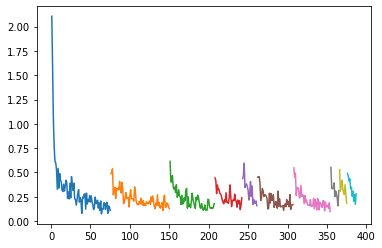

In [47]:
loss_plot(ewc_total_loss_optimised3)

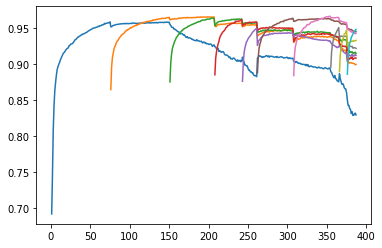

In [48]:
accuracy_plot(ewc_prec_optimised3)

In [49]:
lamda = 400
lr = 5.e-3
hidden_size1 = 2000
hidden_size2 = 1600
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised4 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised4)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised4, 
 ewc_total_loss_optimised4,
 ewc_ce_loss_optimised4, 
 ewc_ewc_loss_optimised4) =train(
    mlp_consolidation_optimised4, train_loader, test_loader, valid_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    cuda
)

=> task: 1/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.5703 | loss => ce: 2.099 / ewc: 0.0 / total: 2.099: : 375it [00:25, 14.82it/s]


Validation loss decreased (inf --> 2.065000).  Saving model ...


=> task: 1/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.7188 | loss => ce: 1.535 / ewc: 0.0 / total: 1.535: : 375it [00:23, 16.17it/s]


Validation loss decreased (2.065000 --> 1.503374).  Saving model ...


=> task: 1/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.9629 / ewc: 0.0 / total: 0.9629: : 375it [00:23, 16.23it/s]


Validation loss decreased (1.503374 --> 0.927489).  Saving model ...


=> task: 1/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.7295 / ewc: 0.0 / total: 0.7295: : 375it [00:22, 16.48it/s]


Validation loss decreased (0.927489 --> 0.673934).  Saving model ...


=> task: 1/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8047 | loss => ce: 0.6367 / ewc: 0.0 / total: 0.6367: : 375it [00:22, 16.34it/s]


Validation loss decreased (0.673934 --> 0.551899).  Saving model ...


=> task: 1/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.5256 / ewc: 0.0 / total: 0.5256: : 375it [00:22, 16.39it/s]


Validation loss decreased (0.551899 --> 0.482543).  Saving model ...


=> task: 1/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4821 / ewc: 0.0 / total: 0.4821: : 375it [00:23, 16.24it/s]


Validation loss decreased (0.482543 --> 0.438530).  Saving model ...


=> task: 1/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4884 / ewc: 0.0 / total: 0.4884: : 375it [00:22, 16.45it/s]


Validation loss decreased (0.438530 --> 0.406664).  Saving model ...


=> task: 1/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.434 / ewc: 0.0 / total: 0.434: : 375it [00:23, 16.20it/s]   


Validation loss decreased (0.406664 --> 0.384743).  Saving model ...


=> task: 1/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3553 / ewc: 0.0 / total: 0.3553: : 375it [00:22, 16.82it/s]


Validation loss decreased (0.384743 --> 0.365881).  Saving model ...


=> task: 1/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2897 / ewc: 0.0 / total: 0.2897: : 375it [00:22, 16.77it/s]


Validation loss decreased (0.365881 --> 0.351167).  Saving model ...


=> task: 1/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3637 / ewc: 0.0 / total: 0.3637: : 375it [00:22, 16.79it/s]


Validation loss decreased (0.351167 --> 0.339384).  Saving model ...


=> task: 1/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2792 / ewc: 0.0 / total: 0.2792: : 375it [00:21, 17.22it/s]


Validation loss decreased (0.339384 --> 0.329795).  Saving model ...


=> task: 1/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.311 / ewc: 0.0 / total: 0.311: : 375it [00:21, 17.23it/s]  


Validation loss decreased (0.329795 --> 0.320493).  Saving model ...


=> task: 1/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2632 / ewc: 0.0 / total: 0.2632: : 375it [00:22, 16.86it/s]


Validation loss decreased (0.320493 --> 0.312610).  Saving model ...


=> task: 1/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3194 / ewc: 0.0 / total: 0.3194: : 375it [00:22, 16.98it/s]


Validation loss decreased (0.312610 --> 0.305779).  Saving model ...


=> task: 1/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3863 / ewc: 0.0 / total: 0.3863: : 375it [00:22, 16.85it/s]


Validation loss decreased (0.305779 --> 0.299016).  Saving model ...


=> task: 1/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3932 / ewc: 0.0 / total: 0.3932: : 375it [00:21, 17.08it/s]


Validation loss decreased (0.299016 --> 0.292821).  Saving model ...


=> task: 1/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2419 / ewc: 0.0 / total: 0.2419: : 375it [00:21, 17.05it/s]


Validation loss decreased (0.292821 --> 0.286942).  Saving model ...


=> task: 1/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3415 / ewc: 0.0 / total: 0.3415: : 375it [00:22, 16.84it/s]


Validation loss decreased (0.286942 --> 0.281140).  Saving model ...


=> task: 1/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3579 / ewc: 0.0 / total: 0.3579: : 375it [00:22, 16.85it/s]


Validation loss decreased (0.281140 --> 0.276138).  Saving model ...


=> task: 1/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2852 / ewc: 0.0 / total: 0.2852: : 375it [00:22, 16.79it/s]


Validation loss decreased (0.276138 --> 0.271545).  Saving model ...


=> task: 1/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2913 / ewc: 0.0 / total: 0.2913: : 375it [00:22, 16.98it/s]


Validation loss decreased (0.271545 --> 0.266697).  Saving model ...


=> task: 1/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2887 / ewc: 0.0 / total: 0.2887: : 375it [00:21, 17.09it/s]


Validation loss decreased (0.266697 --> 0.262682).  Saving model ...


=> task: 1/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1805 / ewc: 0.0 / total: 0.1805: : 375it [00:22, 16.76it/s]


Validation loss decreased (0.262682 --> 0.257403).  Saving model ...


=> task: 1/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2503 / ewc: 0.0 / total: 0.2503: : 375it [00:22, 16.84it/s]


Validation loss decreased (0.257403 --> 0.253623).  Saving model ...


=> task: 1/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2433 / ewc: 0.0 / total: 0.2433: : 375it [00:22, 16.89it/s]


Validation loss decreased (0.253623 --> 0.249464).  Saving model ...


=> task: 1/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2721 / ewc: 0.0 / total: 0.2721: : 375it [00:22, 16.94it/s]


Validation loss decreased (0.249464 --> 0.245828).  Saving model ...


=> task: 1/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.174 / ewc: 0.0 / total: 0.174: : 375it [00:22, 16.88it/s]  


Validation loss decreased (0.245828 --> 0.242583).  Saving model ...


=> task: 1/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2392 / ewc: 0.0 / total: 0.2392: : 375it [00:22, 16.81it/s]


Validation loss decreased (0.242583 --> 0.238459).  Saving model ...


=> task: 1/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3648 / ewc: 0.0 / total: 0.3648: : 375it [00:22, 16.83it/s] 


Validation loss decreased (0.238459 --> 0.235276).  Saving model ...


=> task: 1/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1495 / ewc: 0.0 / total: 0.1495: : 375it [00:22, 16.85it/s]


Validation loss decreased (0.235276 --> 0.232048).  Saving model ...


=> task: 1/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1698 / ewc: 0.0 / total: 0.1698: : 375it [00:22, 16.91it/s] 


Validation loss decreased (0.232048 --> 0.228261).  Saving model ...


=> task: 1/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2089 / ewc: 0.0 / total: 0.2089: : 375it [00:22, 16.84it/s]


Validation loss decreased (0.228261 --> 0.224849).  Saving model ...


=> task: 1/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2278 / ewc: 0.0 / total: 0.2278: : 375it [00:22, 16.85it/s]


Validation loss decreased (0.224849 --> 0.221230).  Saving model ...


=> task: 1/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1755 / ewc: 0.0 / total: 0.1755: : 375it [00:22, 16.89it/s]


Validation loss decreased (0.221230 --> 0.218553).  Saving model ...


=> task: 1/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2597 / ewc: 0.0 / total: 0.2597: : 375it [00:21, 17.11it/s]


Validation loss decreased (0.218553 --> 0.215712).  Saving model ...


=> task: 1/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2336 / ewc: 0.0 / total: 0.2336: : 375it [00:22, 16.80it/s] 


Validation loss decreased (0.215712 --> 0.213694).  Saving model ...


=> task: 1/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2319 / ewc: 0.0 / total: 0.2319: : 375it [00:23, 16.03it/s] 


Validation loss decreased (0.213694 --> 0.209934).  Saving model ...


=> task: 1/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1836 / ewc: 0.0 / total: 0.1836: : 375it [00:21, 17.05it/s]


Validation loss decreased (0.209934 --> 0.207798).  Saving model ...


=> task: 1/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1956 / ewc: 0.0 / total: 0.1956: : 375it [00:22, 16.75it/s] 


Validation loss decreased (0.207798 --> 0.204642).  Saving model ...


=> task: 1/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.283 / ewc: 0.0 / total: 0.283: : 375it [00:22, 16.76it/s]   


Validation loss decreased (0.204642 --> 0.202157).  Saving model ...


=> task: 1/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1878 / ewc: 0.0 / total: 0.1878: : 375it [00:21, 17.48it/s] 


Validation loss decreased (0.202157 --> 0.199633).  Saving model ...


=> task: 1/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1637 / ewc: 0.0 / total: 0.1637: : 375it [00:22, 16.74it/s] 


Validation loss decreased (0.199633 --> 0.197315).  Saving model ...


=> task: 1/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1924 / ewc: 0.0 / total: 0.1924: : 375it [00:22, 16.76it/s] 


Validation loss decreased (0.197315 --> 0.194632).  Saving model ...


=> task: 1/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.157 / ewc: 0.0 / total: 0.157: : 375it [00:22, 16.83it/s]   


Validation loss decreased (0.194632 --> 0.192267).  Saving model ...


=> task: 1/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1268 / ewc: 0.0 / total: 0.1268: : 375it [00:22, 16.60it/s] 


Validation loss decreased (0.192267 --> 0.189438).  Saving model ...


=> task: 1/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2233 / ewc: 0.0 / total: 0.2233: : 375it [00:22, 16.87it/s] 


Validation loss decreased (0.189438 --> 0.187511).  Saving model ...


=> task: 1/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.1834 / ewc: 0.0 / total: 0.1834: : 375it [00:22, 16.83it/s] 


Validation loss decreased (0.187511 --> 0.185658).  Saving model ...


=> task: 1/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1804 / ewc: 0.0 / total: 0.1804: : 375it [00:22, 16.78it/s] 


Validation loss decreased (0.185658 --> 0.183156).  Saving model ...


=> task: 1/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1798 / ewc: 0.0 / total: 0.1798: : 375it [00:22, 16.94it/s] 


Validation loss decreased (0.183156 --> 0.181433).  Saving model ...


=> task: 1/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.207 / ewc: 0.0 / total: 0.207: : 375it [00:22, 16.86it/s]   


Validation loss decreased (0.181433 --> 0.179722).  Saving model ...


=> task: 1/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1884 / ewc: 0.0 / total: 0.1884: : 375it [00:22, 16.83it/s] 


Validation loss decreased (0.179722 --> 0.176921).  Saving model ...


=> task: 1/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.08572 / ewc: 0.0 / total: 0.08572: : 375it [00:22, 16.82it/s]


Validation loss decreased (0.176921 --> 0.174908).  Saving model ...


=> task: 1/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1322 / ewc: 0.0 / total: 0.1322: : 375it [00:22, 16.83it/s] 


Validation loss decreased (0.174908 --> 0.173176).  Saving model ...


=> task: 1/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1233 / ewc: 0.0 / total: 0.1233: : 375it [00:22, 16.85it/s] 


Validation loss decreased (0.173176 --> 0.171760).  Saving model ...


=> task: 1/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1256 / ewc: 0.0 / total: 0.1256: : 375it [00:22, 16.83it/s] 


Validation loss decreased (0.171760 --> 0.169469).  Saving model ...


=> task: 1/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1256 / ewc: 0.0 / total: 0.1256: : 375it [00:22, 16.79it/s] 


Validation loss decreased (0.169469 --> 0.167940).  Saving model ...


=> task: 1/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.142 / ewc: 0.0 / total: 0.142: : 375it [00:22, 17.02it/s]   


Validation loss decreased (0.167940 --> 0.166053).  Saving model ...


=> task: 1/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2153 / ewc: 0.0 / total: 0.2153: : 375it [00:22, 16.99it/s] 


Validation loss decreased (0.166053 --> 0.164666).  Saving model ...


=> task: 1/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1963 / ewc: 0.0 / total: 0.1963: : 375it [00:22, 16.82it/s] 


Validation loss decreased (0.164666 --> 0.162890).  Saving model ...


=> task: 1/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1383 / ewc: 0.0 / total: 0.1383: : 375it [00:22, 16.89it/s] 


Validation loss decreased (0.162890 --> 0.161496).  Saving model ...


=> task: 1/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.111 / ewc: 0.0 / total: 0.111: : 375it [00:22, 16.84it/s]   


Validation loss decreased (0.161496 --> 0.159984).  Saving model ...


=> task: 1/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2281 / ewc: 0.0 / total: 0.2281: : 375it [00:22, 16.91it/s] 


Validation loss decreased (0.159984 --> 0.158086).  Saving model ...


=> task: 1/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1695 / ewc: 0.0 / total: 0.1695: : 375it [00:22, 16.88it/s] 


Validation loss decreased (0.158086 --> 0.157313).  Saving model ...


=> task: 1/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1505 / ewc: 0.0 / total: 0.1505: : 375it [00:22, 16.49it/s] 


Validation loss decreased (0.157313 --> 0.155334).  Saving model ...


=> task: 1/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.14 / ewc: 0.0 / total: 0.14: : 375it [00:22, 16.58it/s]     


Validation loss decreased (0.155334 --> 0.153979).  Saving model ...


=> task: 1/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2279 / ewc: 0.0 / total: 0.2279: : 375it [00:22, 16.72it/s] 


Validation loss decreased (0.153979 --> 0.152250).  Saving model ...


=> task: 1/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1699 / ewc: 0.0 / total: 0.1699: : 375it [00:22, 16.77it/s]  


Validation loss decreased (0.152250 --> 0.150880).  Saving model ...


=> task: 1/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2474 / ewc: 0.0 / total: 0.2474: : 375it [00:22, 16.68it/s] 


Validation loss decreased (0.150880 --> 0.149754).  Saving model ...


=> task: 1/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.07517 / ewc: 0.0 / total: 0.07517: : 375it [00:22, 16.75it/s]


Validation loss decreased (0.149754 --> 0.148254).  Saving model ...


=> task: 1/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1219 / ewc: 0.0 / total: 0.1219: : 375it [00:22, 16.68it/s] 


Validation loss decreased (0.148254 --> 0.147147).  Saving model ...


=> task: 1/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1555 / ewc: 0.0 / total: 0.1555: : 375it [00:22, 16.70it/s]  


Validation loss decreased (0.147147 --> 0.145728).  Saving model ...


=> task: 1/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1381 / ewc: 0.0 / total: 0.1381: : 375it [00:22, 17.02it/s] 


Validation loss decreased (0.145728 --> 0.144406).  Saving model ...


=> task: 1/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1251 / ewc: 0.0 / total: 0.1251: : 375it [00:22, 16.74it/s]  


Validation loss decreased (0.144406 --> 0.143359).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.5077 / ewc: 0.01978 / total: 0.5275: : 375it [00:40,  9.24it/s]


Validation loss decreased (inf --> 0.329260).  Saving model ...


=> task: 2/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.4827 / ewc: 0.02541 / total: 0.5082: : 375it [00:38,  9.78it/s]


Validation loss decreased (0.329260 --> 0.273088).  Saving model ...


=> task: 2/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.3979 / ewc: 0.02754 / total: 0.4255: : 375it [00:39,  9.40it/s]


Validation loss decreased (0.273088 --> 0.248716).  Saving model ...


=> task: 2/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.3162 / ewc: 0.02861 / total: 0.3449: : 375it [00:39,  9.51it/s]


Validation loss decreased (0.248716 --> 0.234558).  Saving model ...


=> task: 2/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3194 / ewc: 0.029 / total: 0.3484: : 375it [00:39,  9.50it/s] 


Validation loss decreased (0.234558 --> 0.224729).  Saving model ...


=> task: 2/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.278 / ewc: 0.02922 / total: 0.3072: : 375it [00:39,  9.52it/s] 


Validation loss decreased (0.224729 --> 0.217834).  Saving model ...


=> task: 2/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3328 / ewc: 0.02924 / total: 0.362: : 375it [00:39,  9.39it/s] 


Validation loss decreased (0.217834 --> 0.211363).  Saving model ...


=> task: 2/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2929 / ewc: 0.02919 / total: 0.3221: : 375it [00:39,  9.39it/s]


Validation loss decreased (0.211363 --> 0.206078).  Saving model ...


=> task: 2/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3816 / ewc: 0.02909 / total: 0.4107: : 375it [00:39,  9.43it/s]


Validation loss decreased (0.206078 --> 0.201901).  Saving model ...


=> task: 2/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1912 / ewc: 0.0289 / total: 0.2201: : 375it [00:39,  9.41it/s]


Validation loss decreased (0.201901 --> 0.198359).  Saving model ...


=> task: 2/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2742 / ewc: 0.0288 / total: 0.303: : 375it [00:40,  9.36it/s] 


Validation loss decreased (0.198359 --> 0.194926).  Saving model ...


=> task: 2/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1584 / ewc: 0.02864 / total: 0.187: : 375it [00:39,  9.59it/s] 


Validation loss decreased (0.194926 --> 0.191990).  Saving model ...


=> task: 2/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.234 / ewc: 0.02848 / total: 0.2624: : 375it [00:40,  9.36it/s] 


Validation loss decreased (0.191990 --> 0.188826).  Saving model ...


=> task: 2/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2919 / ewc: 0.02837 / total: 0.3203: : 375it [00:39,  9.45it/s]


Validation loss decreased (0.188826 --> 0.186199).  Saving model ...


=> task: 2/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1942 / ewc: 0.02824 / total: 0.2225: : 375it [00:40,  9.26it/s]


Validation loss decreased (0.186199 --> 0.184323).  Saving model ...


=> task: 2/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1686 / ewc: 0.02807 / total: 0.1967: : 375it [00:40,  9.33it/s]


Validation loss decreased (0.184323 --> 0.181680).  Saving model ...


=> task: 2/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.266 / ewc: 0.02796 / total: 0.2939: : 375it [00:39,  9.43it/s] 


Validation loss decreased (0.181680 --> 0.180036).  Saving model ...


=> task: 2/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2732 / ewc: 0.02782 / total: 0.301: : 375it [00:39,  9.55it/s] 


Validation loss decreased (0.180036 --> 0.177581).  Saving model ...


=> task: 2/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2227 / ewc: 0.02769 / total: 0.2504: : 375it [00:39,  9.44it/s]


Validation loss decreased (0.177581 --> 0.176379).  Saving model ...


=> task: 2/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1902 / ewc: 0.02754 / total: 0.2177: : 375it [00:38,  9.73it/s]


Validation loss decreased (0.176379 --> 0.174453).  Saving model ...


=> task: 2/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2097 / ewc: 0.02748 / total: 0.2372: : 375it [00:39,  9.46it/s]


Validation loss decreased (0.174453 --> 0.173699).  Saving model ...


=> task: 2/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2139 / ewc: 0.02733 / total: 0.2412: : 375it [00:40,  9.37it/s]


Validation loss decreased (0.173699 --> 0.171563).  Saving model ...


=> task: 2/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2059 / ewc: 0.02725 / total: 0.2331: : 375it [00:40,  9.37it/s]


Validation loss decreased (0.171563 --> 0.170163).  Saving model ...


=> task: 2/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2137 / ewc: 0.02708 / total: 0.2408: : 375it [00:40,  9.28it/s]


Validation loss decreased (0.170163 --> 0.168877).  Saving model ...


=> task: 2/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2391 / ewc: 0.027 / total: 0.2661: : 375it [00:40,  9.34it/s]  


Validation loss decreased (0.168877 --> 0.167656).  Saving model ...


=> task: 2/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1204 / ewc: 0.02691 / total: 0.1473: : 375it [00:38,  9.63it/s]


Validation loss decreased (0.167656 --> 0.166514).  Saving model ...


=> task: 2/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1706 / ewc: 0.02681 / total: 0.1974: : 375it [00:46,  8.03it/s]


Validation loss decreased (0.166514 --> 0.165188).  Saving model ...


=> task: 2/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2542 / ewc: 0.0267 / total: 0.2809: : 375it [00:40,  9.17it/s] 


Validation loss decreased (0.165188 --> 0.164152).  Saving model ...


=> task: 2/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2625 / ewc: 0.02663 / total: 0.2891: : 375it [00:43,  8.71it/s]


Validation loss decreased (0.164152 --> 0.162922).  Saving model ...


=> task: 2/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2442 / ewc: 0.02655 / total: 0.2707: : 375it [00:42,  8.91it/s] 


Validation loss decreased (0.162922 --> 0.162047).  Saving model ...


=> task: 2/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2442 / ewc: 0.02645 / total: 0.2707: : 375it [00:39,  9.41it/s]


Validation loss decreased (0.162047 --> 0.160858).  Saving model ...


=> task: 2/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1219 / ewc: 0.02639 / total: 0.1483: : 375it [00:40,  9.22it/s]


Validation loss decreased (0.160858 --> 0.160146).  Saving model ...


=> task: 2/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2517 / ewc: 0.02629 / total: 0.278: : 375it [00:43,  8.56it/s]  


Validation loss decreased (0.160146 --> 0.158913).  Saving model ...


=> task: 2/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1593 / ewc: 0.02624 / total: 0.1856: : 375it [00:42,  8.85it/s]


Validation loss decreased (0.158913 --> 0.157977).  Saving model ...


=> task: 2/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1084 / ewc: 0.02616 / total: 0.1346: : 375it [00:41,  9.04it/s]


Validation loss decreased (0.157977 --> 0.157366).  Saving model ...


=> task: 2/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1681 / ewc: 0.02613 / total: 0.1942: : 375it [00:39,  9.44it/s] 


Validation loss decreased (0.157366 --> 0.156811).  Saving model ...


=> task: 2/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2335 / ewc: 0.02605 / total: 0.2596: : 375it [00:40,  9.27it/s] 


Validation loss decreased (0.156811 --> 0.155475).  Saving model ...


=> task: 2/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1686 / ewc: 0.02596 / total: 0.1946: : 375it [00:40,  9.30it/s]


Validation loss decreased (0.155475 --> 0.154759).  Saving model ...


=> task: 2/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.245 / ewc: 0.02592 / total: 0.271: : 375it [00:40,  9.22it/s]   


Validation loss decreased (0.154759 --> 0.154270).  Saving model ...


=> task: 2/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2185 / ewc: 0.02584 / total: 0.2443: : 375it [00:40,  9.21it/s] 


Validation loss decreased (0.154270 --> 0.153808).  Saving model ...


=> task: 2/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1509 / ewc: 0.02576 / total: 0.1766: : 375it [00:40,  9.27it/s]


Validation loss decreased (0.153808 --> 0.152869).  Saving model ...


=> task: 2/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2235 / ewc: 0.02572 / total: 0.2492: : 375it [00:40,  9.20it/s]


Validation loss decreased (0.152869 --> 0.152120).  Saving model ...


=> task: 2/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1539 / ewc: 0.02565 / total: 0.1795: : 375it [00:40,  9.20it/s] 


Validation loss decreased (0.152120 --> 0.151405).  Saving model ...


=> task: 2/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1908 / ewc: 0.02561 / total: 0.2165: : 375it [00:40,  9.32it/s]


Validation loss decreased (0.151405 --> 0.151045).  Saving model ...


=> task: 2/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1582 / ewc: 0.02555 / total: 0.1838: : 375it [00:41,  8.98it/s] 


Validation loss decreased (0.151045 --> 0.150053).  Saving model ...


=> task: 2/10 | epoch: 46/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.171 / ewc: 0.0255 / total: 0.1965: : 375it [00:40,  9.16it/s]  


Validation loss decreased (0.150053 --> 0.149684).  Saving model ...


=> task: 2/10 | epoch: 47/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1375 / ewc: 0.02544 / total: 0.1629: : 375it [00:40,  9.21it/s] 


Validation loss decreased (0.149684 --> 0.149455).  Saving model ...


=> task: 2/10 | epoch: 48/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09558 / ewc: 0.02539 / total: 0.121: : 375it [00:41,  8.99it/s] 


Validation loss decreased (0.149455 --> 0.148706).  Saving model ...


=> task: 2/10 | epoch: 49/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1146 / ewc: 0.02532 / total: 0.1399: : 375it [00:43,  8.69it/s] 


Validation loss decreased (0.148706 --> 0.147908).  Saving model ...


=> task: 2/10 | epoch: 50/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2359 / ewc: 0.02527 / total: 0.2611: : 375it [00:41,  9.00it/s] 


Validation loss decreased (0.147908 --> 0.147531).  Saving model ...


=> task: 2/10 | epoch: 51/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1492 / ewc: 0.02523 / total: 0.1744: : 375it [00:41,  8.98it/s] 


Validation loss decreased (0.147531 --> 0.146983).  Saving model ...


=> task: 2/10 | epoch: 52/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2876 / ewc: 0.02518 / total: 0.3128: : 375it [00:41,  9.00it/s] 


Validation loss decreased (0.146983 --> 0.146769).  Saving model ...


=> task: 2/10 | epoch: 53/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09107 / ewc: 0.02514 / total: 0.1162: : 375it [00:41,  8.99it/s]


Validation loss decreased (0.146769 --> 0.146216).  Saving model ...


=> task: 2/10 | epoch: 54/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.178 / ewc: 0.02508 / total: 0.2031: : 375it [00:41,  9.12it/s]  


Validation loss decreased (0.146216 --> 0.145547).  Saving model ...


=> task: 2/10 | epoch: 55/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.247 / ewc: 0.02506 / total: 0.2721: : 375it [00:40,  9.26it/s]  


Validation loss decreased (0.145547 --> 0.145174).  Saving model ...


=> task: 2/10 | epoch: 56/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1627 / ewc: 0.02503 / total: 0.1877: : 375it [00:40,  9.28it/s] 


Validation loss decreased (0.145174 --> 0.144887).  Saving model ...


=> task: 2/10 | epoch: 57/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1659 / ewc: 0.02495 / total: 0.1908: : 375it [00:36, 10.25it/s] 


Validation loss decreased (0.144887 --> 0.143886).  Saving model ...


=> task: 2/10 | epoch: 58/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2202 / ewc: 0.02492 / total: 0.2451: : 375it [00:41,  9.03it/s] 


Validation loss decreased (0.143886 --> 0.143750).  Saving model ...


=> task: 2/10 | epoch: 59/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1392 / ewc: 0.02487 / total: 0.1641: : 375it [00:41,  9.03it/s] 


Validation loss decreased (0.143750 --> 0.143434).  Saving model ...


=> task: 2/10 | epoch: 60/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09374 / ewc: 0.02482 / total: 0.1186: : 375it [00:41,  9.02it/s]


Validation loss decreased (0.143434 --> 0.142808).  Saving model ...


=> task: 2/10 | epoch: 61/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1588 / ewc: 0.02477 / total: 0.1836: : 375it [00:41,  9.04it/s] 


Validation loss decreased (0.142808 --> 0.142663).  Saving model ...


=> task: 2/10 | epoch: 62/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1414 / ewc: 0.02475 / total: 0.1662: : 375it [00:41,  8.98it/s] 


Validation loss decreased (0.142663 --> 0.141732).  Saving model ...


=> task: 2/10 | epoch: 63/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.09199 / ewc: 0.02471 / total: 0.1167: : 375it [00:41,  9.03it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 64/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1452 / ewc: 0.02467 / total: 0.1699: : 375it [00:41,  9.12it/s] 


Validation loss decreased (0.141732 --> 0.141254).  Saving model ...


=> task: 2/10 | epoch: 65/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.128 / ewc: 0.02463 / total: 0.1526: : 375it [00:40,  9.20it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 66/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1271 / ewc: 0.0246 / total: 0.1517: : 375it [00:41,  9.01it/s]  


Validation loss decreased (0.141254 --> 0.140802).  Saving model ...


=> task: 2/10 | epoch: 67/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1603 / ewc: 0.02456 / total: 0.1848: : 375it [00:41,  9.01it/s] 


Validation loss decreased (0.140802 --> 0.140276).  Saving model ...


=> task: 2/10 | epoch: 68/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.09537 / ewc: 0.02452 / total: 0.1199: : 375it [00:41,  9.01it/s]


Validation loss decreased (0.140276 --> 0.139937).  Saving model ...


=> task: 2/10 | epoch: 69/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1124 / ewc: 0.02448 / total: 0.1369: : 375it [00:41,  9.01it/s] 


Validation loss decreased (0.139937 --> 0.139518).  Saving model ...


=> task: 2/10 | epoch: 70/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2064 / ewc: 0.02445 / total: 0.2309: : 375it [00:41,  9.00it/s] 


Validation loss decreased (0.139518 --> 0.139168).  Saving model ...


=> task: 2/10 | epoch: 71/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08936 / ewc: 0.02442 / total: 0.1138: : 375it [00:40,  9.23it/s]


Validation loss decreased (0.139168 --> 0.138692).  Saving model ...


=> task: 2/10 | epoch: 72/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1423 / ewc: 0.02439 / total: 0.1667: : 375it [00:41,  9.03it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 73/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06561 / ewc: 0.02434 / total: 0.08994: : 375it [00:41,  9.03it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 74/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1121 / ewc: 0.0243 / total: 0.1364: : 375it [00:41,  9.03it/s]  


Validation loss decreased (0.138692 --> 0.137869).  Saving model ...


=> task: 2/10 | epoch: 75/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1821 / ewc: 0.02427 / total: 0.2064: : 375it [00:41,  9.01it/s] 


Validation loss decreased (0.137869 --> 0.137820).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8125 | loss => ce: 0.5046 / ewc: 0.02244 / total: 0.5271: : 375it [00:40,  9.20it/s]


Validation loss decreased (inf --> 0.254773).  Saving model ...


=> task: 3/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3648 / ewc: 0.02787 / total: 0.3926: : 375it [00:38,  9.64it/s]


Validation loss decreased (0.254773 --> 0.222462).  Saving model ...


=> task: 3/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.3874 / ewc: 0.03002 / total: 0.4174: : 375it [00:39,  9.44it/s]


Validation loss decreased (0.222462 --> 0.209696).  Saving model ...


=> task: 3/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3518 / ewc: 0.03089 / total: 0.3827: : 375it [00:40,  9.27it/s]


Validation loss decreased (0.209696 --> 0.202525).  Saving model ...


=> task: 3/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3357 / ewc: 0.03114 / total: 0.3668: : 375it [00:38,  9.78it/s]


Validation loss decreased (0.202525 --> 0.196304).  Saving model ...


=> task: 3/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1112 / ewc: 0.03125 / total: 0.1425: : 375it [00:40,  9.26it/s]


Validation loss decreased (0.196304 --> 0.192980).  Saving model ...


=> task: 3/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3097 / ewc: 0.03107 / total: 0.3408: : 375it [00:40,  9.27it/s]


Validation loss decreased (0.192980 --> 0.190165).  Saving model ...


=> task: 3/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2708 / ewc: 0.03083 / total: 0.3017: : 375it [00:40,  9.37it/s]


Validation loss decreased (0.190165 --> 0.187216).  Saving model ...


=> task: 3/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2485 / ewc: 0.03056 / total: 0.2791: : 375it [00:40,  9.28it/s]


Validation loss decreased (0.187216 --> 0.186234).  Saving model ...


=> task: 3/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3166 / ewc: 0.03025 / total: 0.3469: : 375it [00:39,  9.40it/s]


Validation loss decreased (0.186234 --> 0.183641).  Saving model ...


=> task: 3/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2517 / ewc: 0.02995 / total: 0.2816: : 375it [00:40,  9.35it/s]


Validation loss decreased (0.183641 --> 0.182286).  Saving model ...


=> task: 3/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3045 / ewc: 0.02966 / total: 0.3341: : 375it [00:39,  9.41it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.3976 / ewc: 0.02936 / total: 0.427: : 375it [00:40,  9.37it/s] 


Validation loss decreased (0.182286 --> 0.180268).  Saving model ...


=> task: 3/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2148 / ewc: 0.02908 / total: 0.2439: : 375it [00:39,  9.44it/s]


Validation loss decreased (0.180268 --> 0.179897).  Saving model ...


=> task: 3/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1285 / ewc: 0.02877 / total: 0.1573: : 375it [00:40,  9.33it/s]


Validation loss decreased (0.179897 --> 0.179827).  Saving model ...


=> task: 3/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2204 / ewc: 0.02845 / total: 0.2488: : 375it [00:39,  9.53it/s]


Validation loss decreased (0.179827 --> 0.179245).  Saving model ...


=> task: 3/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1867 / ewc: 0.02818 / total: 0.2149: : 375it [00:40,  9.36it/s]


Validation loss decreased (0.179245 --> 0.178428).  Saving model ...


=> task: 3/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2408 / ewc: 0.02794 / total: 0.2687: : 375it [00:40,  9.33it/s]


Validation loss decreased (0.178428 --> 0.178022).  Saving model ...


=> task: 3/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1257 / ewc: 0.02771 / total: 0.1534: : 375it [00:38,  9.67it/s] 


Validation loss decreased (0.178022 --> 0.177500).  Saving model ...


=> task: 3/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.209 / ewc: 0.02746 / total: 0.2364: : 375it [00:40,  9.34it/s] 


Validation loss decreased (0.177500 --> 0.176838).  Saving model ...


=> task: 3/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2069 / ewc: 0.02721 / total: 0.2341: : 375it [00:39,  9.39it/s]


Validation loss decreased (0.176838 --> 0.176209).  Saving model ...


=> task: 3/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.124 / ewc: 0.027 / total: 0.151: : 375it [00:39,  9.48it/s]    


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1659 / ewc: 0.02677 / total: 0.1927: : 375it [00:40,  9.34it/s]


Validation loss decreased (0.176209 --> 0.176077).  Saving model ...


=> task: 3/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1952 / ewc: 0.02659 / total: 0.2218: : 375it [00:40,  9.36it/s] 


Validation loss decreased (0.176077 --> 0.175829).  Saving model ...


=> task: 3/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1913 / ewc: 0.02644 / total: 0.2177: : 375it [00:40,  9.33it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09303 / ewc: 0.02626 / total: 0.1193: : 375it [00:40,  9.32it/s]


Validation loss decreased (0.175829 --> 0.175776).  Saving model ...


=> task: 3/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2488 / ewc: 0.02606 / total: 0.2748: : 375it [00:40,  9.32it/s] 


Validation loss decreased (0.175776 --> 0.174966).  Saving model ...


=> task: 3/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1154 / ewc: 0.0259 / total: 0.1413: : 375it [00:40,  9.32it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1305 / ewc: 0.02572 / total: 0.1562: : 375it [00:39,  9.38it/s]


Validation loss decreased (0.174966 --> 0.174672).  Saving model ...


=> task: 3/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1529 / ewc: 0.02555 / total: 0.1785: : 375it [00:39,  9.39it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.16 / ewc: 0.02539 / total: 0.1853: : 375it [00:39,  9.57it/s]   


Validation loss decreased (0.174672 --> 0.174647).  Saving model ...


=> task: 3/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1588 / ewc: 0.02523 / total: 0.184: : 375it [00:40,  9.35it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1133 / ewc: 0.02508 / total: 0.1383: : 375it [00:40,  9.35it/s] 


Validation loss decreased (0.174647 --> 0.173253).  Saving model ...


=> task: 3/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1029 / ewc: 0.02496 / total: 0.1278: : 375it [00:41,  9.14it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1444 / ewc: 0.02485 / total: 0.1693: : 375it [00:41,  9.06it/s] 


Validation loss decreased (0.173253 --> 0.173088).  Saving model ...


=> task: 3/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1684 / ewc: 0.0247 / total: 0.1931: : 375it [00:40,  9.35it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1989 / ewc: 0.02458 / total: 0.2235: : 375it [00:40,  9.32it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1617 / ewc: 0.02444 / total: 0.1862: : 375it [00:40,  9.32it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1597 / ewc: 0.02434 / total: 0.1841: : 375it [00:40,  9.30it/s] 


Validation loss decreased (0.173088 --> 0.172159).  Saving model ...


=> task: 3/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.09116 / ewc: 0.0242 / total: 0.1154: : 375it [00:40,  9.33it/s] 


Validation loss decreased (0.172159 --> 0.171514).  Saving model ...


=> task: 3/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.0683 / ewc: 0.02411 / total: 0.09242: : 375it [00:42,  8.89it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 42/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.1362 / ewc: 0.02401 / total: 0.1602: : 375it [00:44,  8.39it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 43/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1204 / ewc: 0.02392 / total: 0.1443: : 375it [00:41,  8.96it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 44/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1053 / ewc: 0.02384 / total: 0.1292: : 375it [00:42,  8.82it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 45/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2099 / ewc: 0.02372 / total: 0.2337: : 375it [00:41,  8.94it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8281 | loss => ce: 0.5732 / ewc: 0.02395 / total: 0.5971: : 375it [00:44,  8.41it/s]


Validation loss decreased (inf --> 0.249730).  Saving model ...


=> task: 4/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.353 / ewc: 0.02804 / total: 0.381: : 375it [00:44,  8.45it/s]  


Validation loss decreased (0.249730 --> 0.224815).  Saving model ...


=> task: 4/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2576 / ewc: 0.02926 / total: 0.2868: : 375it [00:42,  8.88it/s]


Validation loss decreased (0.224815 --> 0.215671).  Saving model ...


=> task: 4/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2805 / ewc: 0.02939 / total: 0.3099: : 375it [00:45,  8.16it/s]


Validation loss decreased (0.215671 --> 0.209390).  Saving model ...


=> task: 4/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.242 / ewc: 0.02925 / total: 0.2713: : 375it [00:45,  8.23it/s] 


Validation loss decreased (0.209390 --> 0.207149).  Saving model ...


=> task: 4/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.254 / ewc: 0.02884 / total: 0.2828: : 375it [00:44,  8.44it/s] 


Validation loss decreased (0.207149 --> 0.203001).  Saving model ...


=> task: 4/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.3725 / ewc: 0.02846 / total: 0.4009: : 375it [00:46,  8.06it/s]


Validation loss decreased (0.203001 --> 0.202039).  Saving model ...


=> task: 4/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.207 / ewc: 0.02802 / total: 0.235: : 375it [00:45,  8.28it/s] 


Validation loss decreased (0.202039 --> 0.199159).  Saving model ...


=> task: 4/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.3555 / ewc: 0.02761 / total: 0.3831: : 375it [00:45,  8.30it/s]


Validation loss decreased (0.199159 --> 0.197479).  Saving model ...


=> task: 4/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1837 / ewc: 0.02717 / total: 0.2108: : 375it [00:41,  9.07it/s]


Validation loss decreased (0.197479 --> 0.196270).  Saving model ...


=> task: 4/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1833 / ewc: 0.02677 / total: 0.2101: : 375it [00:45,  8.26it/s]


Validation loss decreased (0.196270 --> 0.195443).  Saving model ...


=> task: 4/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2758 / ewc: 0.0264 / total: 0.3022: : 375it [00:44,  8.49it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1638 / ewc: 0.026 / total: 0.1898: : 375it [00:44,  8.38it/s]  


Validation loss decreased (0.195443 --> 0.193921).  Saving model ...


=> task: 4/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1648 / ewc: 0.02564 / total: 0.1904: : 375it [00:44,  8.36it/s]


Validation loss decreased (0.193921 --> 0.192414).  Saving model ...


=> task: 4/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2347 / ewc: 0.02531 / total: 0.26: : 375it [00:44,  8.38it/s]  


Validation loss decreased (0.192414 --> 0.191763).  Saving model ...


=> task: 4/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2166 / ewc: 0.02498 / total: 0.2416: : 375it [00:45,  8.19it/s]


Validation loss decreased (0.191763 --> 0.191452).  Saving model ...


=> task: 4/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2878 / ewc: 0.02469 / total: 0.3124: : 375it [00:44,  8.38it/s] 


Validation loss decreased (0.191452 --> 0.191197).  Saving model ...


=> task: 4/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.189 / ewc: 0.02441 / total: 0.2134: : 375it [00:46,  8.10it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2627 / ewc: 0.02413 / total: 0.2869: : 375it [00:46,  8.01it/s]


Validation loss decreased (0.191197 --> 0.188858).  Saving model ...


=> task: 4/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1818 / ewc: 0.02391 / total: 0.2057: : 375it [00:46,  7.98it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1863 / ewc: 0.02369 / total: 0.21: : 375it [00:47,  7.83it/s]  


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.209 / ewc: 0.02346 / total: 0.2325: : 375it [00:45,  8.29it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2307 / ewc: 0.02321 / total: 0.2539: : 375it [00:47,  7.84it/s]


Validation loss decreased (0.188858 --> 0.188683).  Saving model ...


=> task: 4/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2596 / ewc: 0.023 / total: 0.2826: : 375it [00:47,  7.96it/s]   


Validation loss decreased (0.188683 --> 0.188089).  Saving model ...


=> task: 4/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1329 / ewc: 0.02278 / total: 0.1556: : 375it [00:47,  7.94it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1553 / ewc: 0.02256 / total: 0.1779: : 375it [00:45,  8.32it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1804 / ewc: 0.02237 / total: 0.2028: : 375it [00:44,  8.38it/s]


Validation loss decreased (0.188089 --> 0.187845).  Saving model ...


=> task: 4/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.06889 / ewc: 0.02219 / total: 0.09108: : 375it [00:44,  8.52it/s]


Validation loss decreased (0.187845 --> 0.187628).  Saving model ...


=> task: 4/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.171 / ewc: 0.02204 / total: 0.193: : 375it [00:44,  8.42it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1271 / ewc: 0.02187 / total: 0.149: : 375it [00:43,  8.53it/s]  


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1252 / ewc: 0.02172 / total: 0.1469: : 375it [00:43,  8.61it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2165 / ewc: 0.02157 / total: 0.238: : 375it [00:42,  8.75it/s]  


Validation loss decreased (0.187628 --> 0.187275).  Saving model ...


=> task: 4/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1339 / ewc: 0.02145 / total: 0.1553: : 375it [00:43,  8.62it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2354 / ewc: 0.02129 / total: 0.2567: : 375it [00:42,  8.87it/s] 


Validation loss decreased (0.187275 --> 0.186694).  Saving model ...


=> task: 4/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1501 / ewc: 0.02115 / total: 0.1713: : 375it [00:42,  8.78it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.173 / ewc: 0.02102 / total: 0.194: : 375it [00:43,  8.66it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09865 / ewc: 0.02088 / total: 0.1195: : 375it [00:43,  8.54it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.09922 / ewc: 0.02075 / total: 0.12: : 375it [00:44,  8.49it/s]   


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1859 / ewc: 0.02065 / total: 0.2066: : 375it [00:42,  8.75it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4452 / ewc: 0.03254 / total: 0.4777: : 375it [00:42,  8.86it/s]


Validation loss decreased (inf --> 0.239371).  Saving model ...


=> task: 5/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.4045 / ewc: 0.03637 / total: 0.4408: : 375it [00:40,  9.23it/s]


Validation loss decreased (0.239371 --> 0.221616).  Saving model ...


=> task: 5/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2463 / ewc: 0.03643 / total: 0.2827: : 375it [00:40,  9.30it/s]


Validation loss decreased (0.221616 --> 0.214485).  Saving model ...


=> task: 5/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2696 / ewc: 0.03555 / total: 0.3051: : 375it [00:40,  9.25it/s]


Validation loss decreased (0.214485 --> 0.210527).  Saving model ...


=> task: 5/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3086 / ewc: 0.03446 / total: 0.343: : 375it [00:40,  9.36it/s] 


Validation loss decreased (0.210527 --> 0.207707).  Saving model ...


=> task: 5/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2368 / ewc: 0.03341 / total: 0.2702: : 375it [00:39,  9.39it/s]


Validation loss decreased (0.207707 --> 0.204087).  Saving model ...


=> task: 5/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1688 / ewc: 0.03244 / total: 0.2012: : 375it [00:39,  9.39it/s]


Validation loss decreased (0.204087 --> 0.202311).  Saving model ...


=> task: 5/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.203 / ewc: 0.03156 / total: 0.2345: : 375it [00:39,  9.40it/s] 


Validation loss decreased (0.202311 --> 0.200598).  Saving model ...


=> task: 5/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2691 / ewc: 0.03069 / total: 0.2998: : 375it [00:40,  9.31it/s]


Validation loss decreased (0.200598 --> 0.200551).  Saving model ...


=> task: 5/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1882 / ewc: 0.02996 / total: 0.2182: : 375it [00:40,  9.33it/s]


Validation loss decreased (0.200551 --> 0.198732).  Saving model ...


=> task: 5/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.231 / ewc: 0.02927 / total: 0.2603: : 375it [00:40,  9.21it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1597 / ewc: 0.02868 / total: 0.1883: : 375it [00:41,  9.11it/s]


Validation loss decreased (0.198732 --> 0.197626).  Saving model ...


=> task: 5/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.275 / ewc: 0.02807 / total: 0.3031: : 375it [00:41,  9.08it/s] 


Validation loss decreased (0.197626 --> 0.196986).  Saving model ...


=> task: 5/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.242 / ewc: 0.02753 / total: 0.2696: : 375it [00:41,  9.07it/s] 


Validation loss decreased (0.196986 --> 0.196519).  Saving model ...


=> task: 5/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1525 / ewc: 0.02702 / total: 0.1795: : 375it [00:41,  9.12it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.2043 / ewc: 0.02659 / total: 0.2309: : 375it [00:41,  9.05it/s]


Validation loss decreased (0.196519 --> 0.195893).  Saving model ...


=> task: 5/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2042 / ewc: 0.02613 / total: 0.2303: : 375it [00:41,  9.14it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1833 / ewc: 0.02573 / total: 0.2091: : 375it [00:41,  9.05it/s]


Validation loss decreased (0.195893 --> 0.195645).  Saving model ...


=> task: 5/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1364 / ewc: 0.02534 / total: 0.1617: : 375it [00:40,  9.19it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1331 / ewc: 0.025 / total: 0.1581: : 375it [00:41,  9.05it/s]  


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1888 / ewc: 0.02466 / total: 0.2134: : 375it [00:41,  9.10it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1881 / ewc: 0.02436 / total: 0.2125: : 375it [00:40,  9.21it/s] 


Validation loss decreased (0.195645 --> 0.195123).  Saving model ...


=> task: 5/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1273 / ewc: 0.02407 / total: 0.1513: : 375it [00:40,  9.17it/s]


Validation loss decreased (0.195123 --> 0.194759).  Saving model ...


=> task: 5/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1273 / ewc: 0.02379 / total: 0.1511: : 375it [00:41,  9.11it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1573 / ewc: 0.02355 / total: 0.1809: : 375it [00:41,  9.08it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1692 / ewc: 0.02327 / total: 0.1924: : 375it [00:41,  9.02it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1875 / ewc: 0.02302 / total: 0.2105: : 375it [00:41,  9.04it/s] 


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1708 / ewc: 0.02281 / total: 0.1936: : 375it [00:41,  9.03it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4466 / ewc: 0.03115 / total: 0.4777: : 375it [00:41,  9.07it/s] 


Validation loss decreased (inf --> 0.245596).  Saving model ...


=> task: 6/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.4204 / ewc: 0.03431 / total: 0.4548: : 375it [00:40,  9.36it/s]


Validation loss decreased (0.245596 --> 0.228032).  Saving model ...


=> task: 6/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2615 / ewc: 0.03413 / total: 0.2956: : 375it [00:39,  9.42it/s]


Validation loss decreased (0.228032 --> 0.221147).  Saving model ...


=> task: 6/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.3627 / ewc: 0.03317 / total: 0.3959: : 375it [00:40,  9.29it/s]


Validation loss decreased (0.221147 --> 0.214931).  Saving model ...


=> task: 6/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2066 / ewc: 0.03207 / total: 0.2387: : 375it [00:40,  9.37it/s]


Validation loss decreased (0.214931 --> 0.211499).  Saving model ...


=> task: 6/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1769 / ewc: 0.03107 / total: 0.2079: : 375it [00:40,  9.31it/s]


Validation loss decreased (0.211499 --> 0.209478).  Saving model ...


=> task: 6/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.2891 / ewc: 0.03016 / total: 0.3192: : 375it [00:40,  9.32it/s]


Validation loss decreased (0.209478 --> 0.207235).  Saving model ...


=> task: 6/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2426 / ewc: 0.02934 / total: 0.272: : 375it [00:40,  9.18it/s] 


Validation loss decreased (0.207235 --> 0.206191).  Saving model ...


=> task: 6/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1521 / ewc: 0.02857 / total: 0.1806: : 375it [00:40,  9.25it/s]


Validation loss decreased (0.206191 --> 0.203828).  Saving model ...


=> task: 6/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.2516 / ewc: 0.02789 / total: 0.2795: : 375it [00:41,  9.08it/s]


Validation loss decreased (0.203828 --> 0.202200).  Saving model ...


=> task: 6/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1733 / ewc: 0.02728 / total: 0.2005: : 375it [00:41,  9.10it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1229 / ewc: 0.02669 / total: 0.1496: : 375it [00:41,  9.07it/s]


Validation loss decreased (0.202200 --> 0.201148).  Saving model ...


=> task: 6/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.176 / ewc: 0.0262 / total: 0.2022: : 375it [00:40,  9.23it/s]  


Validation loss decreased (0.201148 --> 0.200497).  Saving model ...


=> task: 6/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1806 / ewc: 0.02571 / total: 0.2063: : 375it [00:41,  9.02it/s]


Validation loss decreased (0.200497 --> 0.199663).  Saving model ...


=> task: 6/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1302 / ewc: 0.02523 / total: 0.1554: : 375it [00:41,  9.09it/s]


Validation loss decreased (0.199663 --> 0.198436).  Saving model ...


=> task: 6/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2367 / ewc: 0.02481 / total: 0.2615: : 375it [00:41,  9.06it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.157 / ewc: 0.0244 / total: 0.1814: : 375it [00:40,  9.22it/s]  


Validation loss decreased (0.198436 --> 0.197428).  Saving model ...


=> task: 6/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2006 / ewc: 0.02405 / total: 0.2246: : 375it [00:41,  9.08it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1657 / ewc: 0.02373 / total: 0.1894: : 375it [00:41,  9.09it/s]


Validation loss decreased (0.197428 --> 0.197032).  Saving model ...


=> task: 6/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1347 / ewc: 0.02343 / total: 0.1582: : 375it [00:41,  9.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.135 / ewc: 0.02315 / total: 0.1581: : 375it [00:41,  9.08it/s] 


Validation loss decreased (0.197032 --> 0.196219).  Saving model ...


=> task: 6/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1569 / ewc: 0.02283 / total: 0.1797: : 375it [00:41,  9.10it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1798 / ewc: 0.02254 / total: 0.2024: : 375it [00:41,  9.02it/s]


Validation loss decreased (0.196219 --> 0.196015).  Saving model ...


=> task: 6/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1606 / ewc: 0.02233 / total: 0.1829: : 375it [00:40,  9.32it/s]


Validation loss decreased (0.196015 --> 0.195751).  Saving model ...


=> task: 6/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1948 / ewc: 0.02209 / total: 0.2169: : 375it [00:41,  9.15it/s] 


Validation loss decreased (0.195751 --> 0.195300).  Saving model ...


=> task: 6/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.2185 / ewc: 0.02186 / total: 0.2404: : 375it [00:41,  9.08it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1559 / ewc: 0.02167 / total: 0.1776: : 375it [00:41,  9.11it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1364 / ewc: 0.02144 / total: 0.1578: : 375it [00:40,  9.28it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.163 / ewc: 0.02125 / total: 0.1843: : 375it [00:41,  9.02it/s]  


Validation loss decreased (0.195300 --> 0.194825).  Saving model ...


=> task: 6/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.1343 / ewc: 0.02106 / total: 0.1553: : 375it [00:40,  9.18it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1065 / ewc: 0.02088 / total: 0.1274: : 375it [00:41,  9.02it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1113 / ewc: 0.02072 / total: 0.132: : 375it [00:41,  9.09it/s]  


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2014 / ewc: 0.02055 / total: 0.2219: : 375it [00:41,  9.05it/s] 


Validation loss decreased (0.194825 --> 0.194067).  Saving model ...


=> task: 6/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1968 / ewc: 0.02037 / total: 0.2172: : 375it [00:41,  9.09it/s] 


Validation loss decreased (0.194067 --> 0.193998).  Saving model ...


=> task: 6/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1985 / ewc: 0.02024 / total: 0.2187: : 375it [00:40,  9.34it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1334 / ewc: 0.02009 / total: 0.1535: : 375it [00:40,  9.24it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1443 / ewc: 0.01995 / total: 0.1642: : 375it [00:41,  9.05it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1588 / ewc: 0.01981 / total: 0.1786: : 375it [00:41,  9.01it/s] 


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1889 / ewc: 0.01971 / total: 0.2086: : 375it [00:41,  9.03it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3462 / ewc: 0.03104 / total: 0.3773: : 375it [00:41,  9.00it/s]


Validation loss decreased (inf --> 0.239563).  Saving model ...


=> task: 7/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.4488 / ewc: 0.03379 / total: 0.4826: : 375it [00:37,  9.98it/s]


Validation loss decreased (0.239563 --> 0.226406).  Saving model ...


=> task: 7/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.3566 / ewc: 0.03342 / total: 0.39: : 375it [00:39,  9.57it/s]  


Validation loss decreased (0.226406 --> 0.219081).  Saving model ...


=> task: 7/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2266 / ewc: 0.03251 / total: 0.2591: : 375it [00:39,  9.39it/s]


Validation loss decreased (0.219081 --> 0.215039).  Saving model ...


=> task: 7/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.8672 | loss => ce: 0.4258 / ewc: 0.03143 / total: 0.4572: : 375it [00:41,  9.14it/s]


Validation loss decreased (0.215039 --> 0.212834).  Saving model ...


=> task: 7/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1776 / ewc: 0.03046 / total: 0.2081: : 375it [00:41,  9.13it/s]


Validation loss decreased (0.212834 --> 0.211567).  Saving model ...


=> task: 7/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1807 / ewc: 0.02951 / total: 0.2102: : 375it [00:40,  9.19it/s]


Validation loss decreased (0.211567 --> 0.209880).  Saving model ...


=> task: 7/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.2263 / ewc: 0.02847 / total: 0.2548: : 375it [00:41,  9.13it/s]


Validation loss decreased (0.209880 --> 0.207613).  Saving model ...


=> task: 7/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1585 / ewc: 0.02776 / total: 0.1863: : 375it [00:40,  9.16it/s]


Validation loss decreased (0.207613 --> 0.206464).  Saving model ...


=> task: 7/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2243 / ewc: 0.02706 / total: 0.2514: : 375it [00:41,  9.13it/s]


Validation loss decreased (0.206464 --> 0.205816).  Saving model ...


=> task: 7/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1418 / ewc: 0.02642 / total: 0.1682: : 375it [00:40,  9.18it/s]


Validation loss decreased (0.205816 --> 0.205276).  Saving model ...


=> task: 7/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1513 / ewc: 0.02574 / total: 0.177: : 375it [00:40,  9.17it/s] 


Validation loss decreased (0.205276 --> 0.204558).  Saving model ...


=> task: 7/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1703 / ewc: 0.02517 / total: 0.1955: : 375it [00:41,  9.14it/s]


Validation loss decreased (0.204558 --> 0.204235).  Saving model ...


=> task: 7/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2057 / ewc: 0.02465 / total: 0.2303: : 375it [00:42,  8.90it/s]


Validation loss decreased (0.204235 --> 0.203369).  Saving model ...


=> task: 7/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2176 / ewc: 0.02415 / total: 0.2417: : 375it [00:46,  8.07it/s]


Validation loss decreased (0.203369 --> 0.202464).  Saving model ...


=> task: 7/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9922 | loss => ce: 0.1068 / ewc: 0.02372 / total: 0.1305: : 375it [00:45,  8.19it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 17/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1513 / ewc: 0.02327 / total: 0.1746: : 375it [00:46,  8.12it/s] 


Validation loss decreased (0.202464 --> 0.201840).  Saving model ...


=> task: 7/10 | epoch: 18/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2534 / ewc: 0.02291 / total: 0.2763: : 375it [00:46,  8.11it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 19/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1185 / ewc: 0.02257 / total: 0.141: : 375it [00:45,  8.19it/s] 


Validation loss decreased (0.201840 --> 0.201623).  Saving model ...


=> task: 7/10 | epoch: 20/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1949 / ewc: 0.0222 / total: 0.2171: : 375it [00:46,  8.14it/s]  


Validation loss decreased (0.201623 --> 0.201535).  Saving model ...


=> task: 7/10 | epoch: 21/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1428 / ewc: 0.02191 / total: 0.1647: : 375it [00:45,  8.24it/s] 


Validation loss decreased (0.201535 --> 0.201343).  Saving model ...


=> task: 7/10 | epoch: 22/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1893 / ewc: 0.02165 / total: 0.2109: : 375it [00:45,  8.17it/s] 


Validation loss decreased (0.201343 --> 0.200908).  Saving model ...


=> task: 7/10 | epoch: 23/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1866 / ewc: 0.02135 / total: 0.2079: : 375it [00:46,  8.14it/s] 


Validation loss decreased (0.200908 --> 0.199940).  Saving model ...


=> task: 7/10 | epoch: 24/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1457 / ewc: 0.02109 / total: 0.1667: : 375it [00:45,  8.19it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 25/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1628 / ewc: 0.02086 / total: 0.1837: : 375it [00:46,  8.11it/s]  


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 26/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1114 / ewc: 0.02062 / total: 0.1321: : 375it [00:45,  8.24it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 27/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1119 / ewc: 0.02043 / total: 0.1323: : 375it [00:46,  8.14it/s] 


Validation loss decreased (0.199940 --> 0.199796).  Saving model ...


=> task: 7/10 | epoch: 28/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1323 / ewc: 0.02021 / total: 0.1525: : 375it [00:46,  8.14it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 29/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1238 / ewc: 0.02003 / total: 0.1439: : 375it [00:46,  8.11it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 30/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1617 / ewc: 0.01985 / total: 0.1815: : 375it [00:46,  8.09it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 31/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.149 / ewc: 0.01966 / total: 0.1687: : 375it [00:45,  8.28it/s]  


Validation loss decreased (0.199796 --> 0.199697).  Saving model ...


=> task: 7/10 | epoch: 32/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1392 / ewc: 0.01949 / total: 0.1587: : 375it [00:44,  8.41it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 33/75 | progress: [48000/60000] (100%) | prec: 0.9844 | loss => ce: 0.08729 / ewc: 0.0193 / total: 0.1066: : 375it [00:44,  8.39it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 34/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1278 / ewc: 0.01914 / total: 0.1469: : 375it [00:44,  8.43it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 35/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1156 / ewc: 0.01901 / total: 0.1346: : 375it [00:45,  8.18it/s]  


Validation loss decreased (0.199697 --> 0.199607).  Saving model ...


=> task: 7/10 | epoch: 36/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.09863 / ewc: 0.01885 / total: 0.1175: : 375it [00:45,  8.23it/s]


Validation loss decreased (0.199607 --> 0.199377).  Saving model ...


=> task: 7/10 | epoch: 37/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1187 / ewc: 0.01872 / total: 0.1375: : 375it [00:45,  8.32it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 38/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.177 / ewc: 0.01858 / total: 0.1956: : 375it [00:48,  7.70it/s]  


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 39/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1593 / ewc: 0.01846 / total: 0.1777: : 375it [00:50,  7.49it/s] 


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 40/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1218 / ewc: 0.0183 / total: 0.1401: : 375it [00:52,  7.18it/s]  


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 41/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1008 / ewc: 0.0182 / total: 0.119: : 375it [00:56,  6.60it/s]   


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.4733 / ewc: 0.02635 / total: 0.4996: : 375it [01:07,  5.53it/s]


Validation loss decreased (inf --> 0.230103).  Saving model ...


=> task: 8/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.3807 / ewc: 0.02961 / total: 0.4104: : 375it [00:49,  7.62it/s]


Validation loss decreased (0.230103 --> 0.223318).  Saving model ...


=> task: 8/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8516 | loss => ce: 0.4545 / ewc: 0.03 / total: 0.4845: : 375it [00:49,  7.52it/s]  


Validation loss decreased (0.223318 --> 0.219083).  Saving model ...


=> task: 8/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2361 / ewc: 0.02939 / total: 0.2654: : 375it [00:49,  7.61it/s]


Validation loss decreased (0.219083 --> 0.218024).  Saving model ...


=> task: 8/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1952 / ewc: 0.02867 / total: 0.2239: : 375it [00:48,  7.69it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.8828 | loss => ce: 0.353 / ewc: 0.02781 / total: 0.3808: : 375it [00:48,  7.81it/s] 


Validation loss decreased (0.218024 --> 0.216636).  Saving model ...


=> task: 8/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1675 / ewc: 0.02706 / total: 0.1946: : 375it [00:49,  7.55it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.2053 / ewc: 0.02636 / total: 0.2317: : 375it [00:51,  7.26it/s]


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.166 / ewc: 0.02568 / total: 0.1916: : 375it [00:43,  8.58it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1695 / ewc: 0.02501 / total: 0.1946: : 375it [00:44,  8.35it/s]


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.167 / ewc: 0.0244 / total: 0.1914: : 375it [00:50,  7.37it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.8594 | loss => ce: 0.4779 / ewc: 0.04666 / total: 0.5246: : 375it [00:42,  8.80it/s]


Validation loss decreased (inf --> 0.247470).  Saving model ...


=> task: 9/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8906 | loss => ce: 0.3262 / ewc: 0.04448 / total: 0.3707: : 375it [00:38,  9.80it/s]


Validation loss decreased (0.247470 --> 0.241121).  Saving model ...


=> task: 9/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3137 / ewc: 0.04138 / total: 0.3551: : 375it [00:40,  9.25it/s]


Validation loss decreased (0.241121 --> 0.238703).  Saving model ...


=> task: 9/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3405 / ewc: 0.03883 / total: 0.3794: : 375it [00:41,  9.08it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2585 / ewc: 0.03672 / total: 0.2952: : 375it [00:41,  9.07it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9062 | loss => ce: 0.2895 / ewc: 0.03492 / total: 0.3244: : 375it [00:41,  9.03it/s]


Validation loss decreased (0.238703 --> 0.237508).  Saving model ...


=> task: 9/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1139 / ewc: 0.03348 / total: 0.1474: : 375it [00:41,  9.07it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9375 | loss => ce: 0.2204 / ewc: 0.03222 / total: 0.2527: : 375it [00:40,  9.22it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9297 | loss => ce: 0.1674 / ewc: 0.03105 / total: 0.1985: : 375it [00:40,  9.29it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.1728 / ewc: 0.03006 / total: 0.2028: : 375it [00:41,  9.11it/s]


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1178 / ewc: 0.02928 / total: 0.1471: : 375it [00:41,  9.13it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/75 | progress: [48000/60000] (100%) | prec: 0.875 | loss => ce: 0.4122 / ewc: 0.04168 / total: 0.4539: : 375it [00:39,  9.59it/s]


Validation loss decreased (inf --> 0.280960).  Saving model ...


=> task: 10/10 | epoch: 2/75 | progress: [48000/60000] (100%) | prec: 0.8438 | loss => ce: 0.4708 / ewc: 0.0411 / total: 0.5119: : 375it [00:38,  9.74it/s] 


Validation loss decreased (0.280960 --> 0.272347).  Saving model ...


=> task: 10/10 | epoch: 3/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.3373 / ewc: 0.03843 / total: 0.3757: : 375it [00:39,  9.45it/s]


Validation loss decreased (0.272347 --> 0.269063).  Saving model ...


=> task: 10/10 | epoch: 4/75 | progress: [48000/60000] (100%) | prec: 0.8984 | loss => ce: 0.401 / ewc: 0.03611 / total: 0.4371: : 375it [00:39,  9.44it/s] 


Validation loss decreased (0.269063 --> 0.268811).  Saving model ...


=> task: 10/10 | epoch: 5/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.3103 / ewc: 0.03414 / total: 0.3444: : 375it [00:39,  9.44it/s]


Validation loss decreased (0.268811 --> 0.266822).  Saving model ...


=> task: 10/10 | epoch: 6/75 | progress: [48000/60000] (100%) | prec: 0.9141 | loss => ce: 0.3232 / ewc: 0.03248 / total: 0.3557: : 375it [00:40,  9.34it/s]


Validation loss decreased (0.266822 --> 0.266199).  Saving model ...


=> task: 10/10 | epoch: 7/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2543 / ewc: 0.03112 / total: 0.2854: : 375it [00:38,  9.67it/s]


Validation loss decreased (0.266199 --> 0.265912).  Saving model ...


=> task: 10/10 | epoch: 8/75 | progress: [48000/60000] (100%) | prec: 0.9219 | loss => ce: 0.2262 / ewc: 0.02998 / total: 0.2562: : 375it [00:39,  9.39it/s]


Validation loss decreased (0.265912 --> 0.265875).  Saving model ...


=> task: 10/10 | epoch: 9/75 | progress: [48000/60000] (100%) | prec: 0.9609 | loss => ce: 0.1507 / ewc: 0.02891 / total: 0.1796: : 375it [00:40,  9.37it/s]


Validation loss decreased (0.265875 --> 0.265119).  Saving model ...


=> task: 10/10 | epoch: 10/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.1716 / ewc: 0.028 / total: 0.1996: : 375it [00:39,  9.38it/s]  


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 11/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2307 / ewc: 0.02716 / total: 0.2578: : 375it [00:40,  9.36it/s]


Validation loss decreased (0.265119 --> 0.263841).  Saving model ...


=> task: 10/10 | epoch: 12/75 | progress: [48000/60000] (100%) | prec: 0.9531 | loss => ce: 0.1728 / ewc: 0.02644 / total: 0.1993: : 375it [00:40,  9.31it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 13/75 | progress: [48000/60000] (100%) | prec: 0.9688 | loss => ce: 0.1931 / ewc: 0.02581 / total: 0.2189: : 375it [00:40,  9.31it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 14/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1242 / ewc: 0.0252 / total: 0.1494: : 375it [00:41,  9.14it/s] 


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 15/75 | progress: [48000/60000] (100%) | prec: 0.9453 | loss => ce: 0.2179 / ewc: 0.02465 / total: 0.2425: : 375it [00:40,  9.18it/s]


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 16/75 | progress: [48000/60000] (100%) | prec: 0.9766 | loss => ce: 0.1286 / ewc: 0.02415 / total: 0.1527: : 375it [00:41,  9.12it/s]


EarlyStopping counter: 5 out of 5
Early stopping


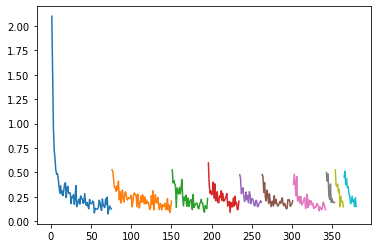

In [50]:
loss_plot(ewc_total_loss_optimised4)

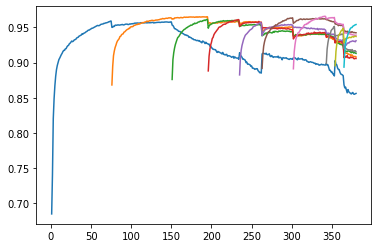

In [51]:
accuracy_plot(ewc_prec_optimised4)